In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Load and prepare data
df = pd.read_csv('Gold Price_Year 2018.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width
window_width = 30  # Adjusted window width for experimentation

# Prepare sequences and corresponding dates
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Ensure that dates and y have the same length
assert len(dates) == len(y), "Mismatch between dates and y lengths"

# Split the data into training, validation, and test sets based on dates
train_mask = dates < pd.to_datetime('2018-10-24')
val_mask = (dates >= pd.to_datetime('2018-10-24')) & (dates < pd.to_datetime('2018-11-28'))
test_mask = dates >= pd.to_datetime('2018-11-28')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Set shuffle=False for sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM.pt
[LSTM] Test Loss: 0.001219
[LSTM] Test MAPE: 10.50%
[LSTM] Test Accuracy: 89.50%

Training GRU model...
Loaded existing model for GRU from best_model_GRU.pt
[GRU] Test Loss: 0.001142
[GRU] Test MAPE: 10.20%
[GRU] Test Accuracy: 89.80%

Training RNN model...
Loaded existing model for RNN from best_model_RNN.pt
[RNN] Test Loss: 0.001297
[RNN] Test MAPE: 10.45%
[RNN] Test Accuracy: 89.55%

Training CNN model...
Loaded existing model for CNN from best_model_CNN.pt
[CNN] Test Loss: 0.005033
[CNN] Test MAPE: 21.94%
[CNN] Test Accuracy: 78.06%

Training EnhancedLSTM model...
Loaded existing model for EnhancedLSTM from best_model_EnhancedLSTM.pt
[EnhancedLSTM] Test Loss: 0.002578
[EnhancedLSTM] Test MAPE: 15.88%
[EnhancedLSTM] Test Accuracy: 84.12%


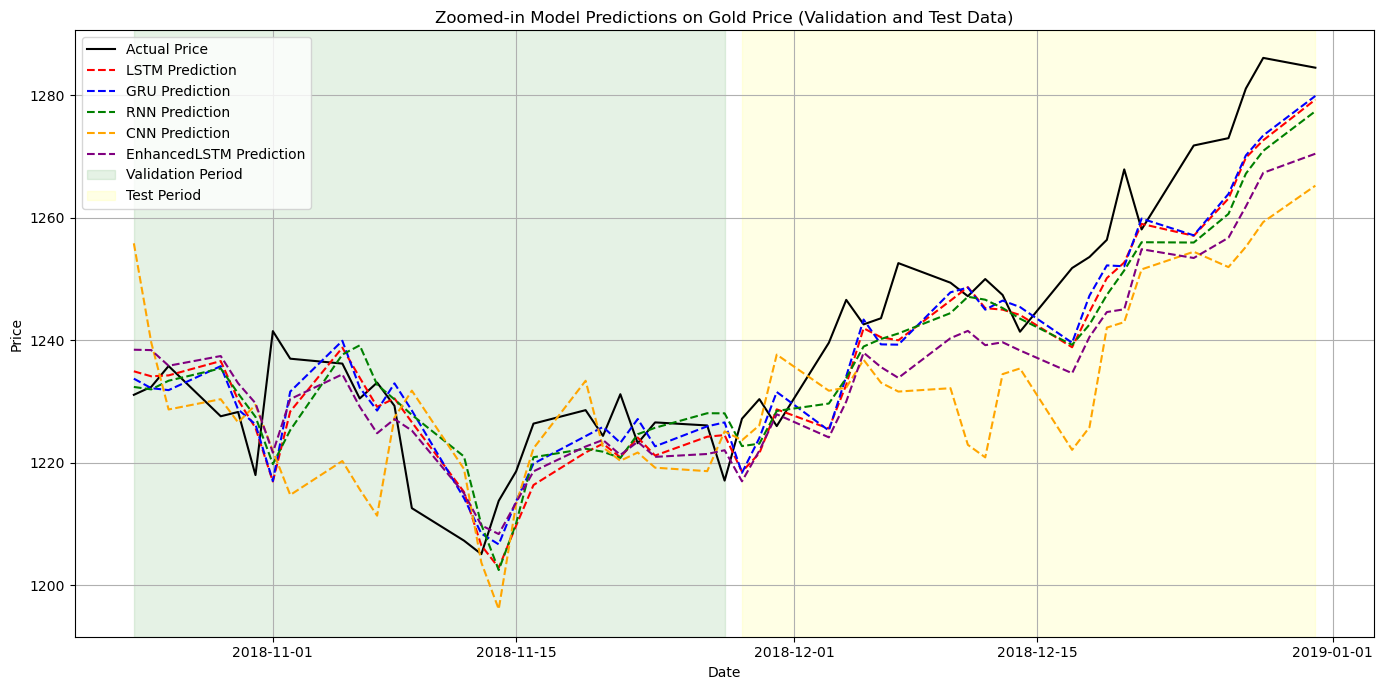

In [5]:

# Define the models
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Calculate the output size after Conv1d layers
            # Each Conv1d layer reduces the sequence length by (kernel_size - 1)
            conv_output_length = window_width - 2 * (3 - 1)  # Two Conv1d layers with kernel_size=3
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # Reshape for Conv1d: (batch_size, channels, seq_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define the inverse_transform function globally
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create a placeholder for other features with zeros
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# Function to train and evaluate a model
def train_and_evaluate(model_name):
    # Initialize the model
    model = BaseModel(model_type=model_name).to(device)
    
    # Define the criterion, optimizer, and scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 800
    best_val_loss = float('inf')
    
    # Lists to store loss history
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    # Path to save the best model checkpoint
    best_model_path = f'best_model_{model_name}.pt'
    
    # Check if a saved model exists and load it
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")

    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    
    # Evaluate on test data
    model.eval()
    test_losses = []
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_losses.append(loss.item())
            y_test_pred_list.append(y_pred.cpu().numpy())
    avg_test_loss = np.mean(test_losses)
    print(f'[{model_name}] Test Loss: {avg_test_loss:.6f}')
    
    # Concatenate test predictions
    y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
    
    # Calculate MAPE and accuracy
    mape = mean_absolute_percentage_error(y_test_tensor.numpy(), y_test_pred_array)
    accuracy = 100 - mape * 100
    print(f'[{model_name}] Test MAPE: {mape * 100:.2f}%')
    print(f'[{model_name}] Test Accuracy: {accuracy:.2f}%')
    
    # Collect predictions over validation and test sets
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    
    y_test_pred = y_test_pred_array
    
    # Inverse scaling
    y_val_pred_inv = inverse_transform(y_val_pred)
    y_test_pred_inv = inverse_transform(y_test_pred)
    
    # Store results
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    
    return results

# List of models to train
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Dictionary to store results
all_results = {}
    
# Train and evaluate each model
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# Inverse transform the actual validation and test target values
y_val_inv = inverse_transform(y_val_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Zoomed-in plot for validation and test data with dashed lines for models
plt.figure(figsize=(14, 7))

# Combine validation and test dates and actual prices
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual prices for validation and test periods
plt.plot(
    zoom_dates,
    zoom_actual,
    color='black',
    label='Actual Price'
)

# Plot predicted data for each model during validation and test periods with dashed lines
for model_name, results in all_results.items():
    # Combine validation and test predictions
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((results['val_dates'], results['test_dates']))
    plt.plot(
        model_dates,
        y_pred_combined,
        color=model_colors[model_name],
        linestyle='--',  # Dashed lines
        label=f'{model_name} Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation and Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Lowest Validation MSE -> ('EnhancedLSTM', 13, 25.096264237428453)
Highest Validation R2   -> ('EnhancedLSTM', 13, 0.8779874906194661)


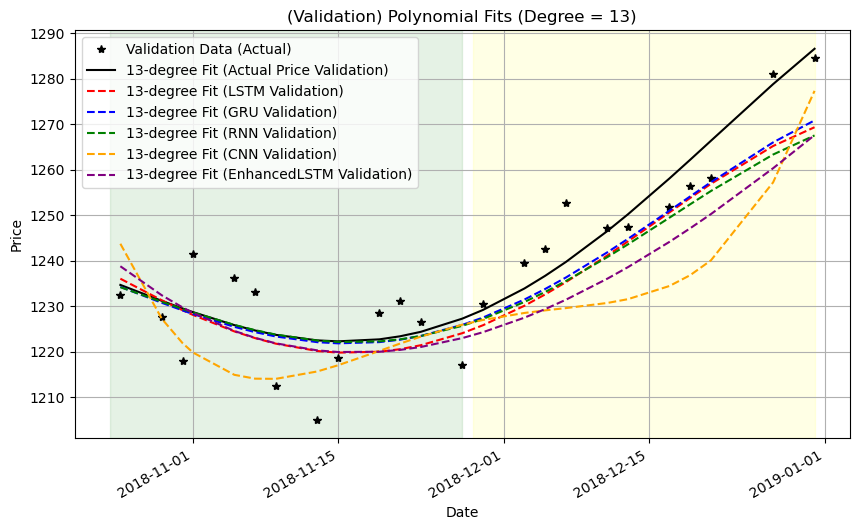


Degree 13 Polynomial Expressions:
----------------------------------------
Actual Price: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0013x^3 + 34.4265x^2 + 358941.2085x - 11893602958.9345
LSTM: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0014x^3 + 37.1399x^2 + 387502.2388x - 12824090835.4343
GRU: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0013x^3 + 33.8339x^2 + 352885.0365x - 11685717237.9590
RNN: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0014x^3 + 36.4376x^2 + 380009.8398x - 12585859312.1819
CNN: y = 0.0000x^13 - 0.0000x^12 - 0.0000x^11 - 0.0000x^10 - 0.0000x^9 + 0.0000x^8 + 0.0000x^7 + 0.0000x^6 + 0.0000x^5 - 0.0000x^4 - 0.0082x^3 - 209.2

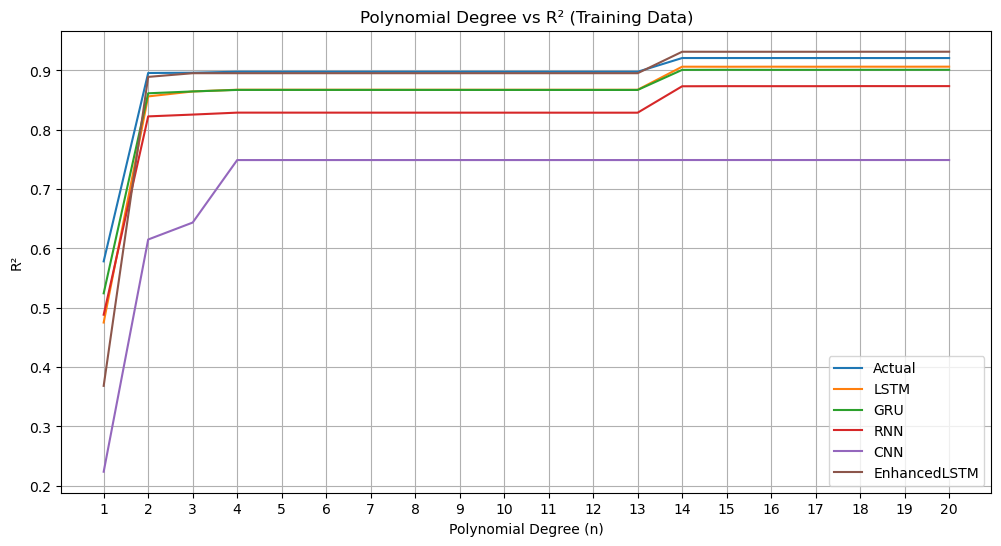

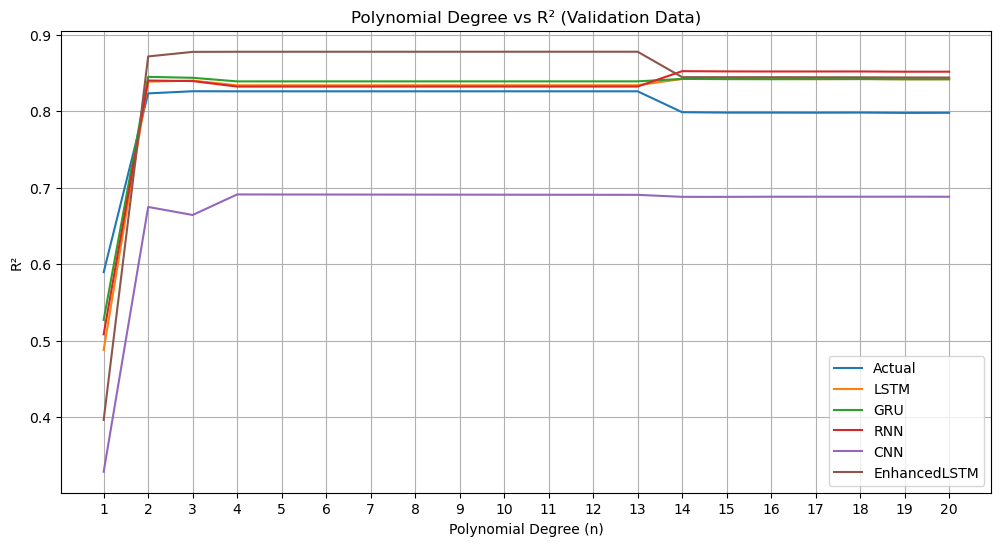

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------------------------
# Assume the following variables already exist from your code base:
#   val_dates  : array of validation dates (pd.DatetimeIndex or np.array of timestamps)
#   test_dates : array of test dates
#   y_val_inv  : array of actual validation prices (in original scale)
#   y_test_inv : array of actual test prices (in original scale)
#
#   all_results: a dictionary where each key is a model name (e.g. 'LSTM'),
#                and each value is another dict containing:
#       - 'y_val_pred_inv' : validation predictions (in original scale)
#       - 'y_test_pred_inv': test predictions (in original scale)
# ------------------------------------------------

# Combine validation + test data
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Convert datetime objects to numeric for polynomial fitting
date_numeric = mdates.date2num(zoom_dates)

model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

training_mask = np.array([d.day % 2 == 0 for d in zoom_dates])
validation_mask = ~training_mask

zoom_dates_train = zoom_dates[training_mask]
zoom_actual_train = zoom_actual[training_mask]
date_numeric_train = date_numeric[training_mask]

zoom_dates_val = zoom_dates[validation_mask]
zoom_actual_val = zoom_actual[validation_mask]
date_numeric_val = date_numeric[validation_mask]

poly_degrees = range(1, 70)

lowest_val_mse = float('inf')
highest_val_r2 = float('-inf')

best_val_mse_info = None
best_val_r2_info = None

# -------------------------------------------------
# 1) Find degrees for the lowest Validation MSE
#    and the highest Validation R2
# -------------------------------------------------
for n in poly_degrees:
    # Fit polynomial to ACTUAL (training) -> Evaluate on validation
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
    val_mse_actual = mean_squared_error(zoom_actual_val, poly_actual_val)
    val_r2_actual  = r2_score(zoom_actual_val, poly_actual_val)

    # Check if Actual's validation MSE / R2 are best
    if val_mse_actual < lowest_val_mse:
        lowest_val_mse = val_mse_actual
        best_val_mse_info = ("Actual", n, val_mse_actual)

    if val_r2_actual > highest_val_r2:
        highest_val_r2 = val_r2_actual
        best_val_r2_info = ("Actual", n, val_r2_actual)

    # Fit polynomial for each model; check validation MSE / R2
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        model_coeff_train = np.polyfit(date_numeric_train, y_pred_train, n)
        model_poly_val    = np.polyval(model_coeff_train, date_numeric_val)
        val_mse_model     = mean_squared_error(y_pred_val, model_poly_val)
        val_r2_model      = r2_score(y_pred_val, model_poly_val)

        if val_mse_model < lowest_val_mse:
            lowest_val_mse = val_mse_model
            best_val_mse_info = (model_name, n, val_mse_model)

        if val_r2_model > highest_val_r2:
            highest_val_r2 = val_r2_model
            best_val_r2_info = (model_name, n, val_r2_model)

print("Lowest Validation MSE ->", best_val_mse_info)
print("Highest Validation R2   ->", best_val_r2_info)

# -------------------------------------------------
# 2) Plot only those degrees (maybe 1 or 2 if distinct):
# -------------------------------------------------
if best_val_mse_info and best_val_r2_info:
    degrees_to_plot = set([best_val_mse_info[1], best_val_r2_info[1]])  # { degreeForMse, degreeForR2 }

    for n in poly_degrees:
        if n in degrees_to_plot:
            # ----------------
            # Plot Training
            # ----------------
            plt.figure(figsize=(10,6))
            # Actual
            plt.plot(zoom_dates_train, zoom_actual_train, 'k*', label='Training Data (Actual)')
            coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
            poly_actual_train = np.polyval(coeff_actual_train, date_numeric_train)
            plt.plot(zoom_dates_train, poly_actual_train, color='black',
                     label=f'{n}-degree Fit (Actual Price Training)')

            # Each model
            for model_name in model_names:
                y_pred_combined = np.concatenate((
                    all_results[model_name]['y_val_pred_inv'],
                    all_results[model_name]['y_test_pred_inv']
                ))
                y_pred_train = y_pred_combined[training_mask]
                coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
                poly_pred_train = np.polyval(coeff_pred_train, date_numeric_train)
                plt.plot(zoom_dates_train, poly_pred_train,
                         color=model_colors[model_name],
                         linestyle='--',
                         label=f'{n}-degree Fit ({model_name} Training)')

            plt.title(f'(Training) Polynomial Fits (Degree = {n})')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.grid(True)
            plt.legend(loc='best')
            plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
            plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
            plt.gcf().autofmt_xdate()
            plt.show()
            plt.pause(0.1)

            # ----------------
            # Plot Validation
            # ----------------
            plt.figure(figsize=(10,6))
            # Actual
            plt.plot(zoom_dates_val, zoom_actual_val, 'k*', label='Validation Data (Actual)')
            poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
            plt.plot(zoom_dates_val, poly_actual_val, color='black',
                     label=f'{n}-degree Fit (Actual Price Validation)')

            # Each model
            for model_name in model_names:
                y_pred_combined = np.concatenate((
                    all_results[model_name]['y_val_pred_inv'],
                    all_results[model_name]['y_test_pred_inv']
                ))
                y_pred_train = y_pred_combined[training_mask]
                coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
                poly_pred_val = np.polyval(coeff_pred_train, date_numeric_val)
                plt.plot(zoom_dates_val, poly_pred_val,
                         color=model_colors[model_name],
                         linestyle='--',
                         label=f'{n}-degree Fit ({model_name} Validation)')

            plt.title(f'(Validation) Polynomial Fits (Degree = {n})')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.grid(True)
            plt.legend(loc='best')
            plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
            plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
            plt.gcf().autofmt_xdate()
            plt.show()
            plt.pause(0.1)


### Polynomial Expressions for Best Degrees ###

def format_polynomial(coeffs):
    """
    Formats polynomial coefficients into a readable mathematical expression.
    
    Args:
        coeffs (array-like): Polynomial coefficients, highest degree first.
        
    Returns:
        str: Formatted polynomial expression.
    """
    terms = []
    degree = len(coeffs) - 1
    for i, coef in enumerate(coeffs):
        power = degree - i
        if coef != 0:
            # Format coefficient
            if coef < 0:
                sign = " - " if i != 0 else "-"
                coef = abs(coef)
            else:
                sign = " + " if i != 0 else ""
            if power == 0:
                term = f"{sign}{coef:.4f}"
            elif power == 1:
                term = f"{sign}{coef:.4f}x"
            else:
                term = f"{sign}{coef:.4f}x^{power}"
            terms.append(term)
    return "".join(terms) if terms else "0"

# Extract the best degrees for Validation MSE and Validation R2
degrees_to_plot = set()
if best_val_mse_info:
    degrees_to_plot.add(best_val_mse_info[1])
if best_val_r2_info:
    degrees_to_plot.add(best_val_r2_info[1])

for n in degrees_to_plot:
    print(f"\nDegree {n} Polynomial Expressions:\n{'-'*40}")
    
    # ----------------------------
    # Actual Price Polynomial
    # ----------------------------
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    expr_actual = format_polynomial(coeff_actual_train)
    print(f"Actual Price: y = {expr_actual}")
    
    # ----------------------------
    # Machine Learning Models Polynomials
    # ----------------------------
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        
        coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
        expr_model = format_polynomial(coeff_pred_train)
        print(f"{model_name}: y = {expr_model}")


### Plot the MSE and R2 Values VS Polynomial Degree of Training and Validation Data ###

# 1) Collect MSE and R2 for n = 1 to 20 (Actual + Each Model)
max_degree = 20
models_plus_actual = ['Actual'] + model_names  # "Actual" + your ML models

# Initialize dictionaries to store MSE/R2 arrays
train_mse_dict = {m: np.zeros(max_degree) for m in models_plus_actual}
val_mse_dict   = {m: np.zeros(max_degree) for m in models_plus_actual}
train_r2_dict  = {m: np.zeros(max_degree) for m in models_plus_actual}
val_r2_dict    = {m: np.zeros(max_degree) for m in models_plus_actual}

# Loop over degrees 1..20
for n in range(1, max_degree+1):
    idx = n - 1  # array index

    # ------------------
    # A) Actual Price
    # ------------------
    coeff_actual = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_train_actual = np.polyval(coeff_actual, date_numeric_train)
    poly_val_actual   = np.polyval(coeff_actual, date_numeric_val)

    # Compute training metrics
    train_mse_dict['Actual'][idx] = mean_squared_error(zoom_actual_train, poly_train_actual)
    train_r2_dict['Actual'][idx]  = r2_score(zoom_actual_train, poly_train_actual)

    # Compute validation metrics
    val_mse_dict['Actual'][idx] = mean_squared_error(zoom_actual_val, poly_val_actual)
    val_r2_dict['Actual'][idx]  = r2_score(zoom_actual_val, poly_val_actual)

    # ------------------
    # B) Each model
    # ------------------
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        coeff_model = np.polyfit(date_numeric_train, y_pred_train, n)
        poly_train_model = np.polyval(coeff_model, date_numeric_train)
        poly_val_model   = np.polyval(coeff_model, date_numeric_val)

        train_mse_dict[model_name][idx] = mean_squared_error(y_pred_train, poly_train_model)
        train_r2_dict[model_name][idx]  = r2_score(y_pred_train, poly_train_model)

        val_mse_dict[model_name][idx] = mean_squared_error(y_pred_val, poly_val_model)
        val_r2_dict[model_name][idx]  = r2_score(y_pred_val, poly_val_model)

# 2) Plot MSE vs nth Degree (Training & Validation)
degrees = np.arange(1, max_degree + 1)

plt.figure(figsize=(12, 6))
plt.title("Polynomial Degree vs MSE (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees, train_mse_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("MSE")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.title("Polynomial Degree vs MSE (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees, val_mse_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("MSE")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 3) Plot R^2 vs nth Degree (Training & Validation)
plt.figure(figsize=(12, 6))
plt.title("Polynomial Degree vs R² (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees, train_r2_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("R²")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.title("Polynomial Degree vs R² (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees, val_r2_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("R²")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)
plt.show()

Lowest Validation MSE -> ('EnhancedLSTM', 13, 25.096264237428453)
Highest Validation R²   -> ('EnhancedLSTM', 13, 0.8779874906194661)


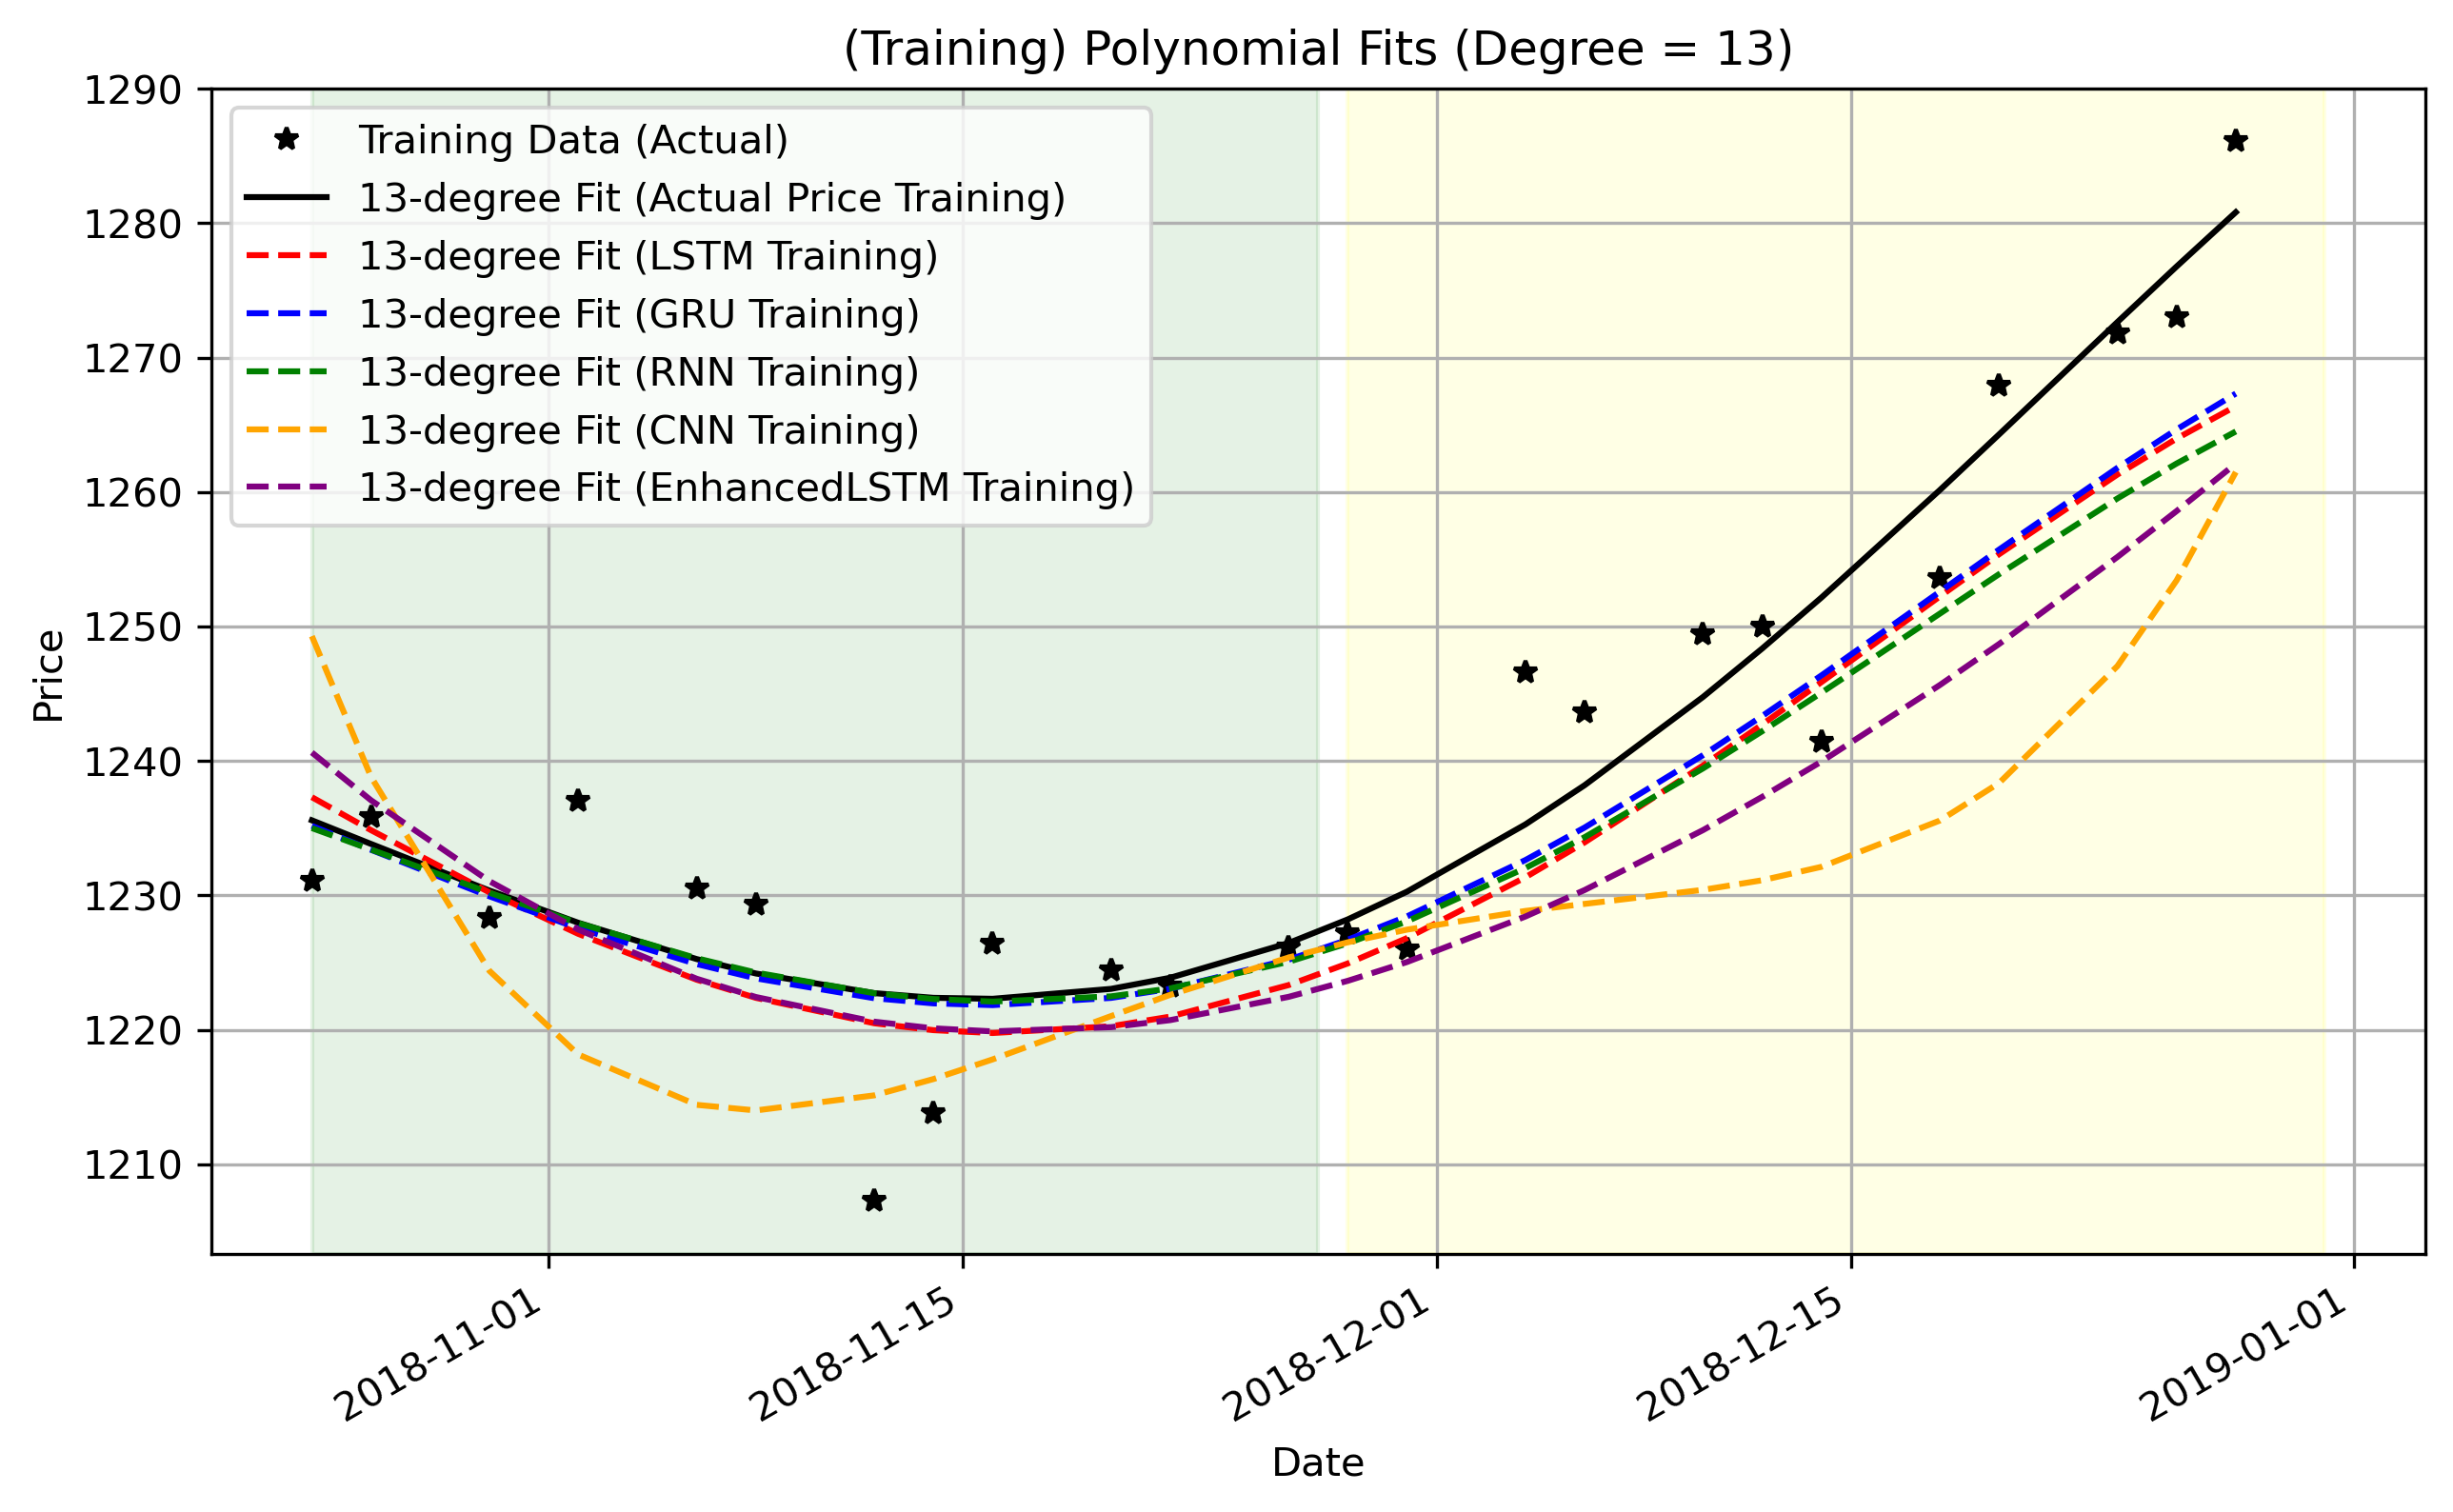

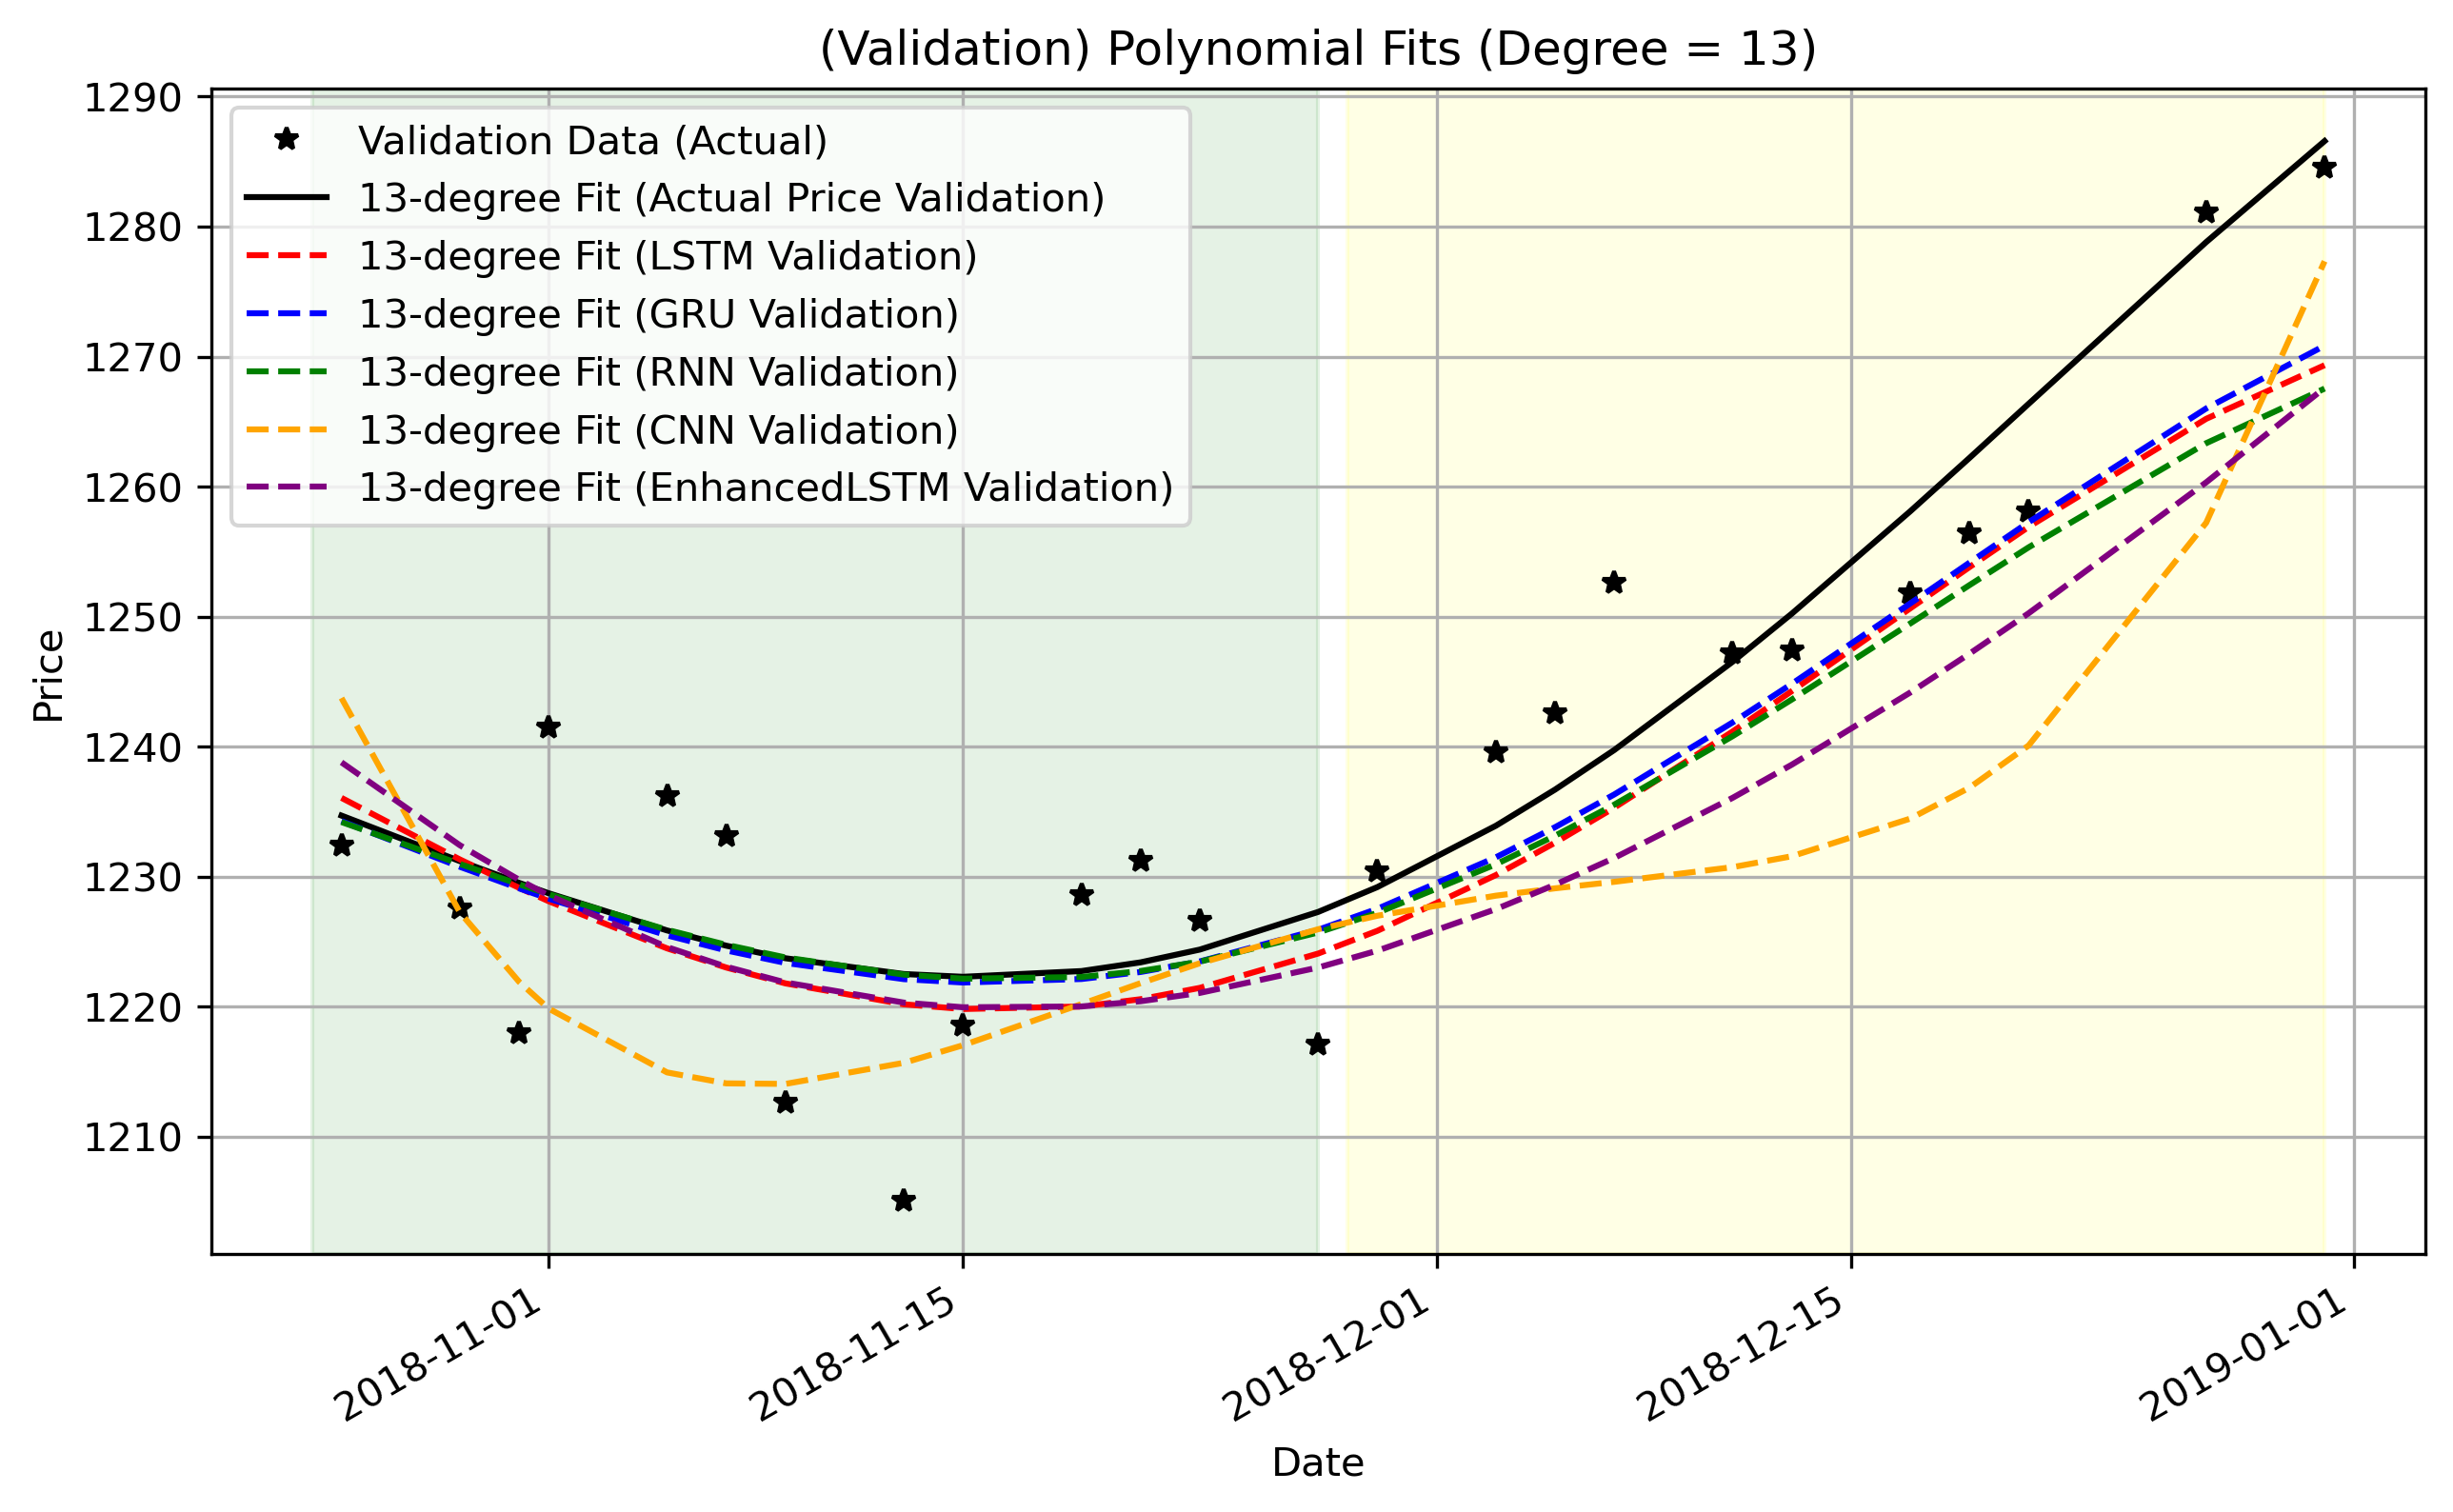


Degree 13 Polynomial Expressions:
----------------------------------------
Actual Price: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0013x^3 + 34.4265x^2 + 358941.2085x - 11893602958.9345
LSTM: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0014x^3 + 37.1399x^2 + 387502.2388x - 12824090835.4343
GRU: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0013x^3 + 33.8339x^2 + 352885.0365x - 11685717237.9590
RNN: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0014x^3 + 36.4376x^2 + 380009.8398x - 12585859312.1819
CNN: y = 0.0000x^13 - 0.0000x^12 - 0.0000x^11 - 0.0000x^10 - 0.0000x^9 + 0.0000x^8 + 0.0000x^7 + 0.0000x^6 + 0.0000x^5 - 0.0000x^4 - 0.0082x^3 - 209.2

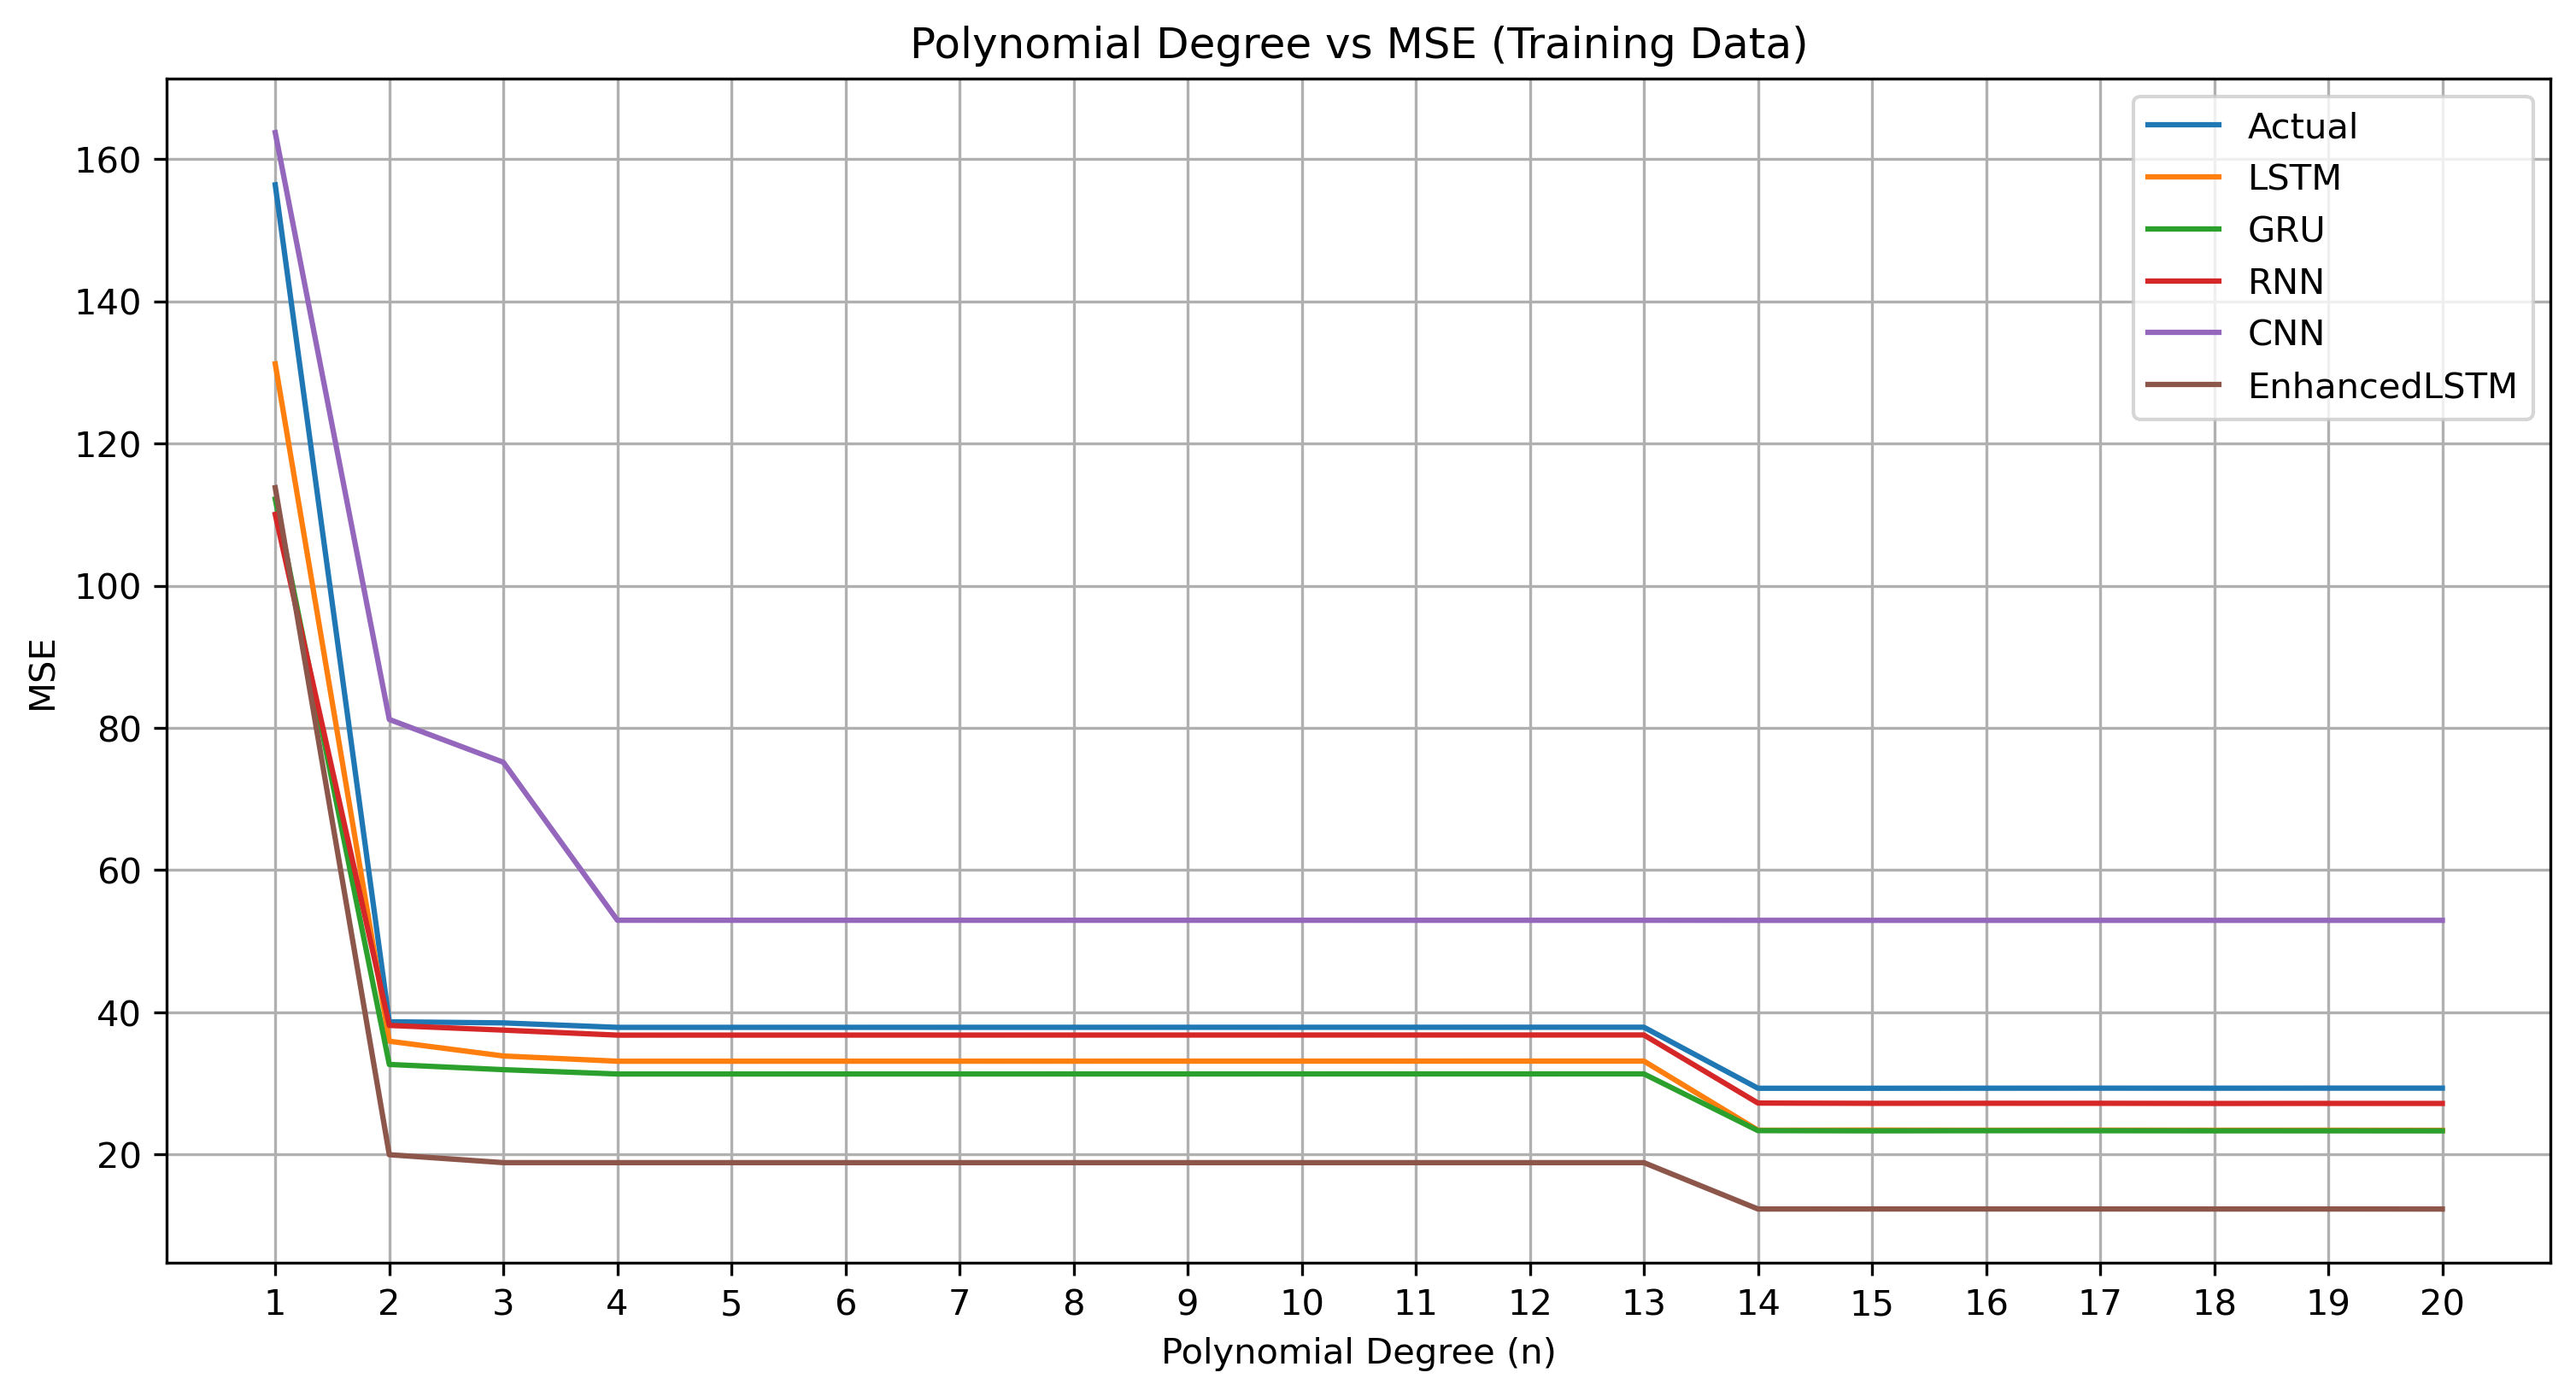

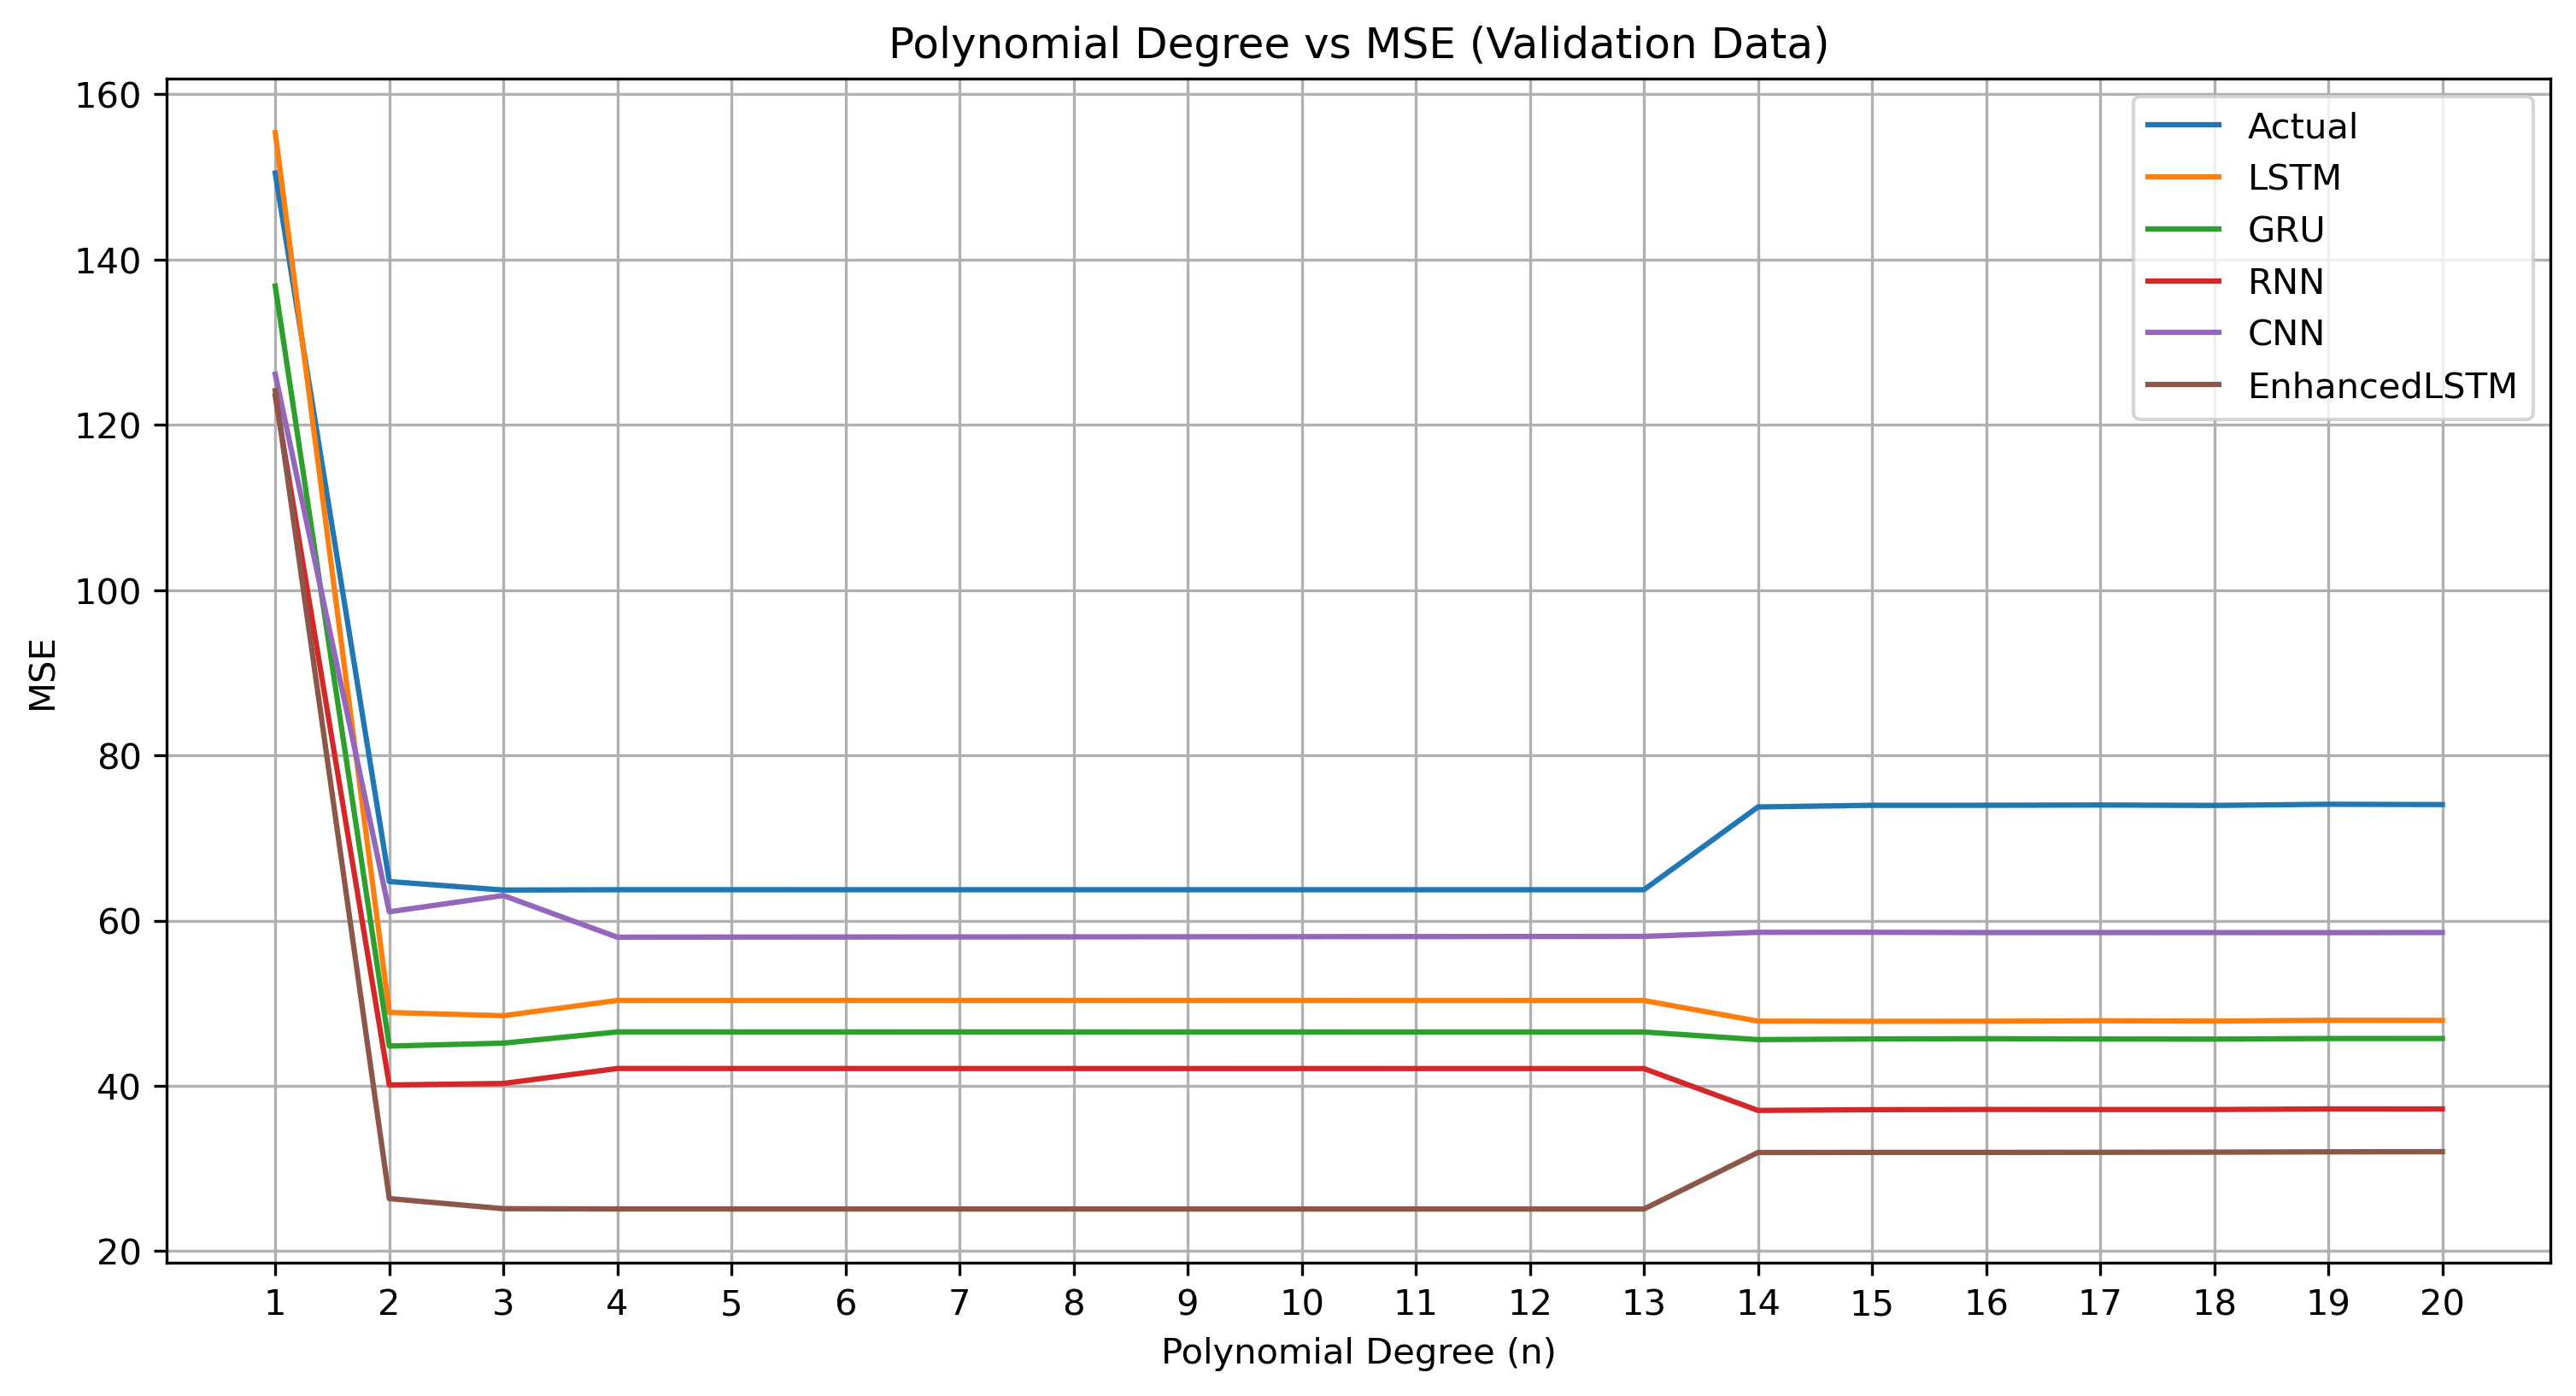

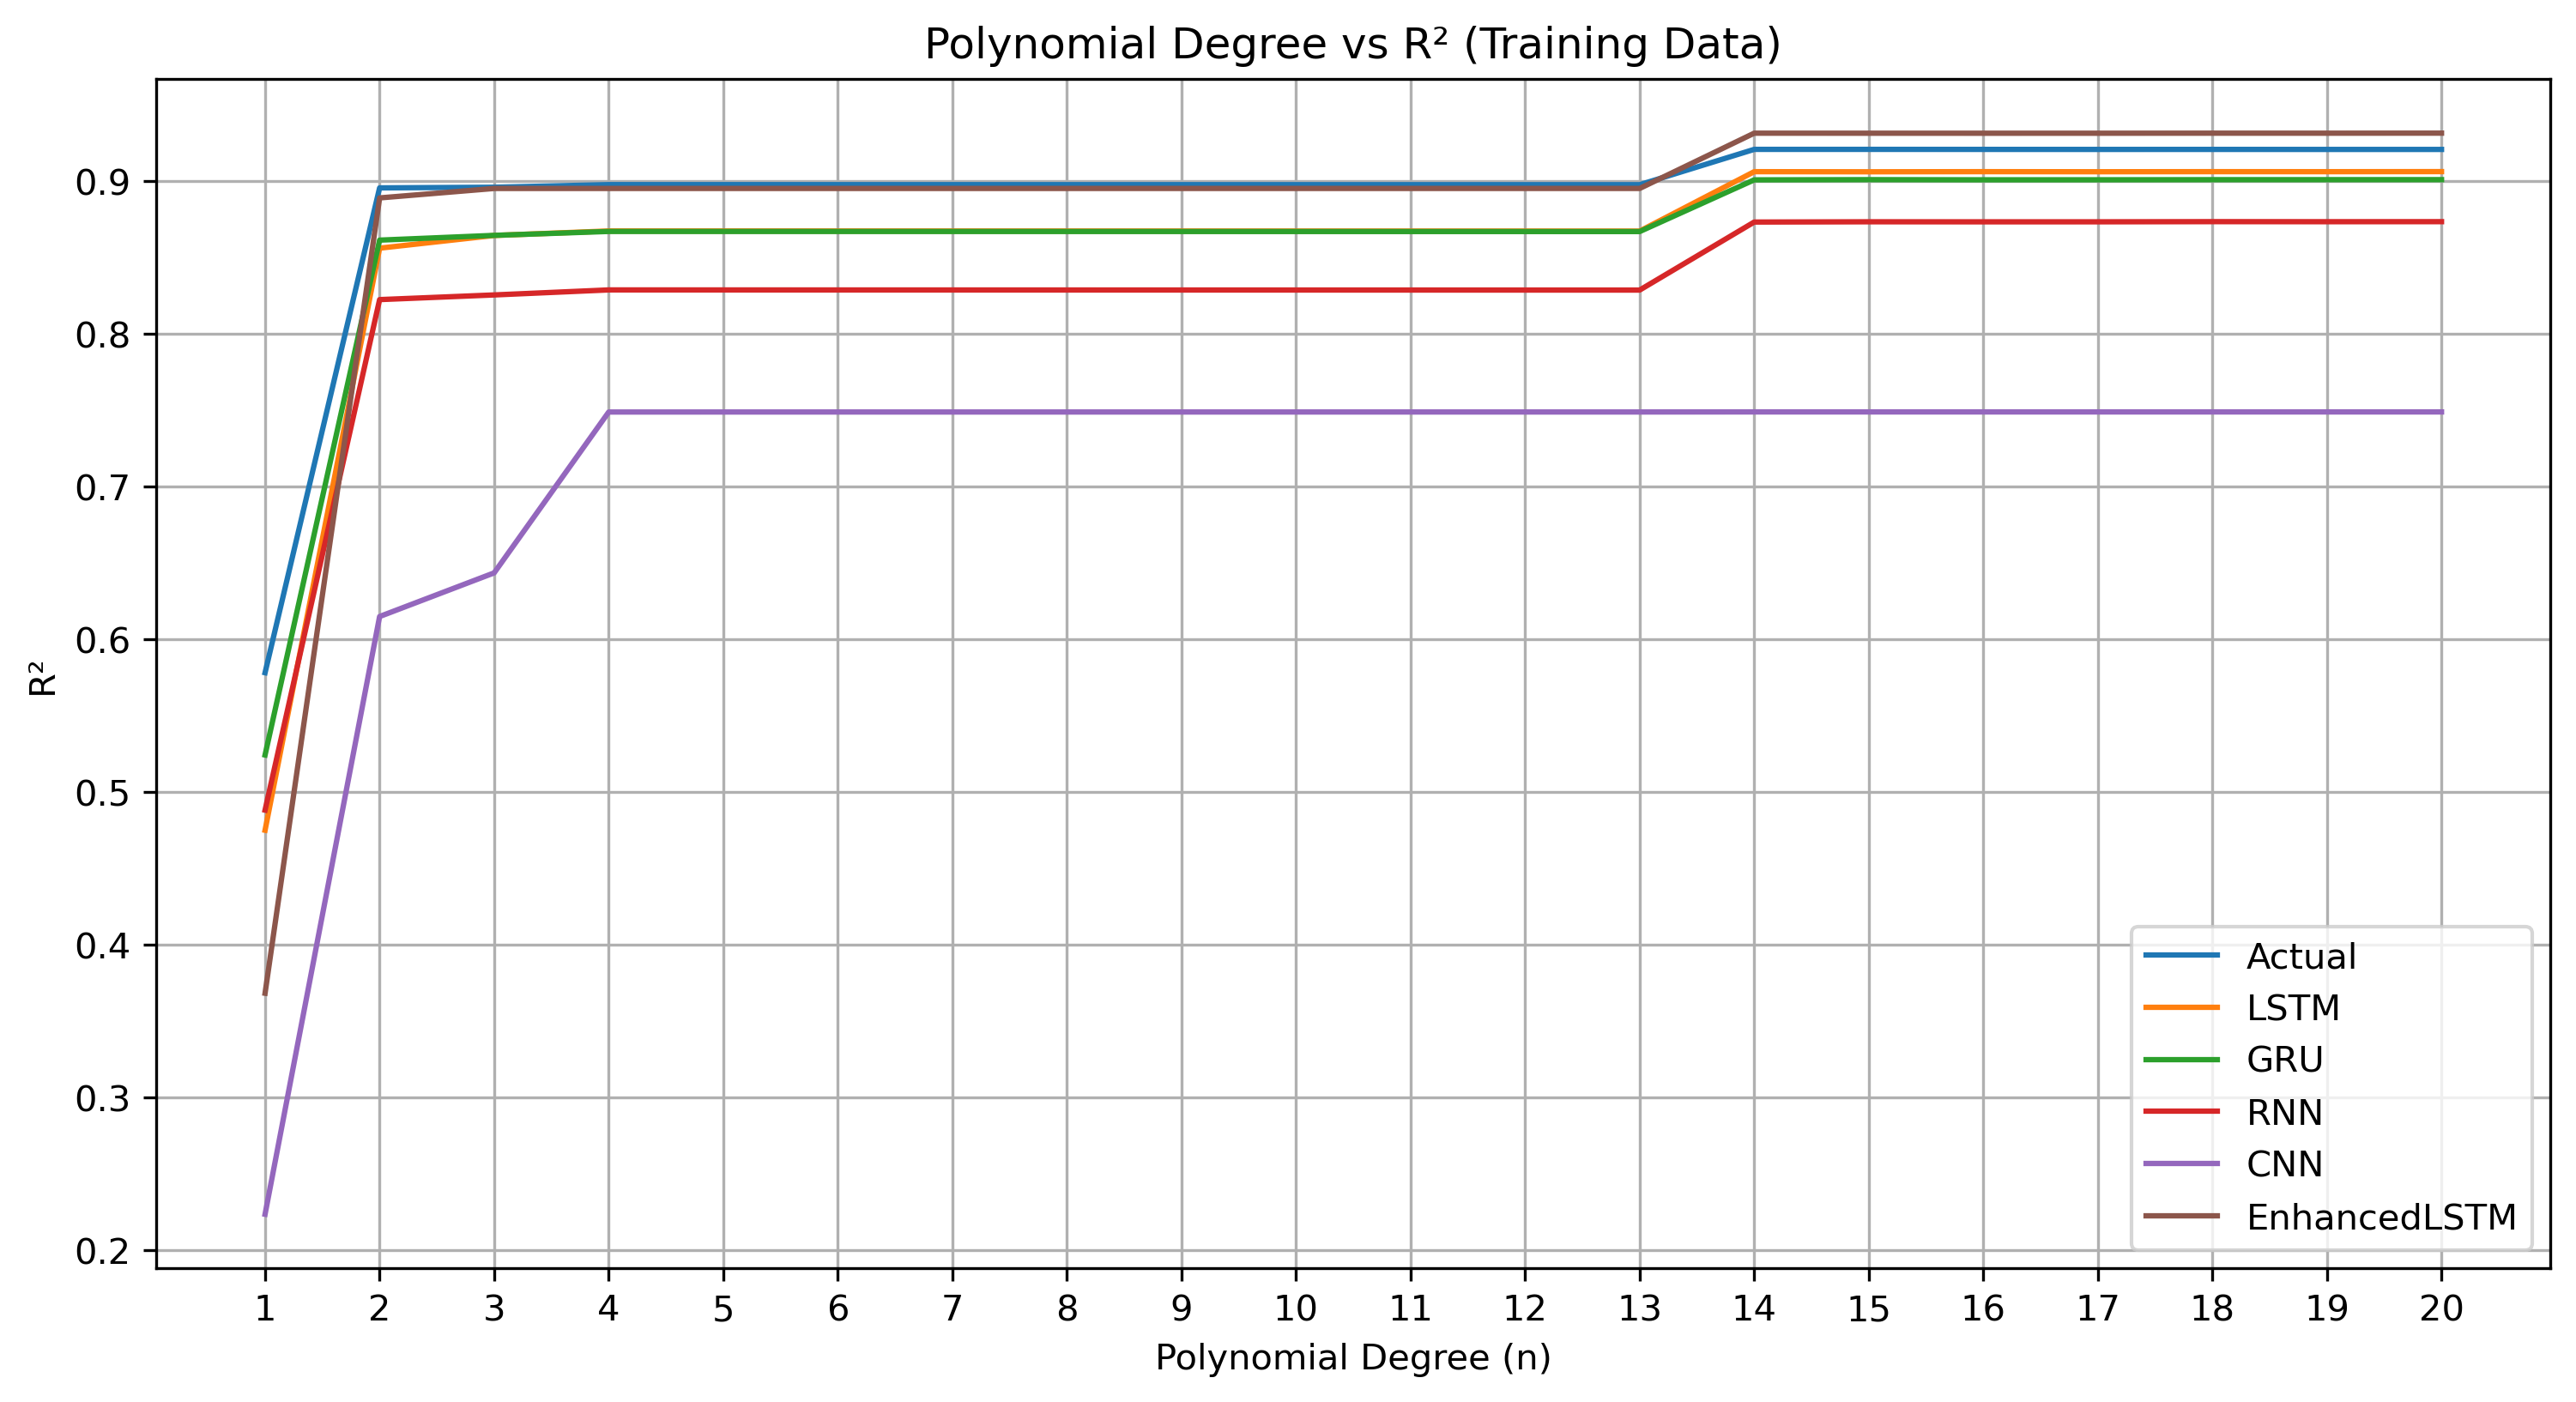

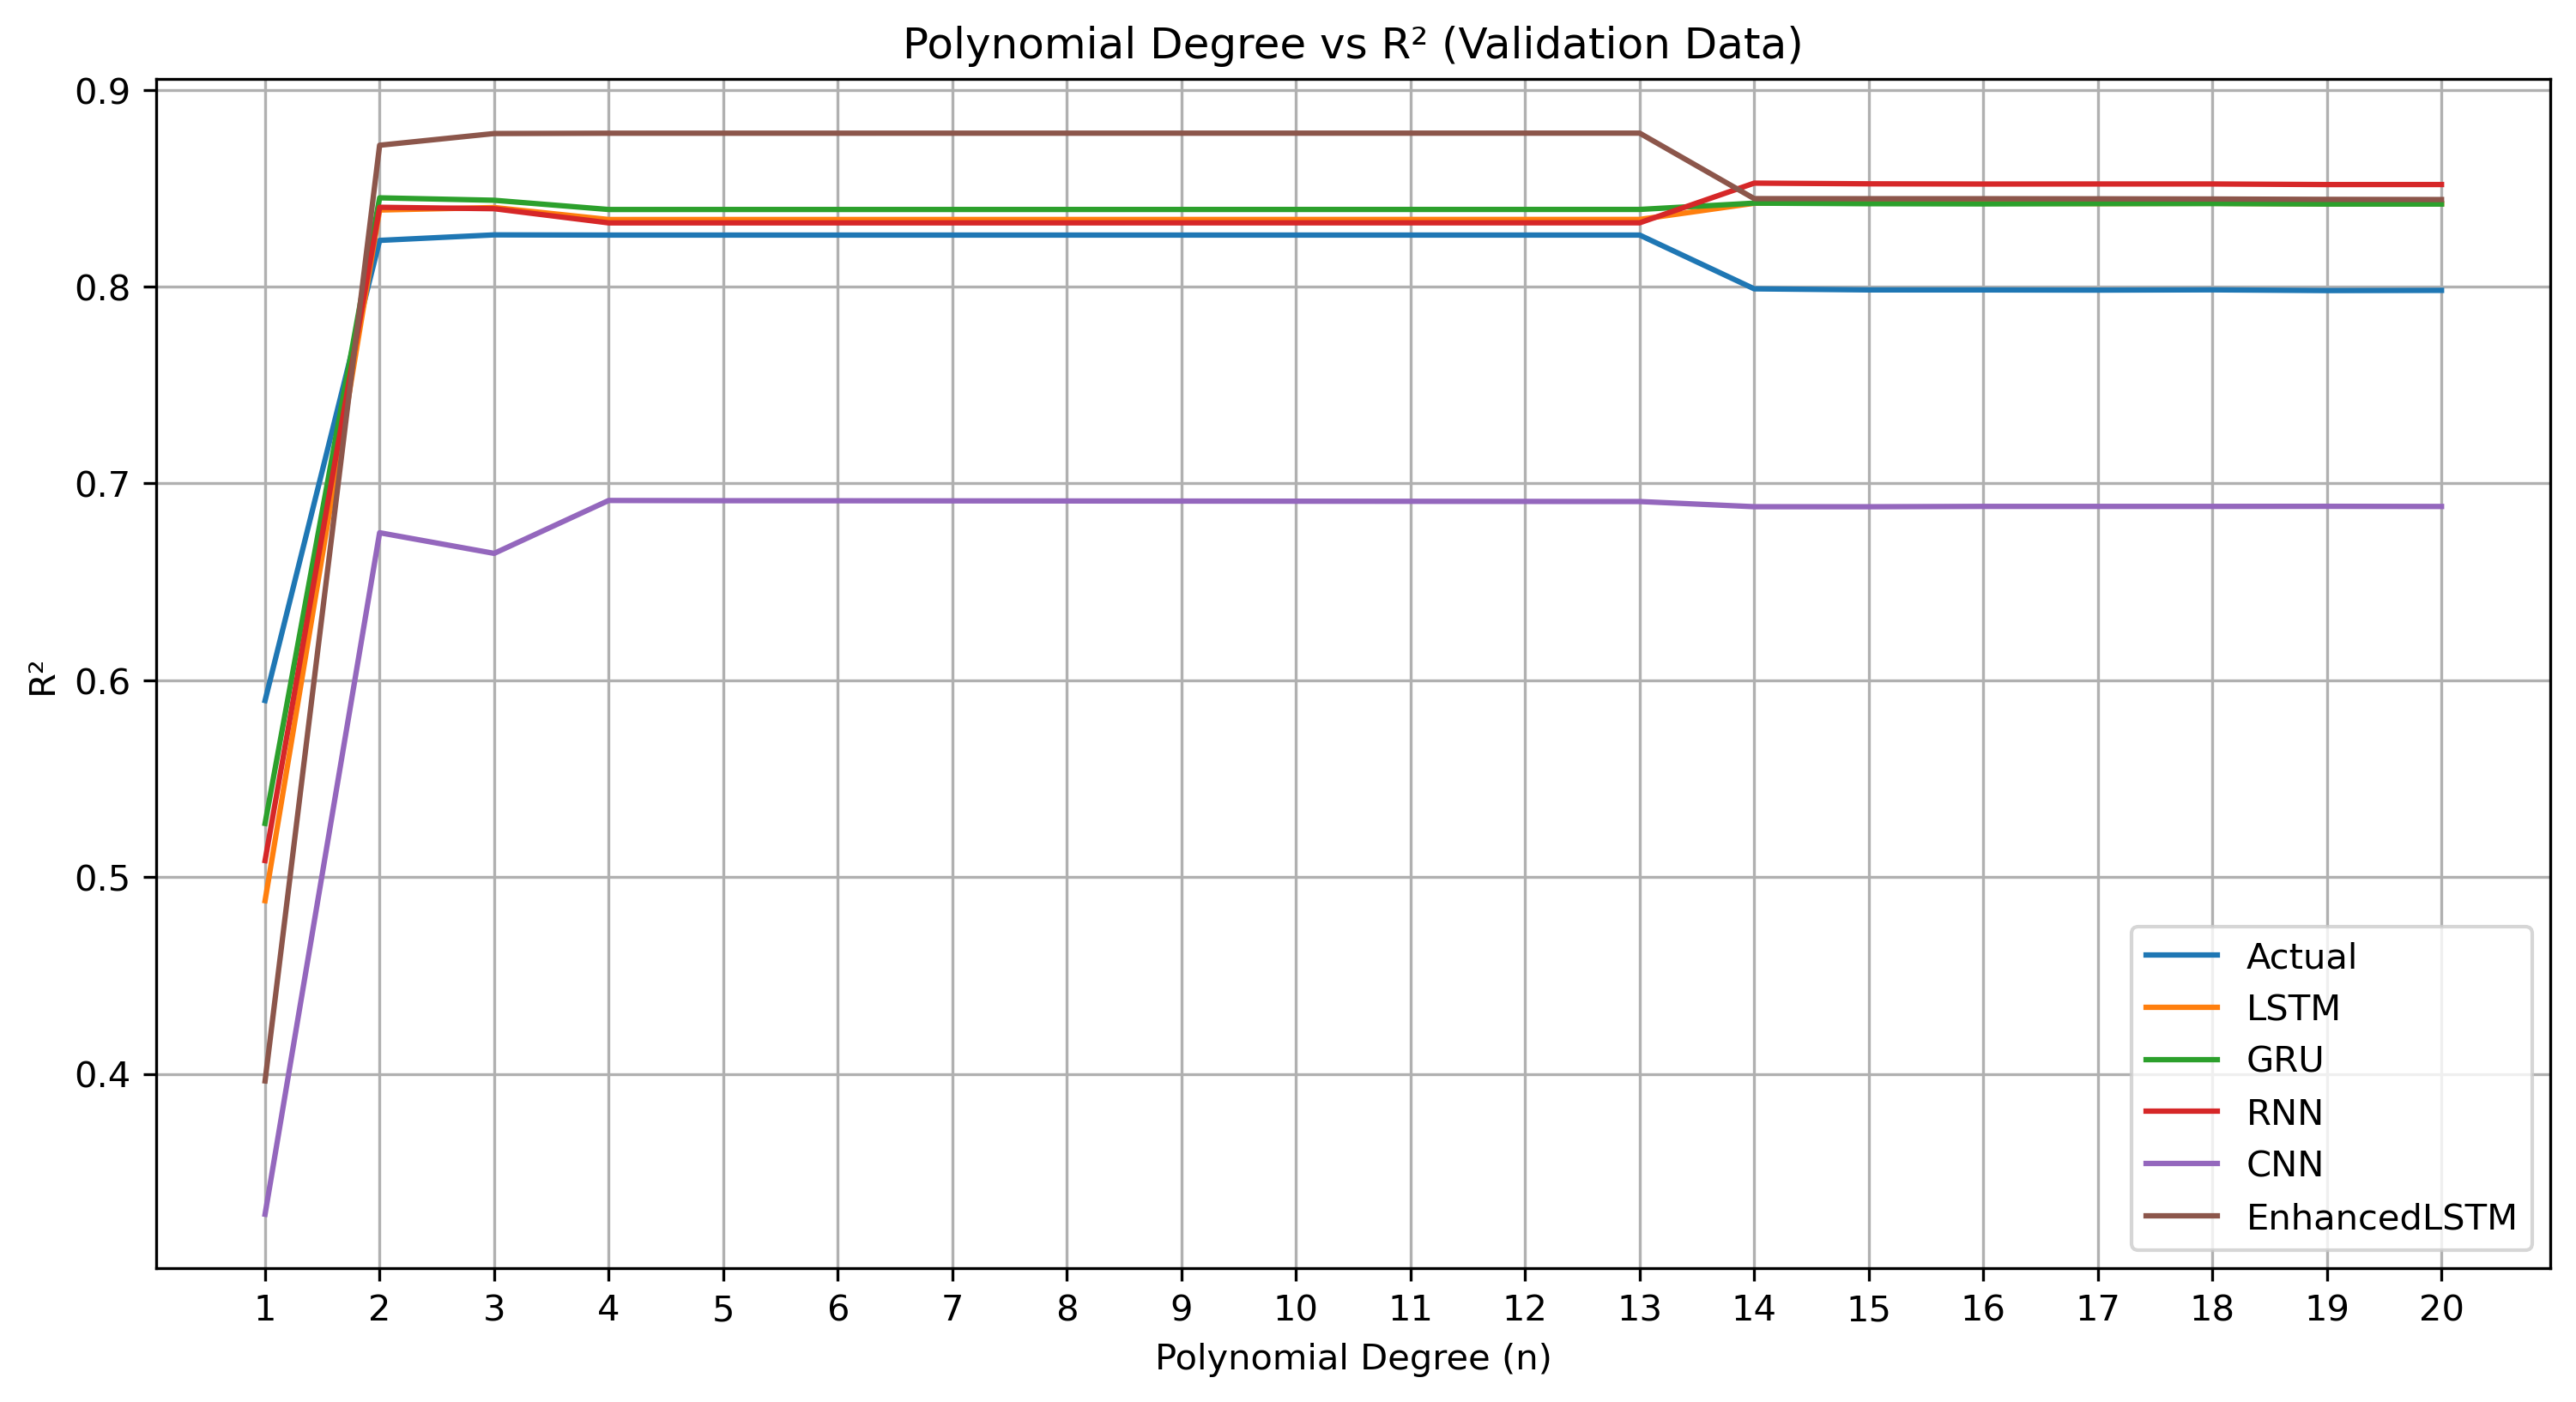

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------------------------
# Assume the following variables already exist in your code base:
#   val_dates  : array of validation dates (pd.DatetimeIndex or np.array of timestamps)
#   test_dates : array of test dates
#   y_val_inv  : array of actual validation prices (in original scale)
#   y_test_inv : array of actual test prices (in original scale)
#
#   all_results: a dictionary where each key is a model name (e.g. 'LSTM'),
#                and each value is another dict containing:
#       - 'y_val_pred_inv' : validation predictions (in original scale)
#       - 'y_test_pred_inv': test predictions (in original scale)
# ------------------------------------------------

# Combine validation + test data
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Convert datetime objects to numeric for polynomial fitting
date_numeric = mdates.date2num(zoom_dates)

# Define model names and their corresponding colors
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Create masks for training (even days) and validation (odd days)
training_mask = np.array([d.day % 2 == 0 for d in zoom_dates])  # Even day
validation_mask = ~training_mask  # Odd day

# Extract training and validation subsets
zoom_dates_train = zoom_dates[training_mask]
zoom_actual_train = zoom_actual[training_mask]
date_numeric_train = date_numeric[training_mask]

zoom_dates_val = zoom_dates[validation_mask]
zoom_actual_val = zoom_actual[validation_mask]
date_numeric_val = date_numeric[validation_mask]

# Define the range of polynomial degrees to evaluate
poly_degrees = range(1, 70)  # Degrees from 1 to 69

# Initialize variables to track the best validation MSE and R²
lowest_val_mse = float('inf')
highest_val_r2 = float('-inf')

best_val_mse_info = None
best_val_r2_info = None

# -------------------------------------------------
# 1) Find degrees for the lowest Validation MSE
#    and the highest Validation R²
# -------------------------------------------------
for n in poly_degrees:
    # Fit polynomial to ACTUAL (training) -> Evaluate on validation
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
    val_mse_actual = mean_squared_error(zoom_actual_val, poly_actual_val)
    val_r2_actual  = r2_score(zoom_actual_val, poly_actual_val)

    # Check if Actual's validation MSE / R² are best
    if val_mse_actual < lowest_val_mse:
        lowest_val_mse = val_mse_actual
        best_val_mse_info = ("Actual", n, val_mse_actual)

    if val_r2_actual > highest_val_r2:
        highest_val_r2 = val_r2_actual
        best_val_r2_info = ("Actual", n, val_r2_actual)

    # Fit polynomial for each model; check validation MSE / R²
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        model_coeff_train = np.polyfit(date_numeric_train, y_pred_train, n)
        model_poly_val    = np.polyval(model_coeff_train, date_numeric_val)
        val_mse_model     = mean_squared_error(y_pred_val, model_poly_val)
        val_r2_model      = r2_score(y_pred_val, model_poly_val)

        if val_mse_model < lowest_val_mse:
            lowest_val_mse = val_mse_model
            best_val_mse_info = (model_name, n, val_mse_model)

        if val_r2_model > highest_val_r2:
            highest_val_r2 = val_r2_model
            best_val_r2_info = (model_name, n, val_r2_model)

print("Lowest Validation MSE ->", best_val_mse_info)
print("Highest Validation R²   ->", best_val_r2_info)

# -------------------------------------------------
# 2) Plot only those degrees (maybe 1 or 2 if distinct)
# -------------------------------------------------
if best_val_mse_info and best_val_r2_info:
    degrees_to_plot = set([best_val_mse_info[1], best_val_r2_info[1]])  # { degreeForMse, degreeForR2 }

    for n in degrees_to_plot:
        # ----------------
        # Plot Training
        # ----------------
        plt.figure(figsize=(10,6), dpi=300)
        # Actual
        plt.plot(zoom_dates_train, zoom_actual_train, 'k*', label='Training Data (Actual)')
        coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
        poly_actual_train = np.polyval(coeff_actual_train, date_numeric_train)
        plt.plot(zoom_dates_train, poly_actual_train, color='black',
                 label=f'{n}-degree Fit (Actual Price Training)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_train = np.polyval(coeff_pred_train, date_numeric_train)
            plt.plot(zoom_dates_train, poly_pred_train,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Training)')

        plt.title(f'(Training) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()
        plt.pause(0.1)

        # ----------------
        # Plot Validation
        # ----------------
        plt.figure(figsize=(10,6),dpi=300)
        # Actual
        plt.plot(zoom_dates_val, zoom_actual_val, 'k*', label='Validation Data (Actual)')
        poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
        plt.plot(zoom_dates_val, poly_actual_val, color='black',
                 label=f'{n}-degree Fit (Actual Price Validation)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_val = np.polyval(coeff_pred_train, date_numeric_val)
            plt.plot(zoom_dates_val, poly_pred_val,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Validation)')

        plt.title(f'(Validation) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()
        plt.pause(0.1)

def format_polynomial(coeffs):
    """
    Formats polynomial coefficients into a readable mathematical expression.
    
    Args:
        coeffs (array-like): Polynomial coefficients, highest degree first.
        
    Returns:
        str: Formatted polynomial expression.
    """
    terms = []
    degree = len(coeffs) - 1
    for i, coef in enumerate(coeffs):
        power = degree - i
        if coef != 0:
            # Format coefficient
            if coef < 0:
                sign = " - " if i != 0 else "-"
                coef = abs(coef)
            else:
                sign = " + " if i != 0 else ""
            if power == 0:
                term = f"{sign}{coef:.4f}"
            elif power == 1:
                term = f"{sign}{coef:.4f}x"
            else:
                term = f"{sign}{coef:.4f}x^{power}"
            terms.append(term)
    return "".join(terms) if terms else "0"

# ------------------------------------------------
# 3) Print Mathematical Expressions for Best Degrees
# ------------------------------------------------
# Extract the best degrees for Validation MSE and Validation R²
degrees_to_plot_expressions = set()
if best_val_mse_info:
    degrees_to_plot_expressions.add(best_val_mse_info[1])
if best_val_r2_info:
    degrees_to_plot_expressions.add(best_val_r2_info[1])

for n in degrees_to_plot_expressions:
    print(f"\nDegree {n} Polynomial Expressions:\n{'-'*40}")
    
    # ----------------------------
    # Actual Price Polynomial
    # ----------------------------
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    expr_actual = format_polynomial(coeff_actual_train)
    print(f"Actual Price: y = {expr_actual}")
    
    # ----------------------------
    # Machine Learning Models Polynomials
    # ----------------------------
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        
        coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
        expr_model = format_polynomial(coeff_pred_train)
        print(f"{model_name}: y = {expr_model}")

# -------------------------------------------------
# 4) Plot MSE and R² vs Polynomial Degree (n = 1 to 20)
#    with Focused Y-Axis Scaling
# -------------------------------------------------

# Redefine max_degree for plotting purposes
plot_max_degree = 20
models_plus_actual = ['Actual'] + model_names  # "Actual" + your ML models

# Initialize dictionaries to store MSE/R² arrays for plotting
train_mse_dict = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_mse_dict   = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
train_r2_dict  = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_r2_dict    = {m: np.zeros(plot_max_degree) for m in models_plus_actual}

# Loop over degrees 1..20
for n in range(1, plot_max_degree+1):
    idx = n - 1  # array index

    # ------------------
    # A) Actual Price
    # ------------------
    coeff_actual = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_train_actual = np.polyval(coeff_actual, date_numeric_train)
    poly_val_actual   = np.polyval(coeff_actual, date_numeric_val)

    # Compute training metrics
    train_mse_dict['Actual'][idx] = mean_squared_error(zoom_actual_train, poly_train_actual)
    train_r2_dict['Actual'][idx]  = r2_score(zoom_actual_train, poly_train_actual)

    # Compute validation metrics
    val_mse_dict['Actual'][idx] = mean_squared_error(zoom_actual_val, poly_val_actual)
    val_r2_dict['Actual'][idx]  = r2_score(zoom_actual_val, poly_val_actual)

    # ------------------
    # B) Each model
    # ------------------
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        coeff_model = np.polyfit(date_numeric_train, y_pred_train, n)
        poly_train_model = np.polyval(coeff_model, date_numeric_train)
        poly_val_model   = np.polyval(coeff_model, date_numeric_val)

        train_mse_dict[model_name][idx] = mean_squared_error(y_pred_train, poly_train_model)
        train_r2_dict[model_name][idx]  = r2_score(y_pred_train, poly_train_model)

        val_mse_dict[model_name][idx] = mean_squared_error(y_pred_val, poly_val_model)
        val_r2_dict[model_name][idx]  = r2_score(y_pred_val, poly_val_model)

# Define a function to set focused y-axis limits
def set_focused_ylim(data_dict, metric, buffer_ratio=0.05):
    """
    Sets y-axis limits based on the min and max of the provided data with a buffer.

    Args:
        data_dict (dict): Dictionary containing data arrays for different models.
        metric (str): The metric being plotted ('MSE' or 'R²').
        buffer_ratio (float): The ratio of buffer to add to the limits.

    Returns:
        tuple: (ymin, ymax) for plt.ylim()
    """
    all_values = np.concatenate(list(data_dict.values()))
    ymin = np.min(all_values)
    ymax = np.max(all_values)
    buffer = (ymax - ymin) * buffer_ratio
    return ymin - buffer, ymax + buffer

# Define degrees array
degrees = np.arange(1, plot_max_degree + 1)

# --- Training MSE ---
plt.figure(figsize=(12, 6),dpi=300)
plt.title("Polynomial Degree vs MSE (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees, train_mse_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("MSE")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(train_mse_dict, metric='MSE')
plt.ylim(ymin, ymax)
plt.show()

# --- Validation MSE ---
plt.figure(figsize=(12, 6),dpi=300)
plt.title("Polynomial Degree vs MSE (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees, val_mse_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("MSE")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(val_mse_dict, metric='MSE')
plt.ylim(ymin, ymax)
plt.show()

# --- Training R² ---
plt.figure(figsize=(12, 6),dpi=300)
plt.title("Polynomial Degree vs R² (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees, train_r2_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("R²")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(train_r2_dict, metric='R²')
plt.ylim(ymin, ymax)
plt.show()

# --- Validation R² ---
plt.figure(figsize=(12, 6),dpi=300)
plt.title("Polynomial Degree vs R² (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees, val_r2_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("R²")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(val_r2_dict, metric='R²')
plt.ylim(ymin, ymax)
plt.show()

Lowest Validation MSE -> ('EnhancedLSTM', 13, 25.096264237428453)
Highest Validation R²   -> ('EnhancedLSTM', 13, 0.8779874906194661)


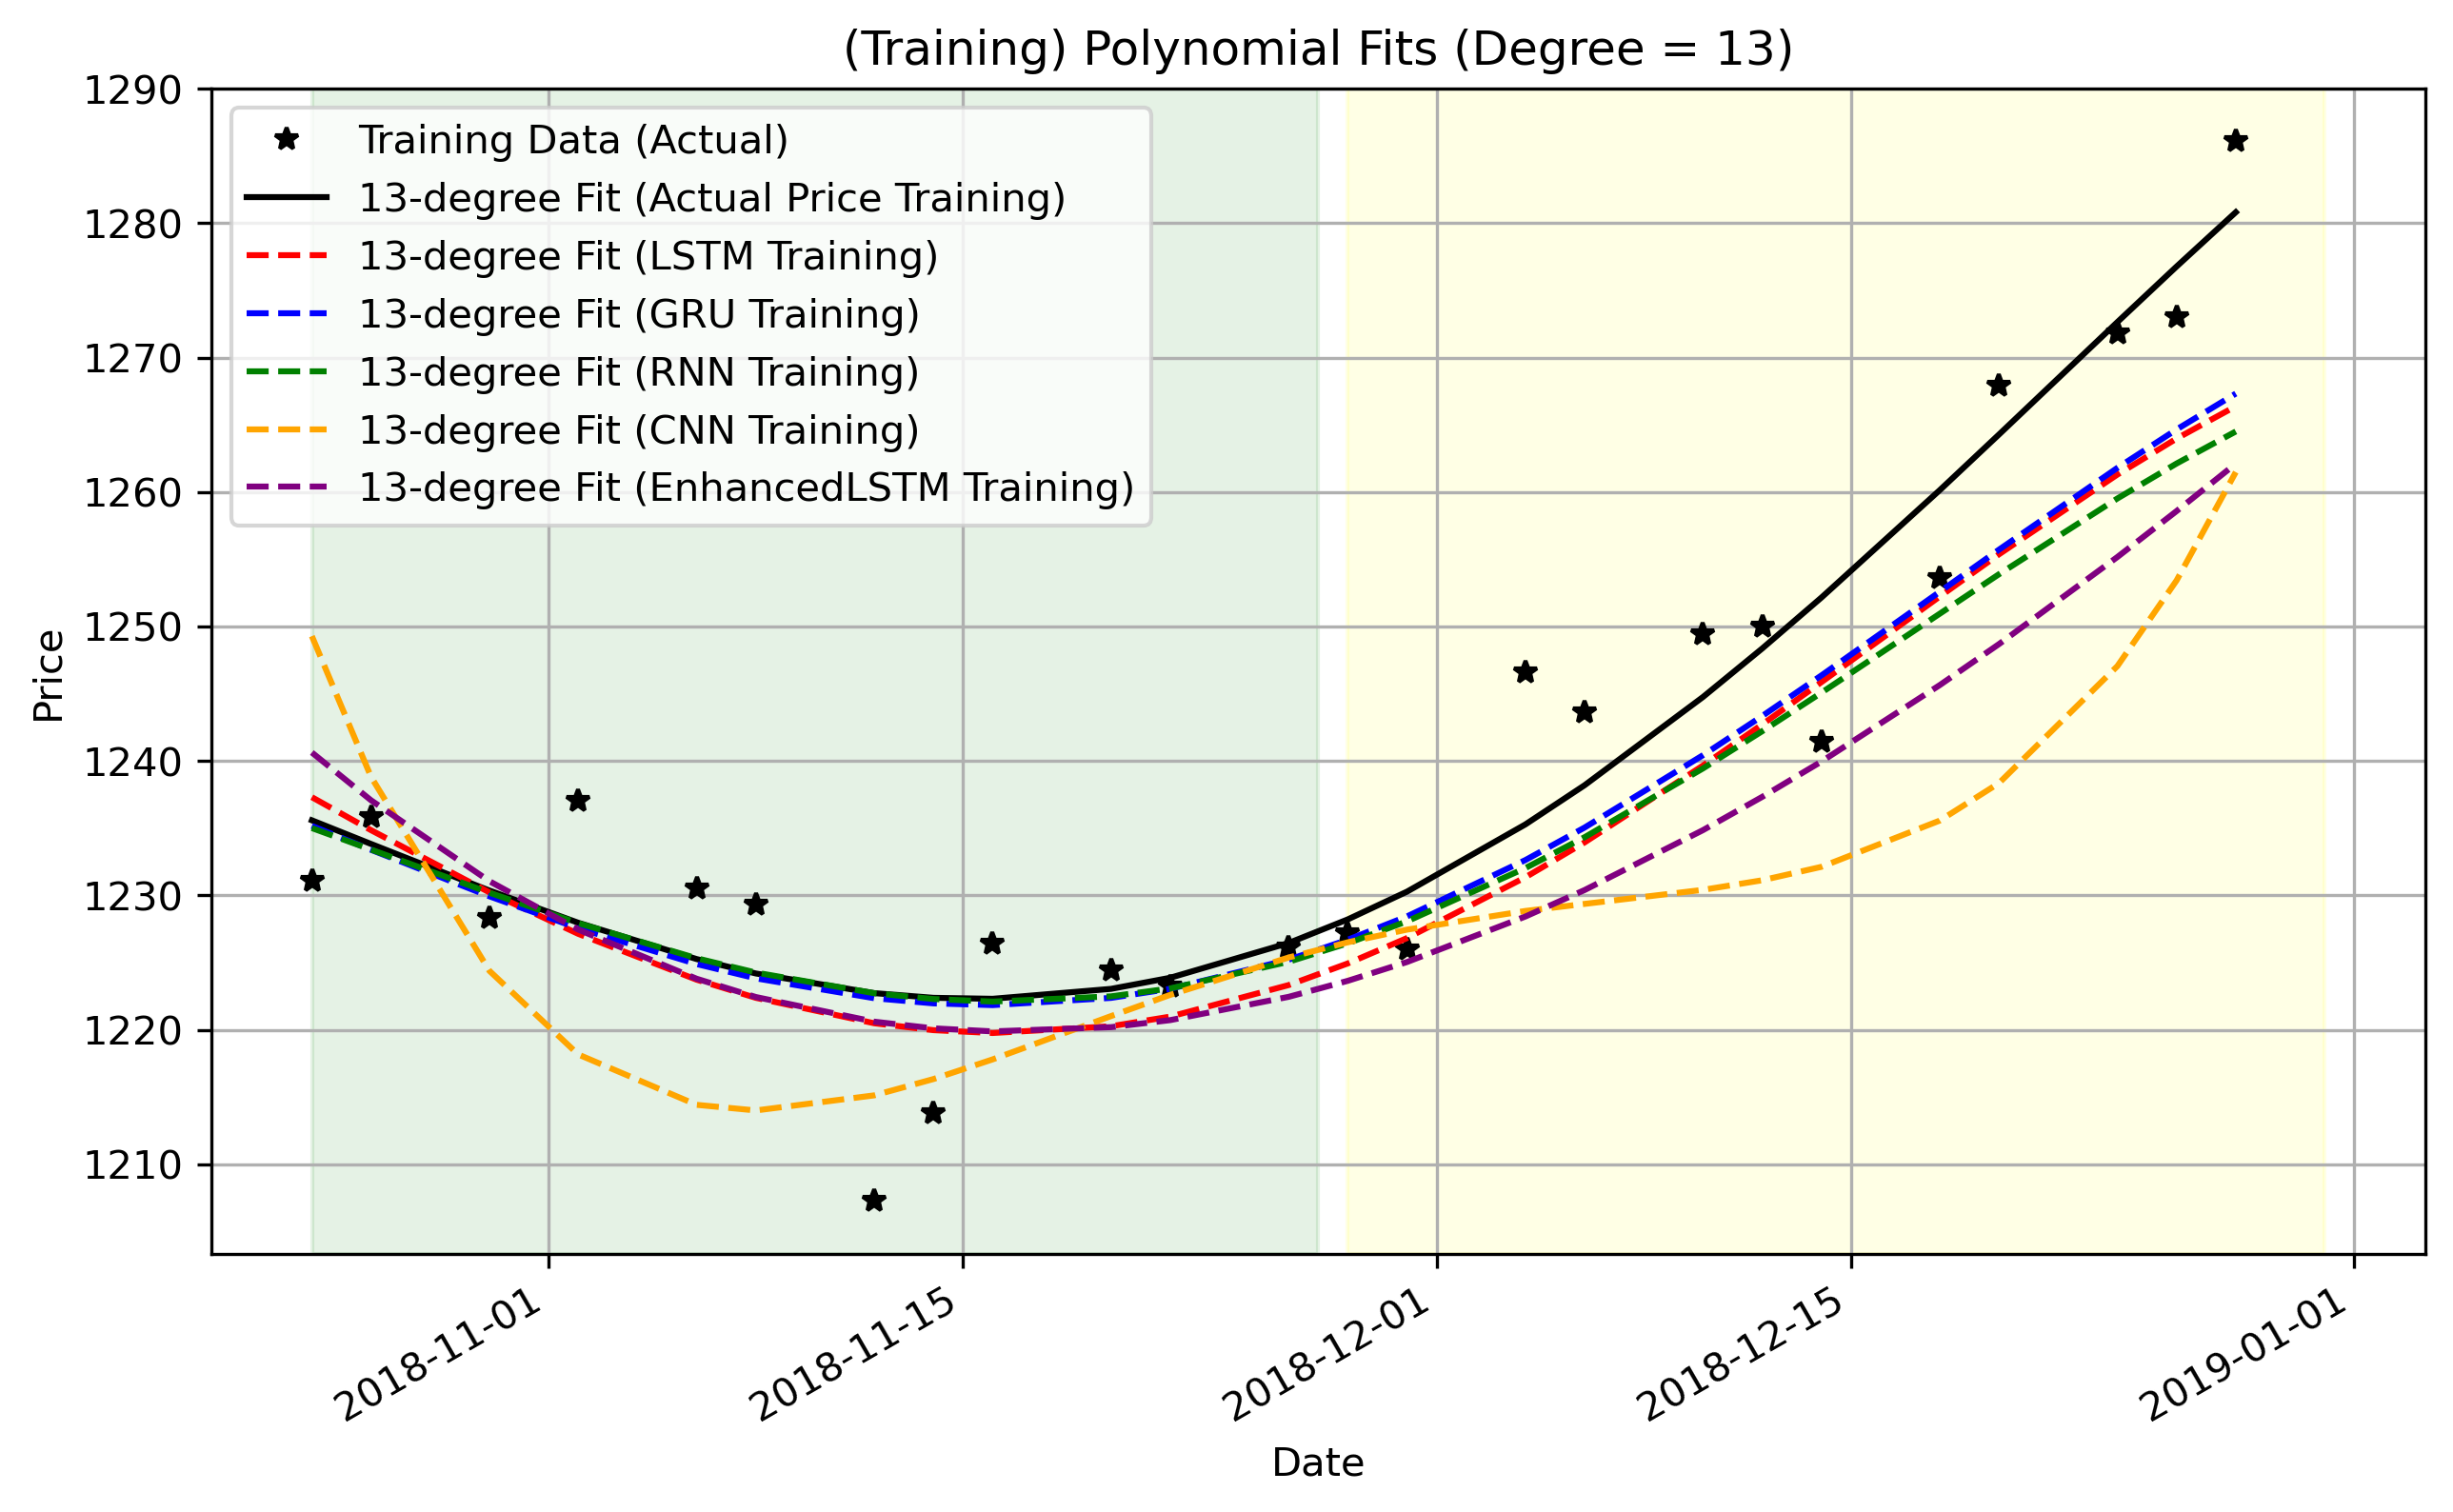

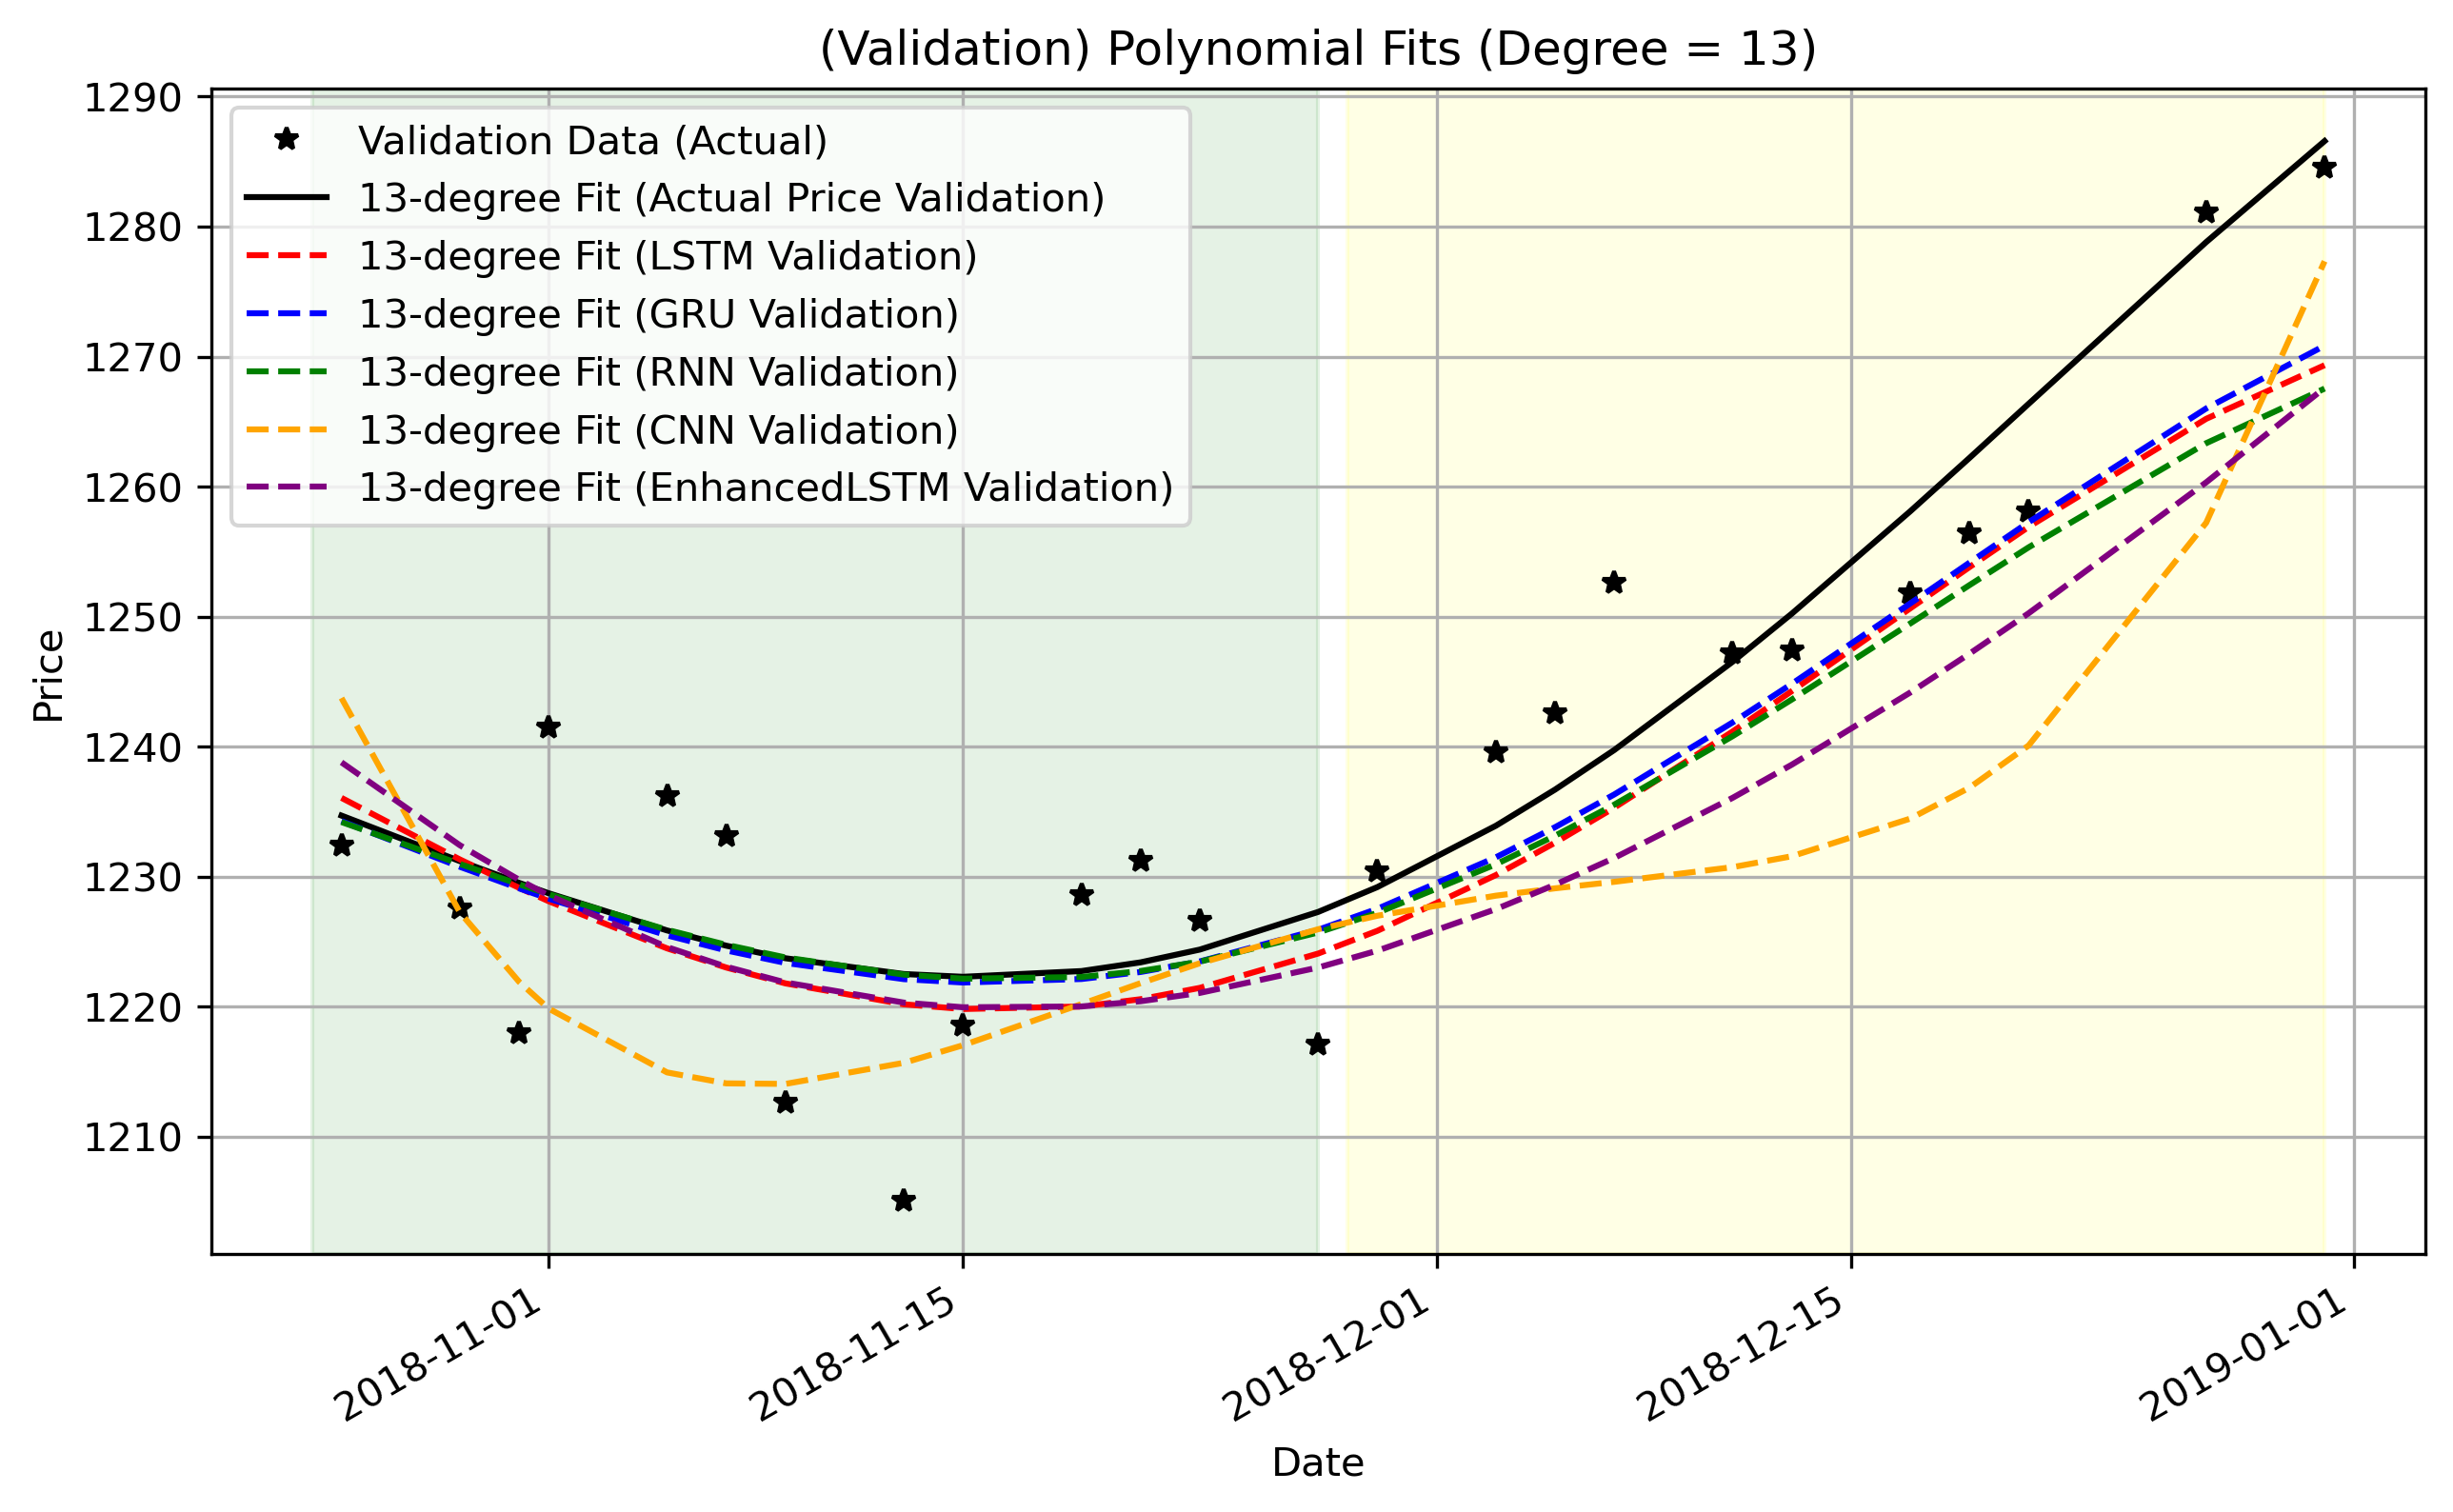


Degree 13 Polynomial Expressions:
----------------------------------------
Actual Price: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0013x^3 + 34.4265x^2 + 358941.2085x - 11893602958.9345
LSTM: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0014x^3 + 37.1399x^2 + 387502.2388x - 12824090835.4343
GRU: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0013x^3 + 33.8339x^2 + 352885.0365x - 11685717237.9590
RNN: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0014x^3 + 36.4376x^2 + 380009.8398x - 12585859312.1819
CNN: y = 0.0000x^13 - 0.0000x^12 - 0.0000x^11 - 0.0000x^10 - 0.0000x^9 + 0.0000x^8 + 0.0000x^7 + 0.0000x^6 + 0.0000x^5 - 0.0000x^4 - 0.0082x^3 - 209.2

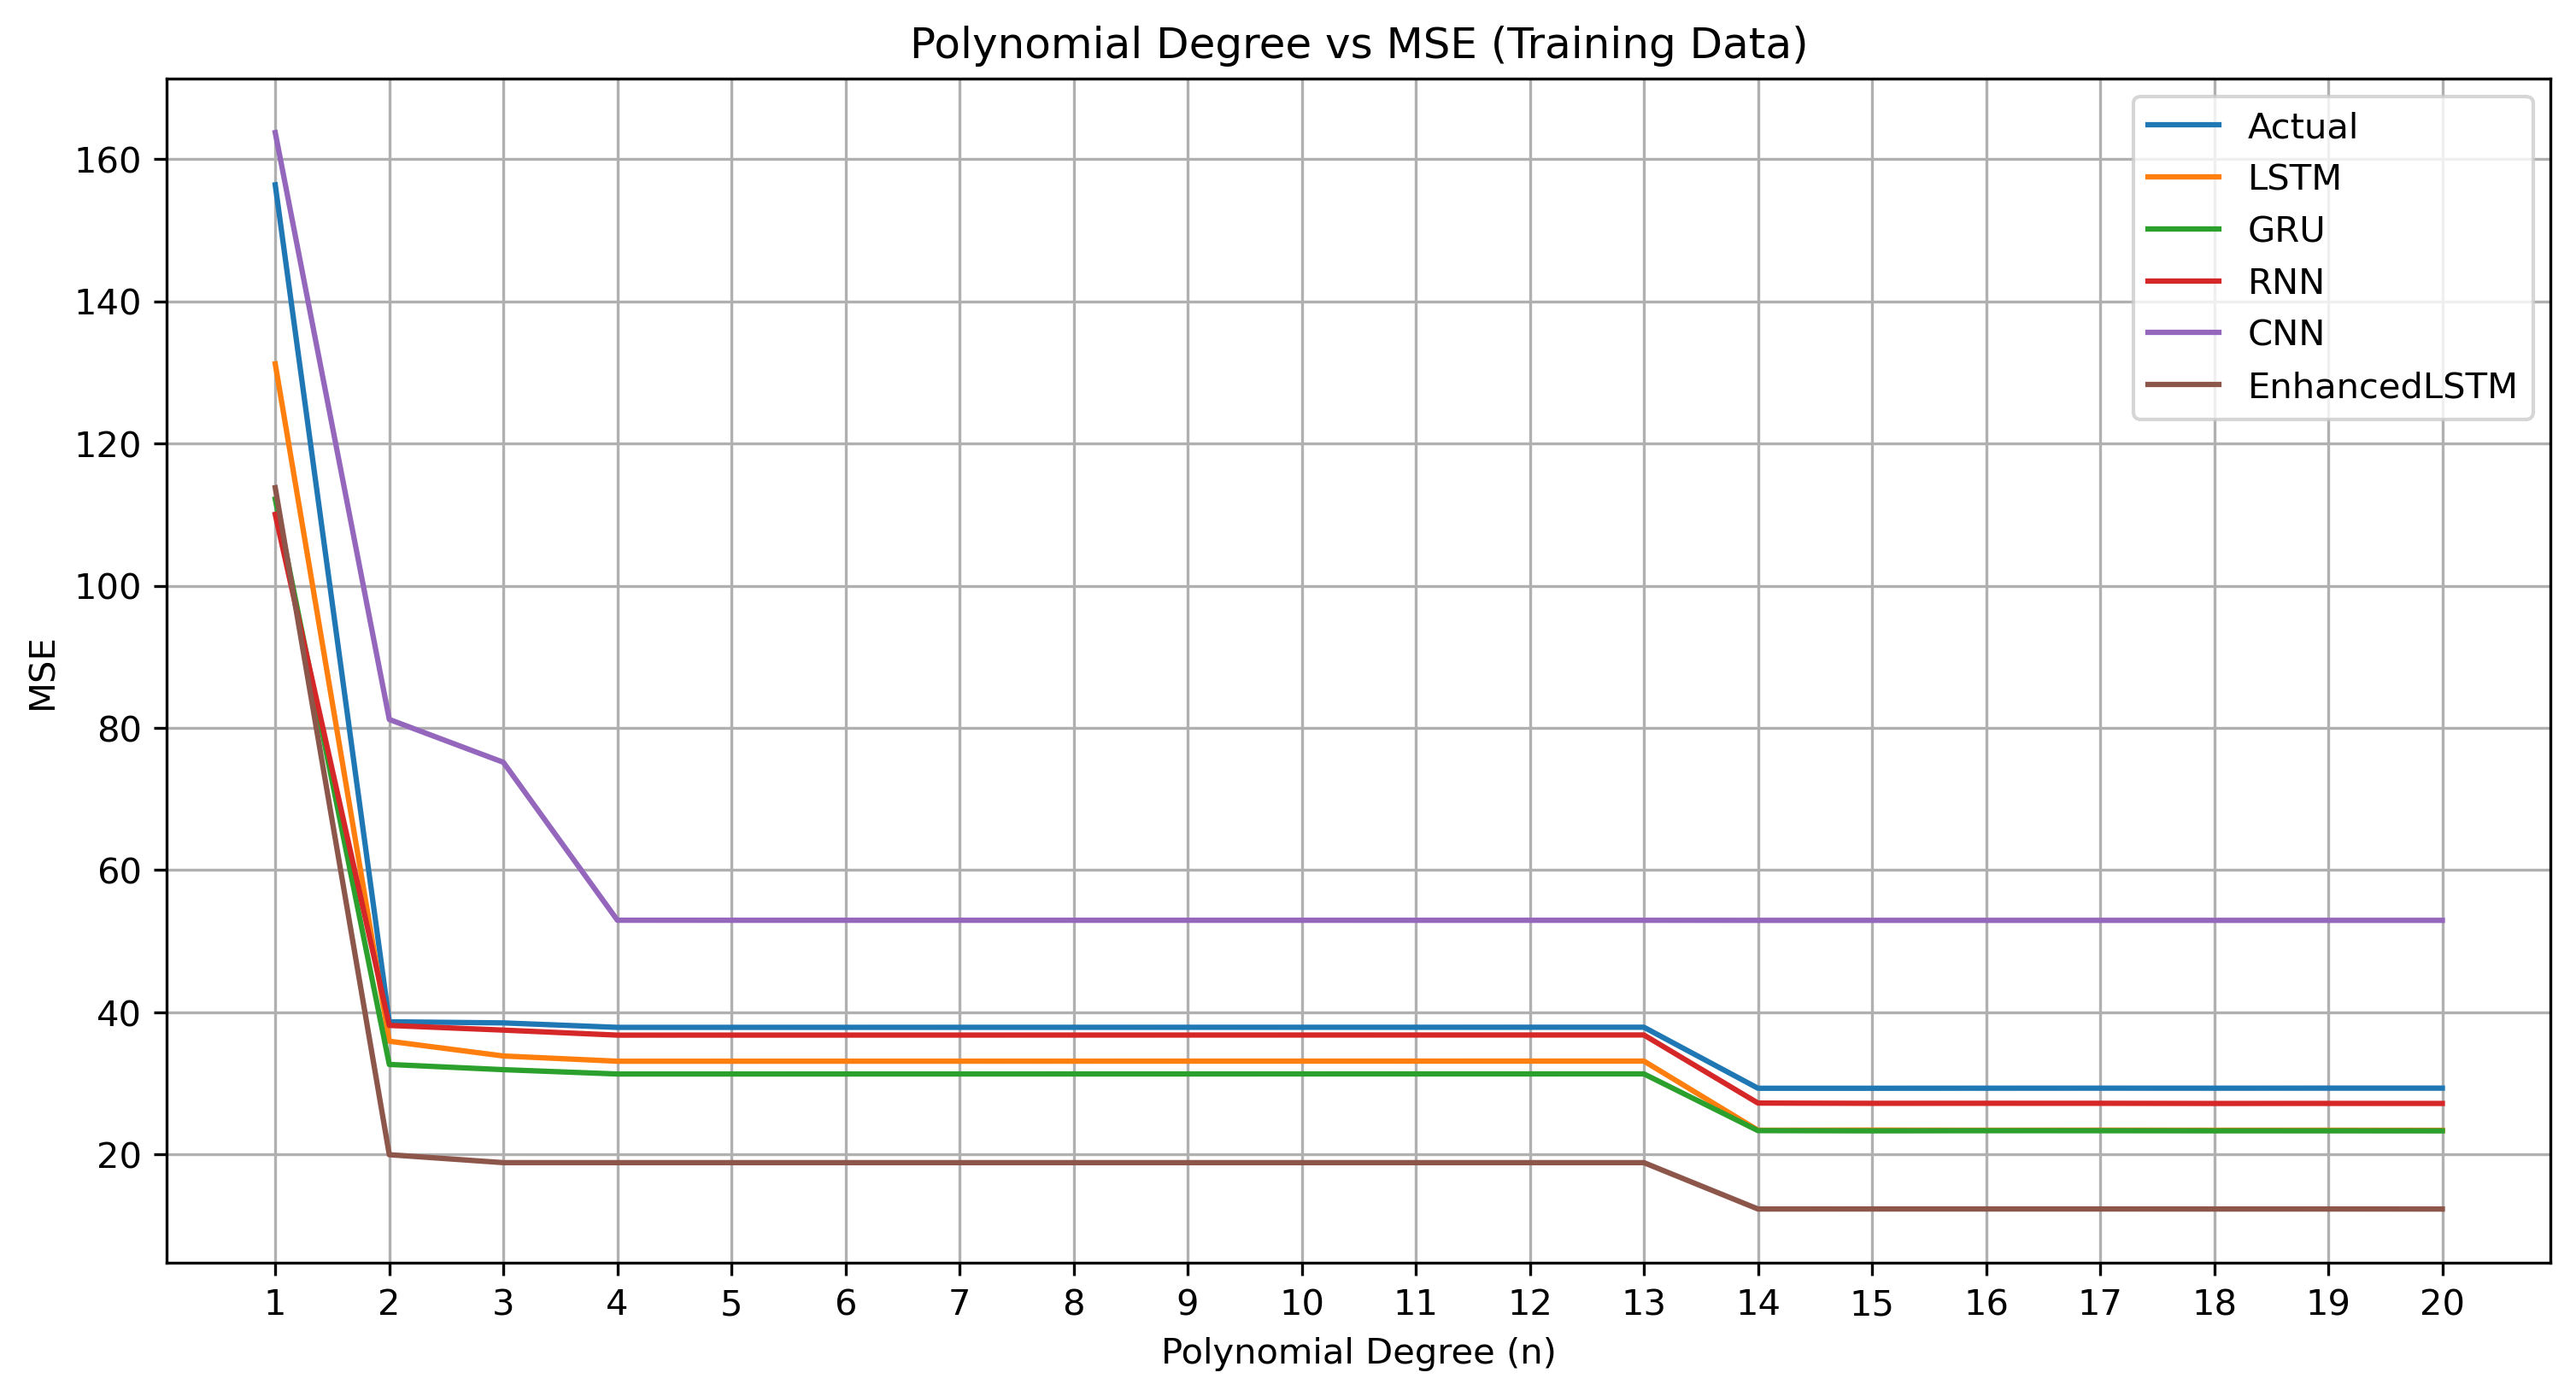

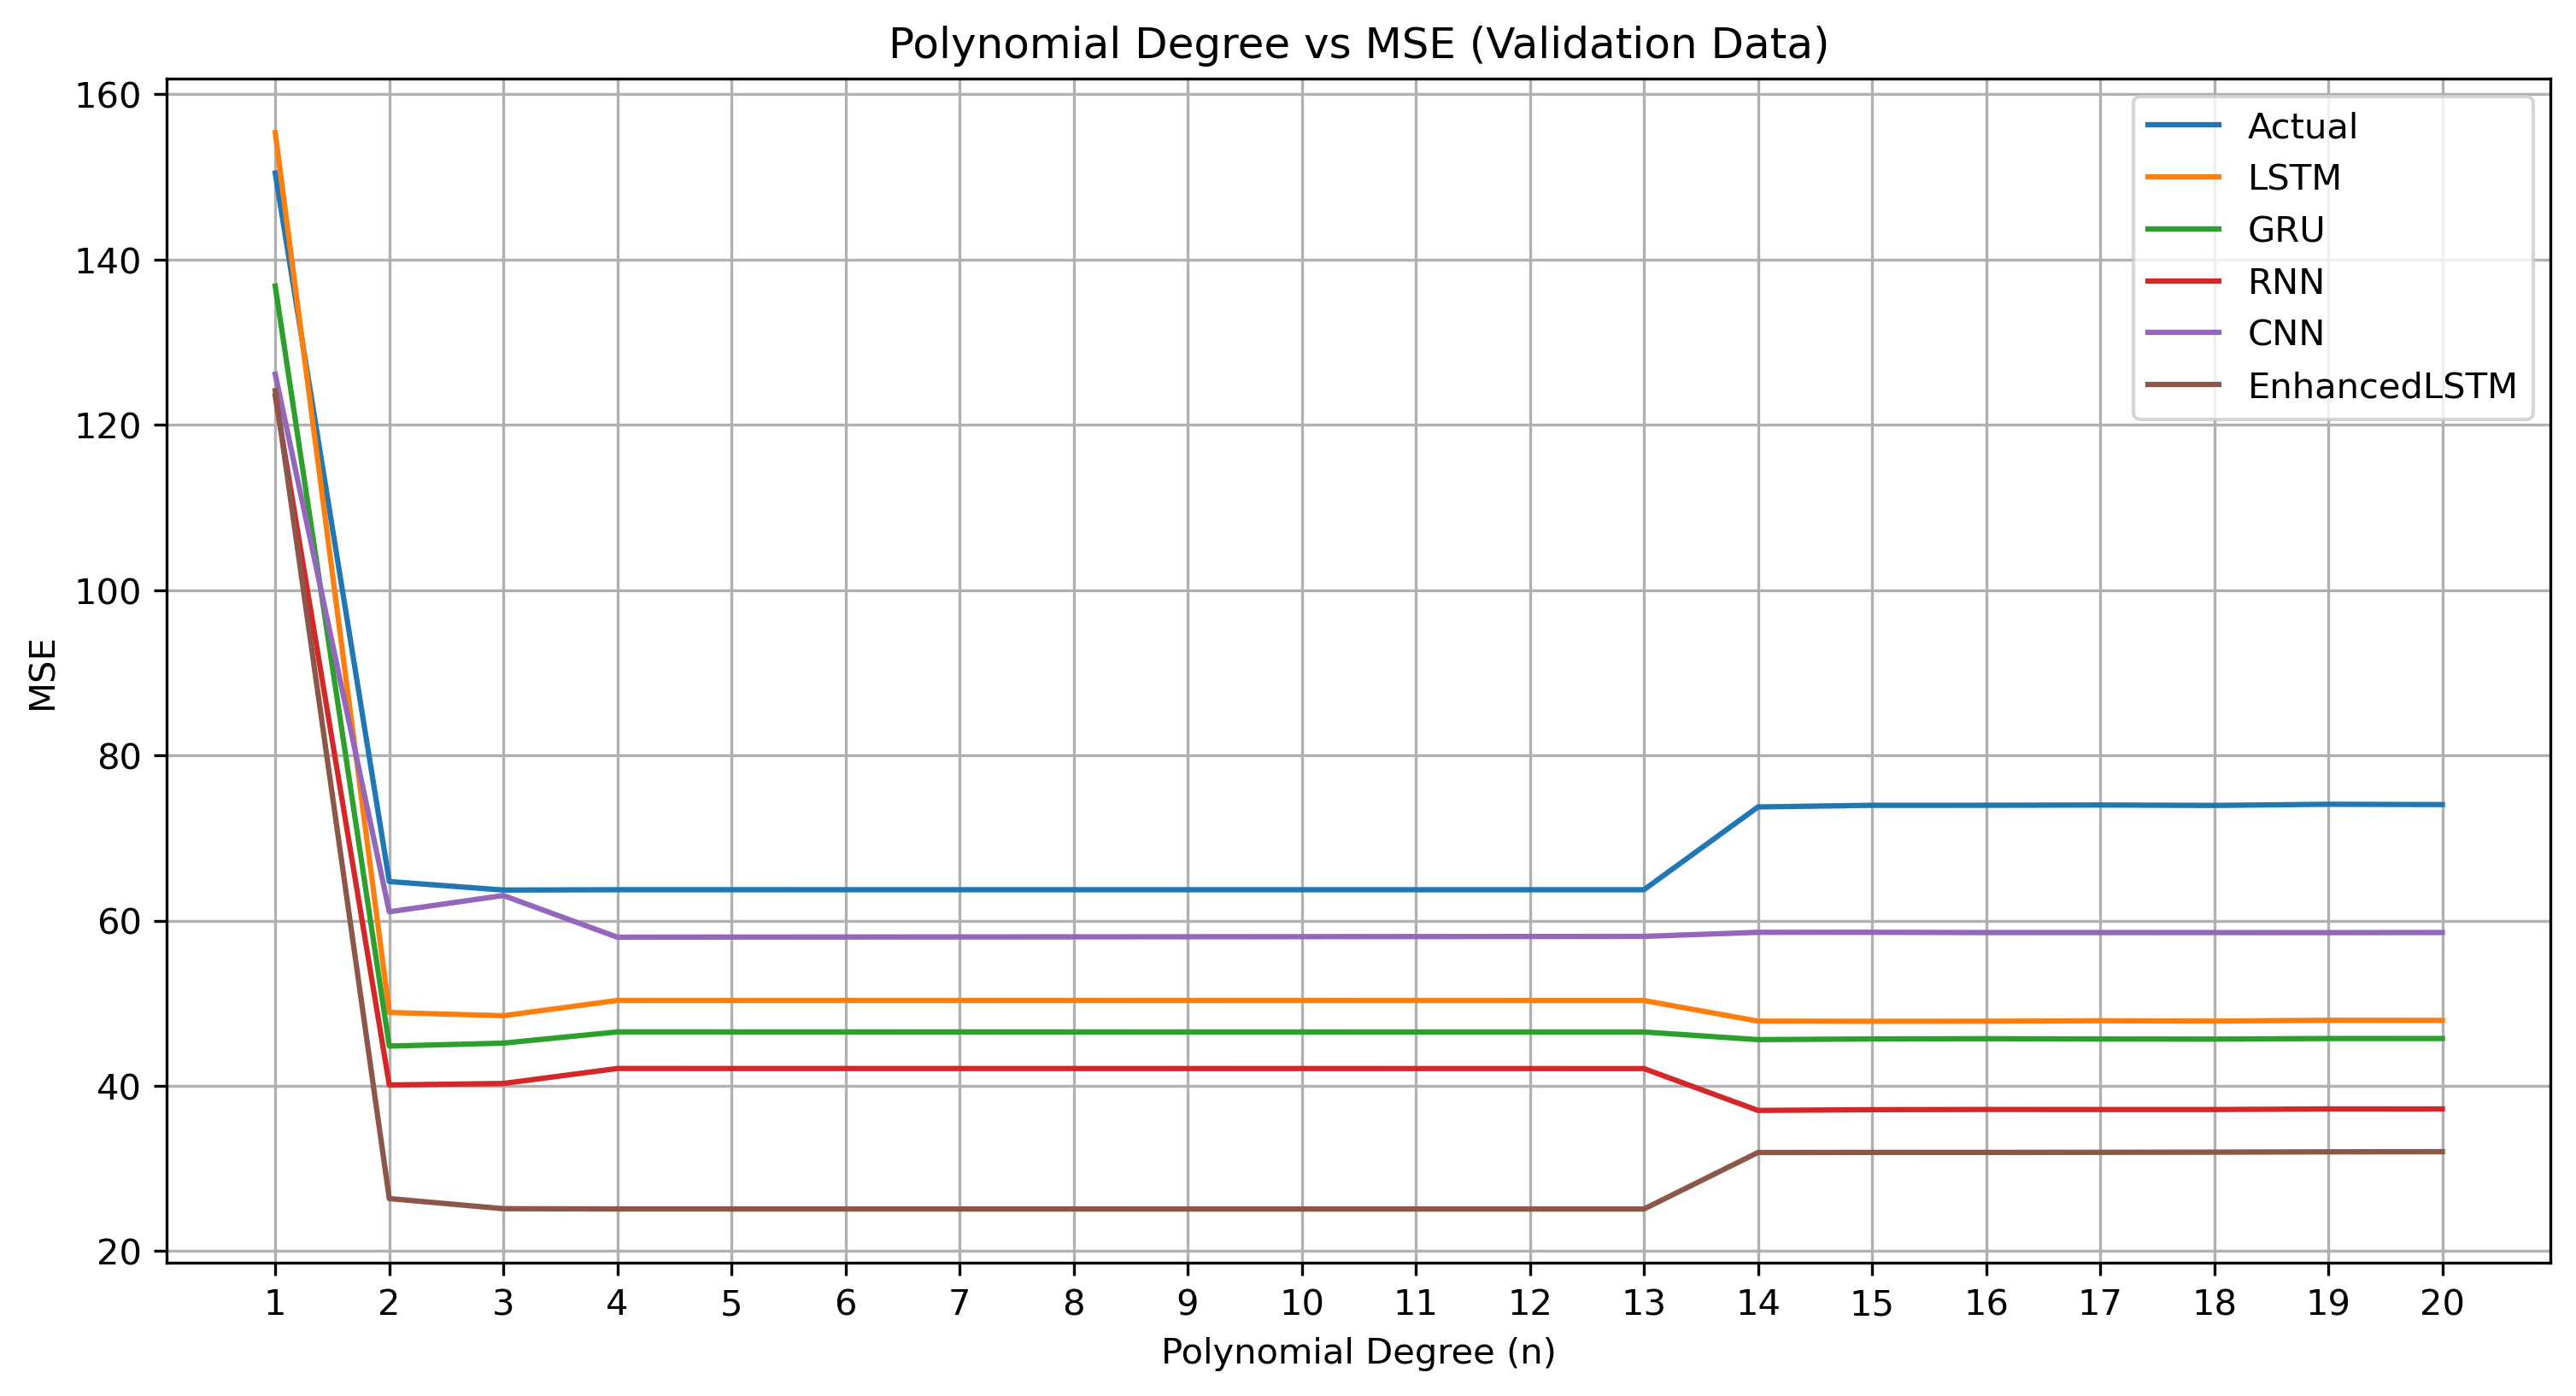

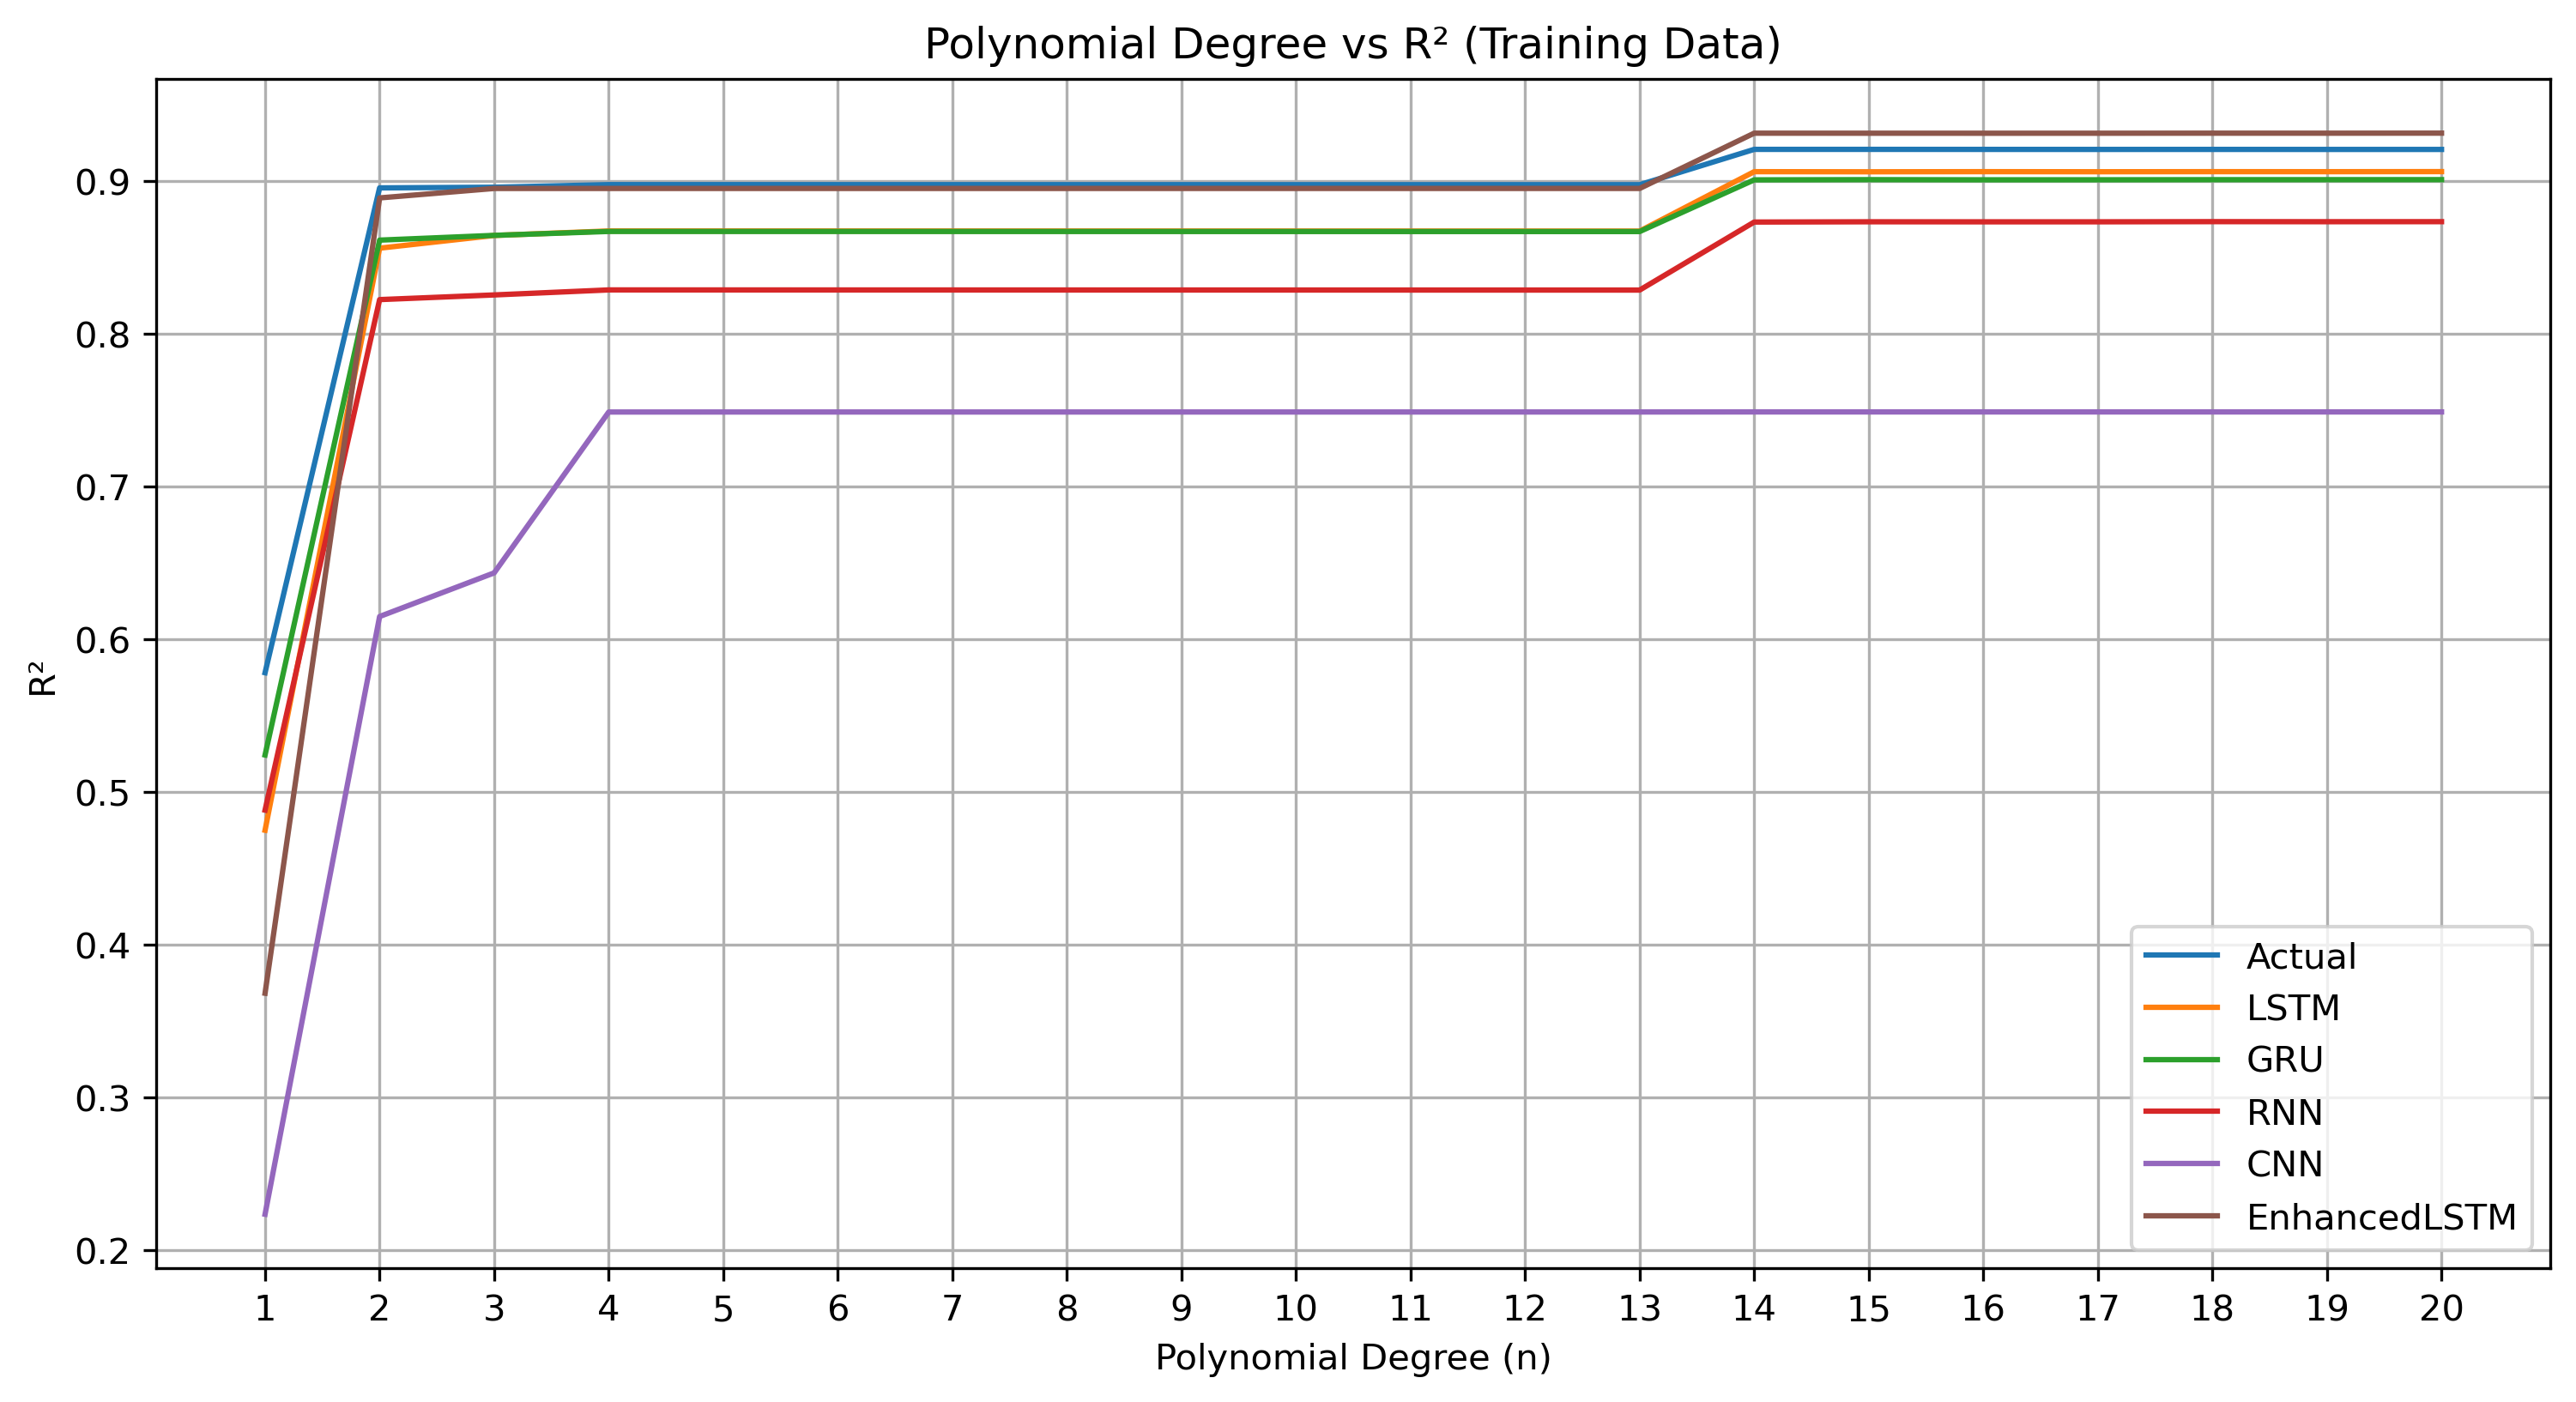

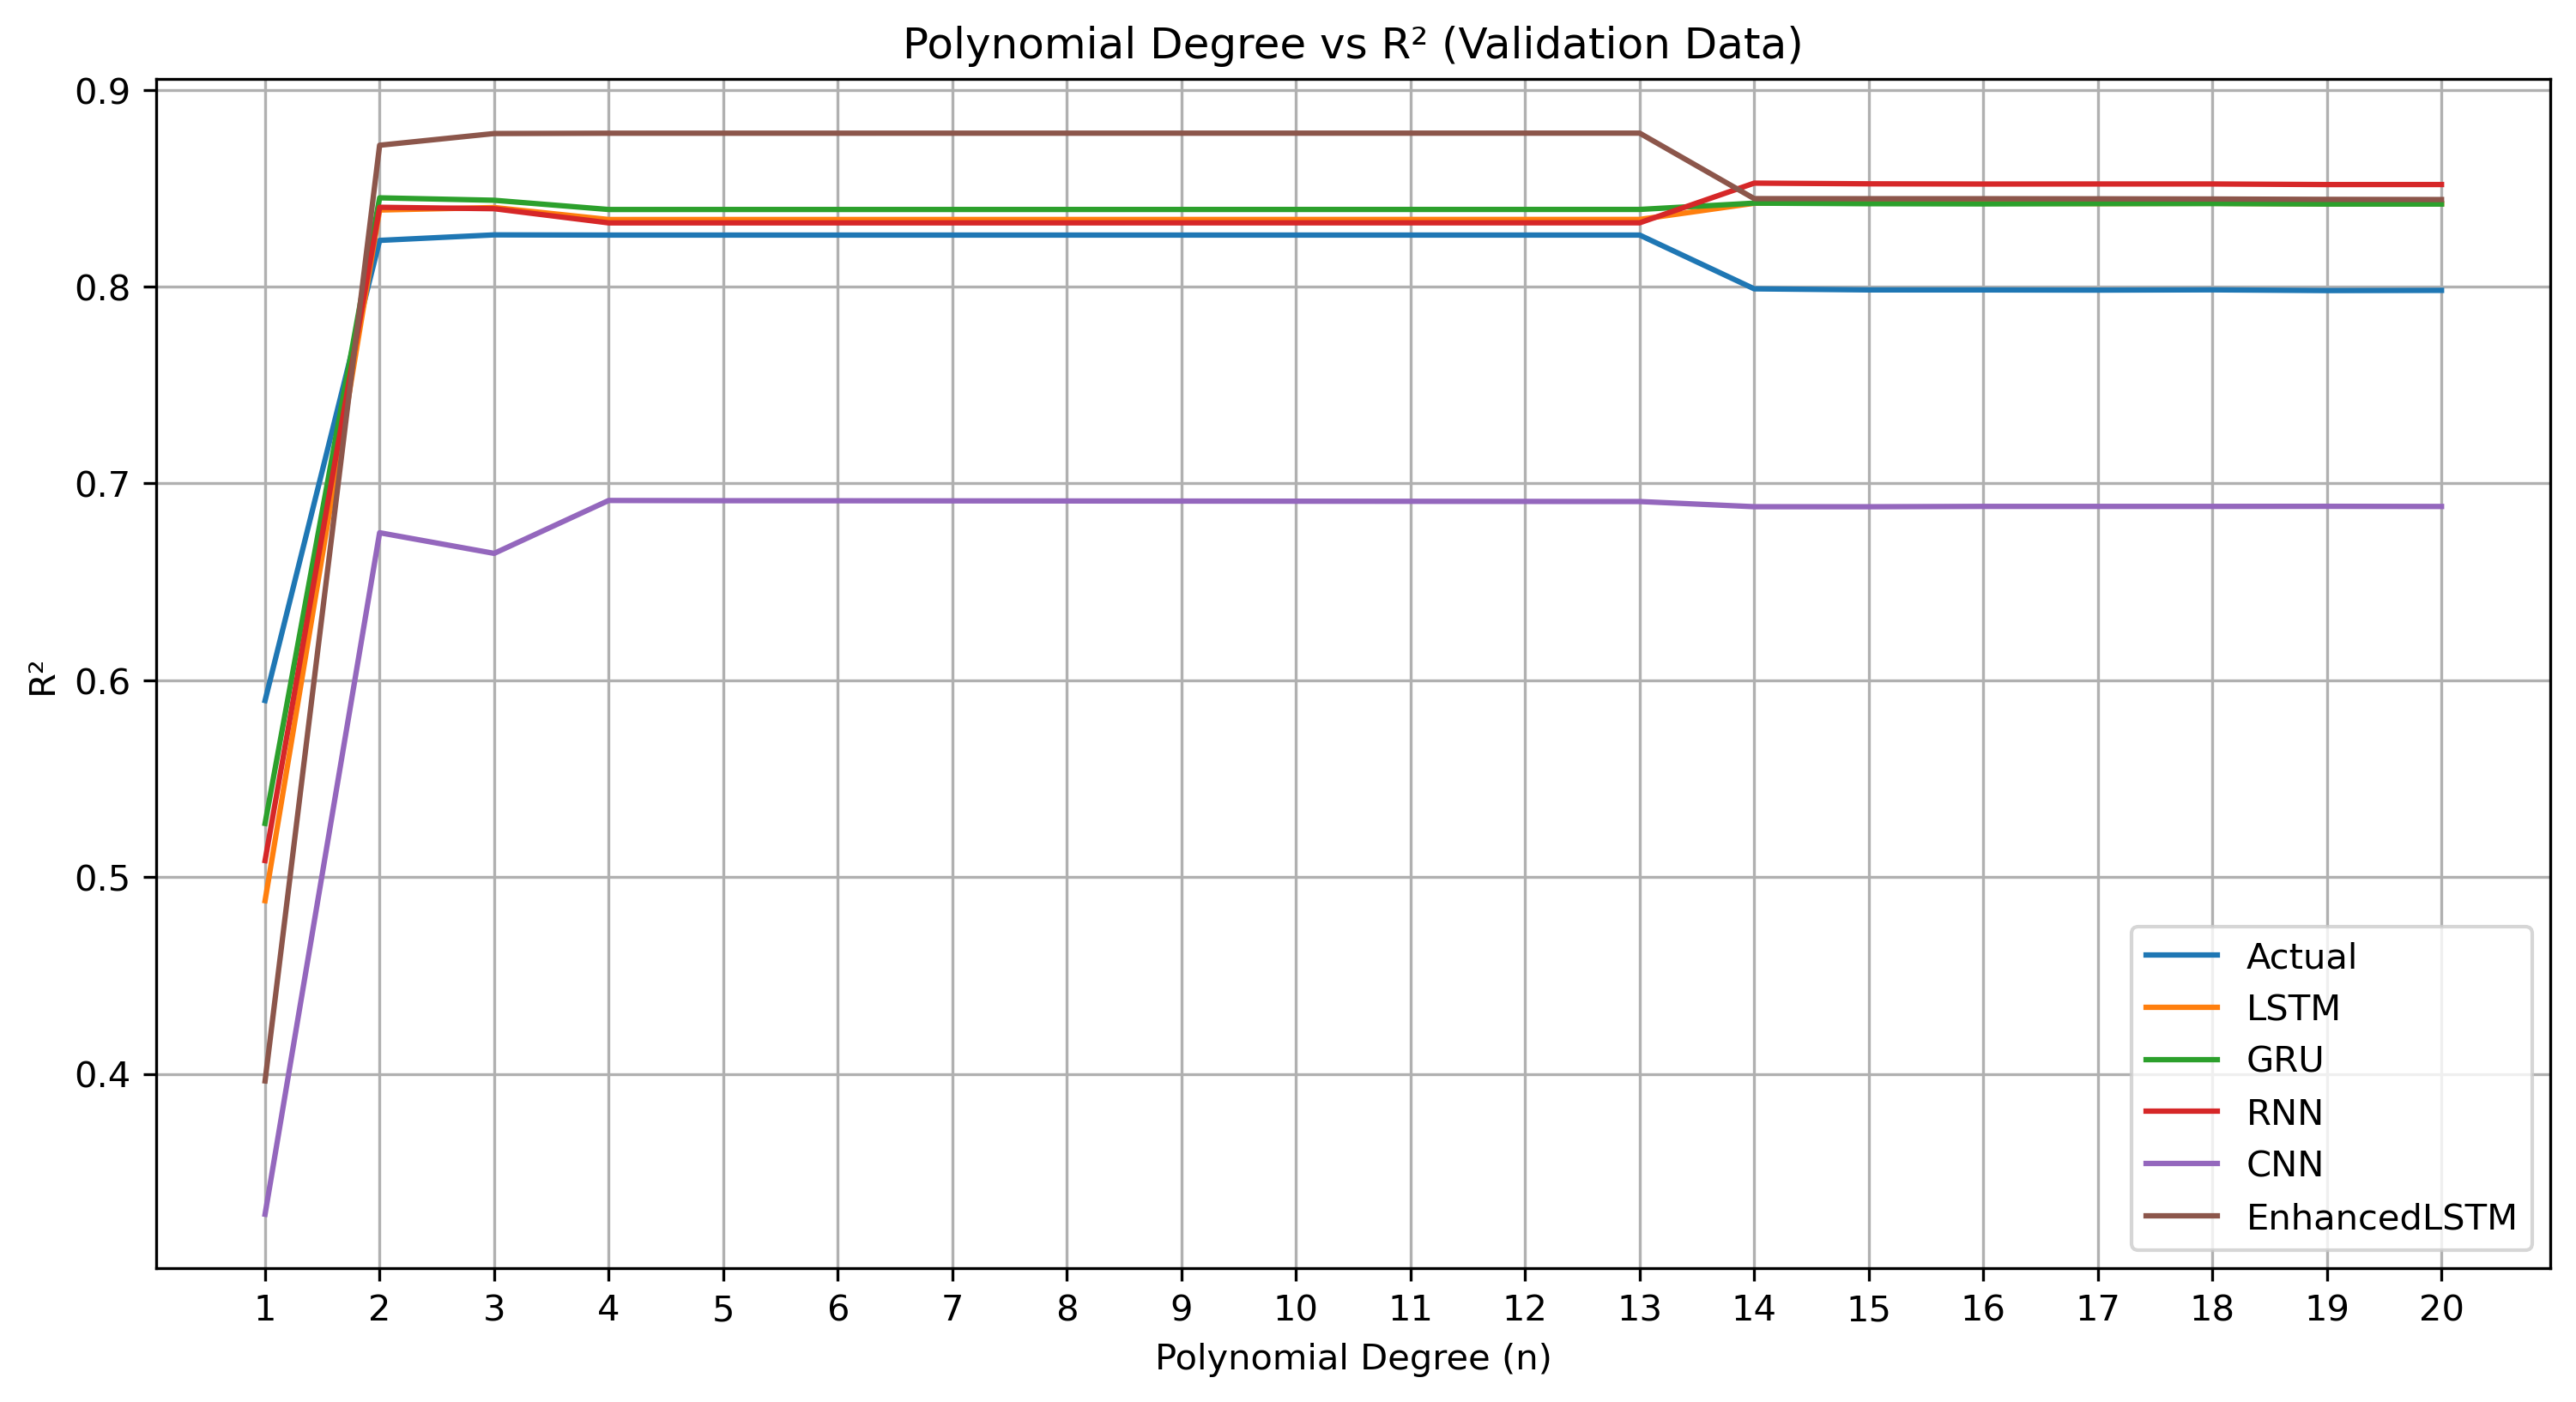

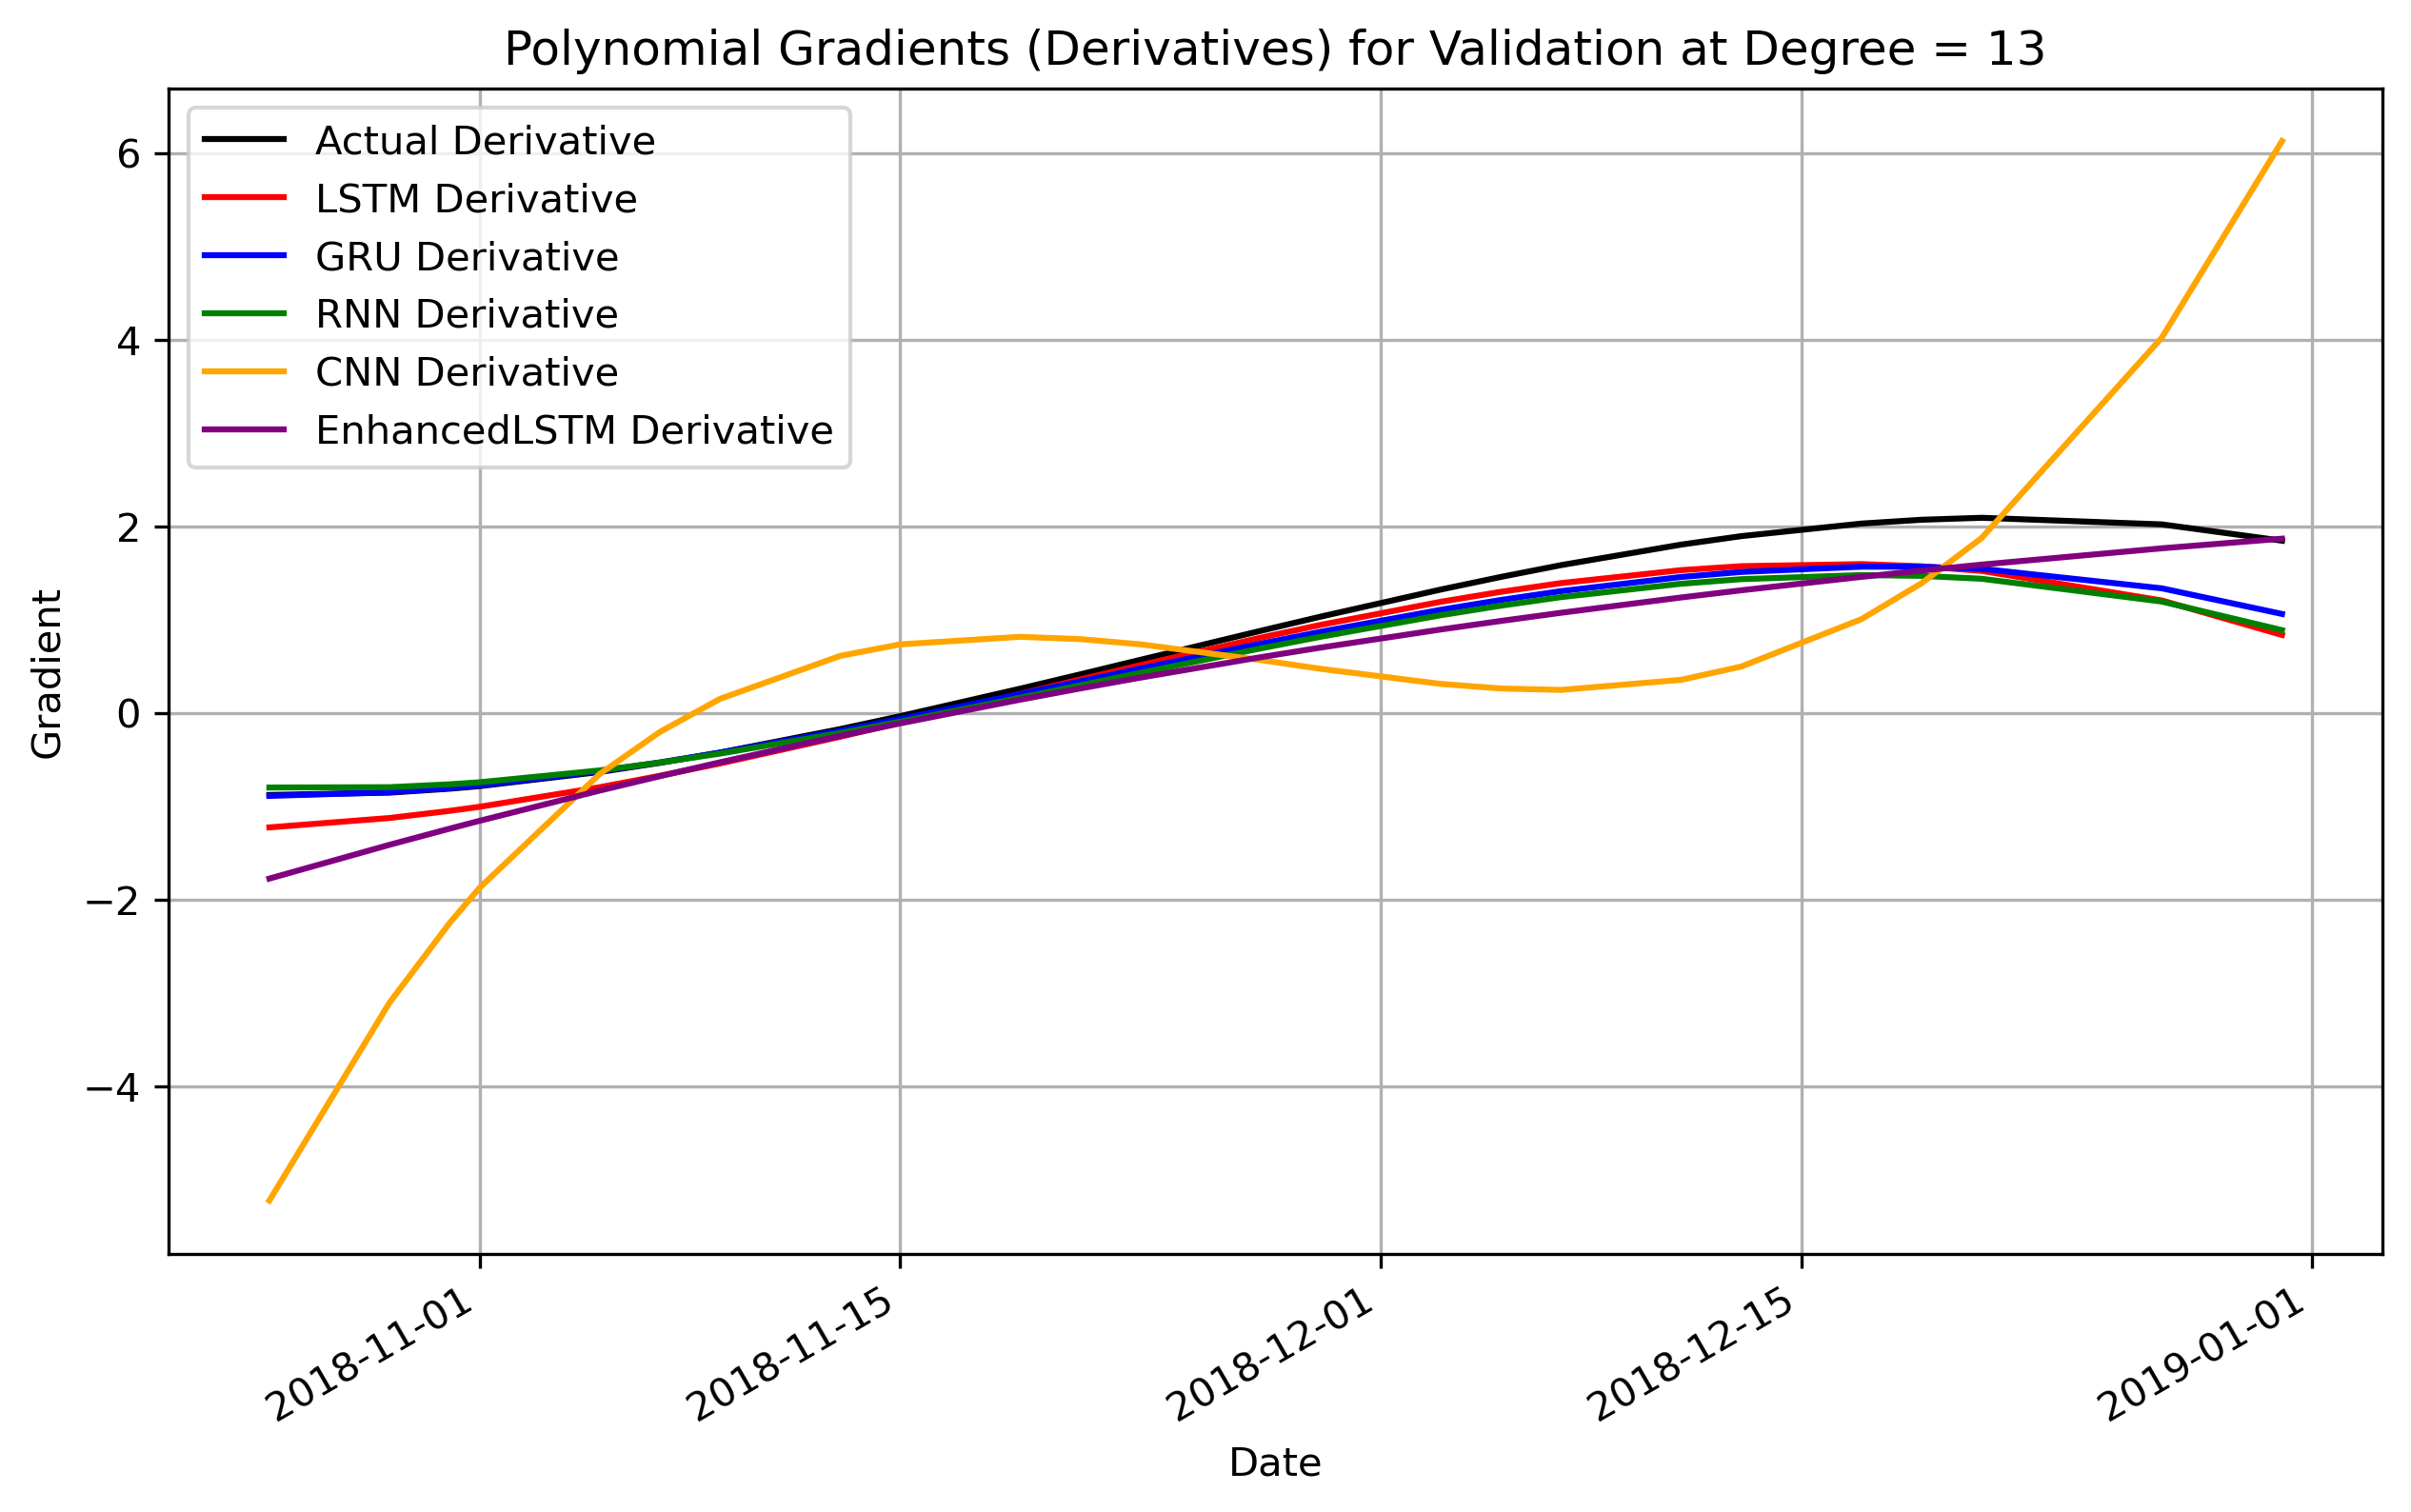


Derivative Polynomials (Degree = 12) for Validation Data at n=13:
------------------------------------------------------------
Actual Price Derivative: dy/dx = -0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 + 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 - 0.0000x^4 + 0.0000x^3 + 0.0040x^2 + 68.8530x + 358941.2085
LSTM Derivative: dy/dx = -0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 + 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 - 0.0000x^4 + 0.0000x^3 + 0.0043x^2 + 74.2799x + 387502.2388
GRU Derivative: dy/dx = -0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 + 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 - 0.0000x^4 + 0.0000x^3 + 0.0040x^2 + 67.6677x + 352885.0365
RNN Derivative: dy/dx = -0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 + 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 - 0.0000x^4 + 0.0000x^3 + 0.0043x^2 + 72.8753x + 380009.8398
CNN Derivative: dy/dx = 0.0000x^12 - 0.0000x^11 - 0.0000x^10 - 0.0000x^9 - 0.0000x^8 + 0.0000x^7 + 0.0000x^6 + 0.0000x^5 + 0.0000x

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------------------------
# Assume the following variables already exist in your code base:
#   val_dates  : array of validation dates (pd.DatetimeIndex or np.array of timestamps)
#   test_dates : array of test dates
#   y_val_inv  : array of actual validation prices (in original scale)
#   y_test_inv : array of actual test prices (in original scale)
#
#   all_results: a dictionary where each key is a model name (e.g. 'LSTM'),
#                and each value is another dict containing:
#       - 'y_val_pred_inv' : validation predictions (in original scale)
#       - 'y_test_pred_inv': test predictions (in original scale)
# ------------------------------------------------

# Combine validation + test data
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Convert datetime objects to numeric for polynomial fitting
date_numeric = mdates.date2num(zoom_dates)

# Define model names and their corresponding colors
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Create masks for training (even days) and validation (odd days)
training_mask = np.array([d.day % 2 == 0 for d in zoom_dates])  # Even day
validation_mask = ~training_mask  # Odd day

# Extract training and validation subsets
zoom_dates_train = zoom_dates[training_mask]
zoom_actual_train = zoom_actual[training_mask]
date_numeric_train = date_numeric[training_mask]

zoom_dates_val = zoom_dates[validation_mask]
zoom_actual_val = zoom_actual[validation_mask]
date_numeric_val = date_numeric[validation_mask]

# Define the range of polynomial degrees to evaluate
poly_degrees = range(1, 70)  # Degrees from 1 to 69

# Initialize variables to track the best validation MSE and R²
lowest_val_mse = float('inf')
highest_val_r2 = float('-inf')

best_val_mse_info = None
best_val_r2_info = None

# -------------------------------------------------
# 1) Find degrees for the lowest Validation MSE
#    and the highest Validation R²
# -------------------------------------------------
for n in poly_degrees:
    # Fit polynomial to ACTUAL (training) -> Evaluate on validation
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
    val_mse_actual = mean_squared_error(zoom_actual_val, poly_actual_val)
    val_r2_actual  = r2_score(zoom_actual_val, poly_actual_val)

    # Check if Actual's validation MSE / R² are best
    if val_mse_actual < lowest_val_mse:
        lowest_val_mse = val_mse_actual
        best_val_mse_info = ("Actual", n, val_mse_actual)

    if val_r2_actual > highest_val_r2:
        highest_val_r2 = val_r2_actual
        best_val_r2_info = ("Actual", n, val_r2_actual)

    # Fit polynomial for each model; check validation MSE / R²
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        model_coeff_train = np.polyfit(date_numeric_train, y_pred_train, n)
        model_poly_val    = np.polyval(model_coeff_train, date_numeric_val)
        val_mse_model     = mean_squared_error(y_pred_val, model_poly_val)
        val_r2_model      = r2_score(y_pred_val, model_poly_val)

        if val_mse_model < lowest_val_mse:
            lowest_val_mse = val_mse_model
            best_val_mse_info = (model_name, n, val_mse_model)

        if val_r2_model > highest_val_r2:
            highest_val_r2 = val_r2_model
            best_val_r2_info = (model_name, n, val_r2_model)

print("Lowest Validation MSE ->", best_val_mse_info)
print("Highest Validation R²   ->", best_val_r2_info)

# -------------------------------------------------
# 2) Plot only those degrees (maybe 1 or 2 if distinct)
# -------------------------------------------------
if best_val_mse_info and best_val_r2_info:
    degrees_to_plot = set([best_val_mse_info[1], best_val_r2_info[1]])  # { degreeForMse, degreeForR2 }

    for n in degrees_to_plot:
        # ----------------
        # Plot Training
        # ----------------
        plt.figure(figsize=(10,6), dpi=300)
        # Actual
        plt.plot(zoom_dates_train, zoom_actual_train, 'k*', label='Training Data (Actual)')
        coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
        poly_actual_train = np.polyval(coeff_actual_train, date_numeric_train)
        plt.plot(zoom_dates_train, poly_actual_train, color='black',
                 label=f'{n}-degree Fit (Actual Price Training)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_train = np.polyval(coeff_pred_train, date_numeric_train)
            plt.plot(zoom_dates_train, poly_pred_train,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Training)')

        plt.title(f'(Training) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()
        plt.pause(0.1)

        # ----------------
        # Plot Validation
        # ----------------
        plt.figure(figsize=(10,6), dpi=300)
        # Actual
        plt.plot(zoom_dates_val, zoom_actual_val, 'k*', label='Validation Data (Actual)')
        poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
        plt.plot(zoom_dates_val, poly_actual_val, color='black',
                 label=f'{n}-degree Fit (Actual Price Validation)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_val = np.polyval(coeff_pred_train, date_numeric_val)
            plt.plot(zoom_dates_val, poly_pred_val,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Validation)')

        plt.title(f'(Validation) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()
        plt.pause(0.1)

def format_polynomial(coeffs):
    """
    Formats polynomial coefficients into a readable mathematical expression.
    
    Args:
        coeffs (array-like): Polynomial coefficients, highest degree first.
        
    Returns:
        str: Formatted polynomial expression.
    """
    terms = []
    degree = len(coeffs) - 1
    for i, coef in enumerate(coeffs):
        power = degree - i
        if coef != 0:
            # Format coefficient
            if coef < 0:
                sign = " - " if i != 0 else "-"
                coef = abs(coef)
            else:
                sign = " + " if i != 0 else ""
            if power == 0:
                term = f"{sign}{coef:.4f}"
            elif power == 1:
                term = f"{sign}{coef:.4f}x"
            else:
                term = f"{sign}{coef:.4f}x^{power}"
            terms.append(term)
    return "".join(terms) if terms else "0"

# ------------------------------------------------
# 3) Print Mathematical Expressions for Best Degrees
# ------------------------------------------------
# Extract the best degrees for Validation MSE and Validation R²
degrees_to_plot_expressions = set()
if best_val_mse_info:
    degrees_to_plot_expressions.add(best_val_mse_info[1])
if best_val_r2_info:
    degrees_to_plot_expressions.add(best_val_r2_info[1])

for n in degrees_to_plot_expressions:
    print(f"\nDegree {n} Polynomial Expressions:\n{'-'*40}")
    
    # ----------------------------
    # Actual Price Polynomial
    # ----------------------------
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    expr_actual = format_polynomial(coeff_actual_train)
    print(f"Actual Price: y = {expr_actual}")
    
    # ----------------------------
    # Machine Learning Models Polynomials
    # ----------------------------
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        
        coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
        expr_model = format_polynomial(coeff_pred_train)
        print(f"{model_name}: y = {expr_model}")

# -------------------------------------------------
# 4) Plot MSE and R² vs Polynomial Degree (n = 1 to 20)
#    with Focused Y-Axis Scaling
# -------------------------------------------------

# Redefine max_degree for plotting purposes
plot_max_degree = 20
models_plus_actual = ['Actual'] + model_names  # "Actual" + your ML models

# Initialize dictionaries to store MSE/R² arrays for plotting
train_mse_dict = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_mse_dict   = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
train_r2_dict  = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_r2_dict    = {m: np.zeros(plot_max_degree) for m in models_plus_actual}

# Loop over degrees 1..20
for n in range(1, plot_max_degree+1):
    idx = n - 1  # array index

    # ------------------
    # A) Actual Price
    # ------------------
    coeff_actual = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_train_actual = np.polyval(coeff_actual, date_numeric_train)
    poly_val_actual   = np.polyval(coeff_actual, date_numeric_val)

    # Compute training metrics
    train_mse_dict['Actual'][idx] = mean_squared_error(zoom_actual_train, poly_train_actual)
    train_r2_dict['Actual'][idx]  = r2_score(zoom_actual_train, poly_train_actual)

    # Compute validation metrics
    val_mse_dict['Actual'][idx] = mean_squared_error(zoom_actual_val, poly_val_actual)
    val_r2_dict['Actual'][idx]  = r2_score(zoom_actual_val, poly_val_actual)

    # ------------------
    # B) Each model
    # ------------------
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        coeff_model = np.polyfit(date_numeric_train, y_pred_train, n)
        poly_train_model = np.polyval(coeff_model, date_numeric_train)
        poly_val_model   = np.polyval(coeff_model, date_numeric_val)

        train_mse_dict[model_name][idx] = mean_squared_error(y_pred_train, poly_train_model)
        train_r2_dict[model_name][idx]  = r2_score(y_pred_train, poly_train_model)

        val_mse_dict[model_name][idx] = mean_squared_error(y_pred_val, poly_val_model)
        val_r2_dict[model_name][idx]  = r2_score(y_pred_val, poly_val_model)

# Define a function to set focused y-axis limits
def set_focused_ylim(data_dict, metric, buffer_ratio=0.05):
    """
    Sets y-axis limits based on the min and max of the provided data with a buffer.

    Args:
        data_dict (dict): Dictionary containing data arrays for different models.
        metric (str): The metric being plotted ('MSE' or 'R²').
        buffer_ratio (float): The ratio of buffer to add to the limits.

    Returns:
        tuple: (ymin, ymax) for plt.ylim()
    """
    all_values = np.concatenate(list(data_dict.values()))
    ymin = np.min(all_values)
    ymax = np.max(all_values)
    buffer = (ymax - ymin) * buffer_ratio
    return ymin - buffer, ymax + buffer

# Define degrees array
degrees = np.arange(1, plot_max_degree + 1)

# --- Training MSE ---
plt.figure(figsize=(12, 6), dpi=300)
plt.title("Polynomial Degree vs MSE (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees, train_mse_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("MSE")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(train_mse_dict, metric='MSE')
plt.ylim(ymin, ymax)
plt.show()

# --- Validation MSE ---
plt.figure(figsize=(12, 6), dpi=300)
plt.title("Polynomial Degree vs MSE (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees, val_mse_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("MSE")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(val_mse_dict, metric='MSE')
plt.ylim(ymin, ymax)
plt.show()

# --- Training R² ---
plt.figure(figsize=(12, 6), dpi=300)
plt.title("Polynomial Degree vs R² (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees, train_r2_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("R²")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(train_r2_dict, metric='R²')
plt.ylim(ymin, ymax)
plt.show()

# --- Validation R² ---
plt.figure(figsize=(12, 6), dpi=300)
plt.title("Polynomial Degree vs R² (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees, val_r2_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("R²")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(val_r2_dict, metric='R²')
plt.ylim(ymin, ymax)
plt.show()

# -------------------------------------------------
# 5) Plot polynomial gradients (derivatives) for Validation Data at Degree = 13
#    and print their mathematical expressions.
# -------------------------------------------------

# Define a helper function for formatting derivative polynomials
def format_polynomial_derivative(coeffs):
    return format_polynomial(coeffs)

degree_for_derivative = 13

# Create a new figure for plotting the gradients
plt.figure(figsize=(10,6), dpi=300)

# Plot the derivative for Actual Price
coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, degree_for_derivative)
deriv_coeff_actual = np.polyder(coeff_actual_train)
val_deriv_actual = np.polyval(deriv_coeff_actual, date_numeric_val)
plt.plot(zoom_dates_val, val_deriv_actual, 'k-', label='Actual Derivative')

# Plot the derivative for each model
for model_name in model_names:
    y_pred_combined = np.concatenate((
        all_results[model_name]['y_val_pred_inv'],
        all_results[model_name]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_combined[training_mask]
    coeff_model_train = np.polyfit(date_numeric_train, y_pred_train, degree_for_derivative)
    deriv_coeff_model = np.polyder(coeff_model_train)
    val_deriv_model = np.polyval(deriv_coeff_model, date_numeric_val)
    plt.plot(zoom_dates_val, val_deriv_model,
             color=model_colors[model_name],
             label=f'{model_name} Derivative')

plt.title(f'Polynomial Gradients (Derivatives) for Validation at Degree = {degree_for_derivative}')
plt.xlabel('Date')
plt.ylabel('Gradient')
plt.grid(True)
plt.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.show()

# Print derivative polynomial expressions
print(f"\nDerivative Polynomials (Degree = {degree_for_derivative - 1}) for Validation Data at n={degree_for_derivative}:\n{'-'*60}")
print(f"Actual Price Derivative: dy/dx = {format_polynomial_derivative(deriv_coeff_actual)}")

for model_name in model_names:
    y_pred_combined = np.concatenate((
        all_results[model_name]['y_val_pred_inv'],
        all_results[model_name]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_combined[training_mask]
    coeff_model_train = np.polyfit(date_numeric_train, y_pred_train, degree_for_derivative)
    deriv_coeff_model = np.polyder(coeff_model_train)
    expr_deriv = format_polynomial_derivative(deriv_coeff_model)
    print(f"{model_name} Derivative: dy/dx = {expr_deriv}")

Lowest Validation MSE -> ('EnhancedLSTM', 13, 25.096264237428453)
Highest Validation R²   -> ('EnhancedLSTM', 13, 0.8779874906194661)


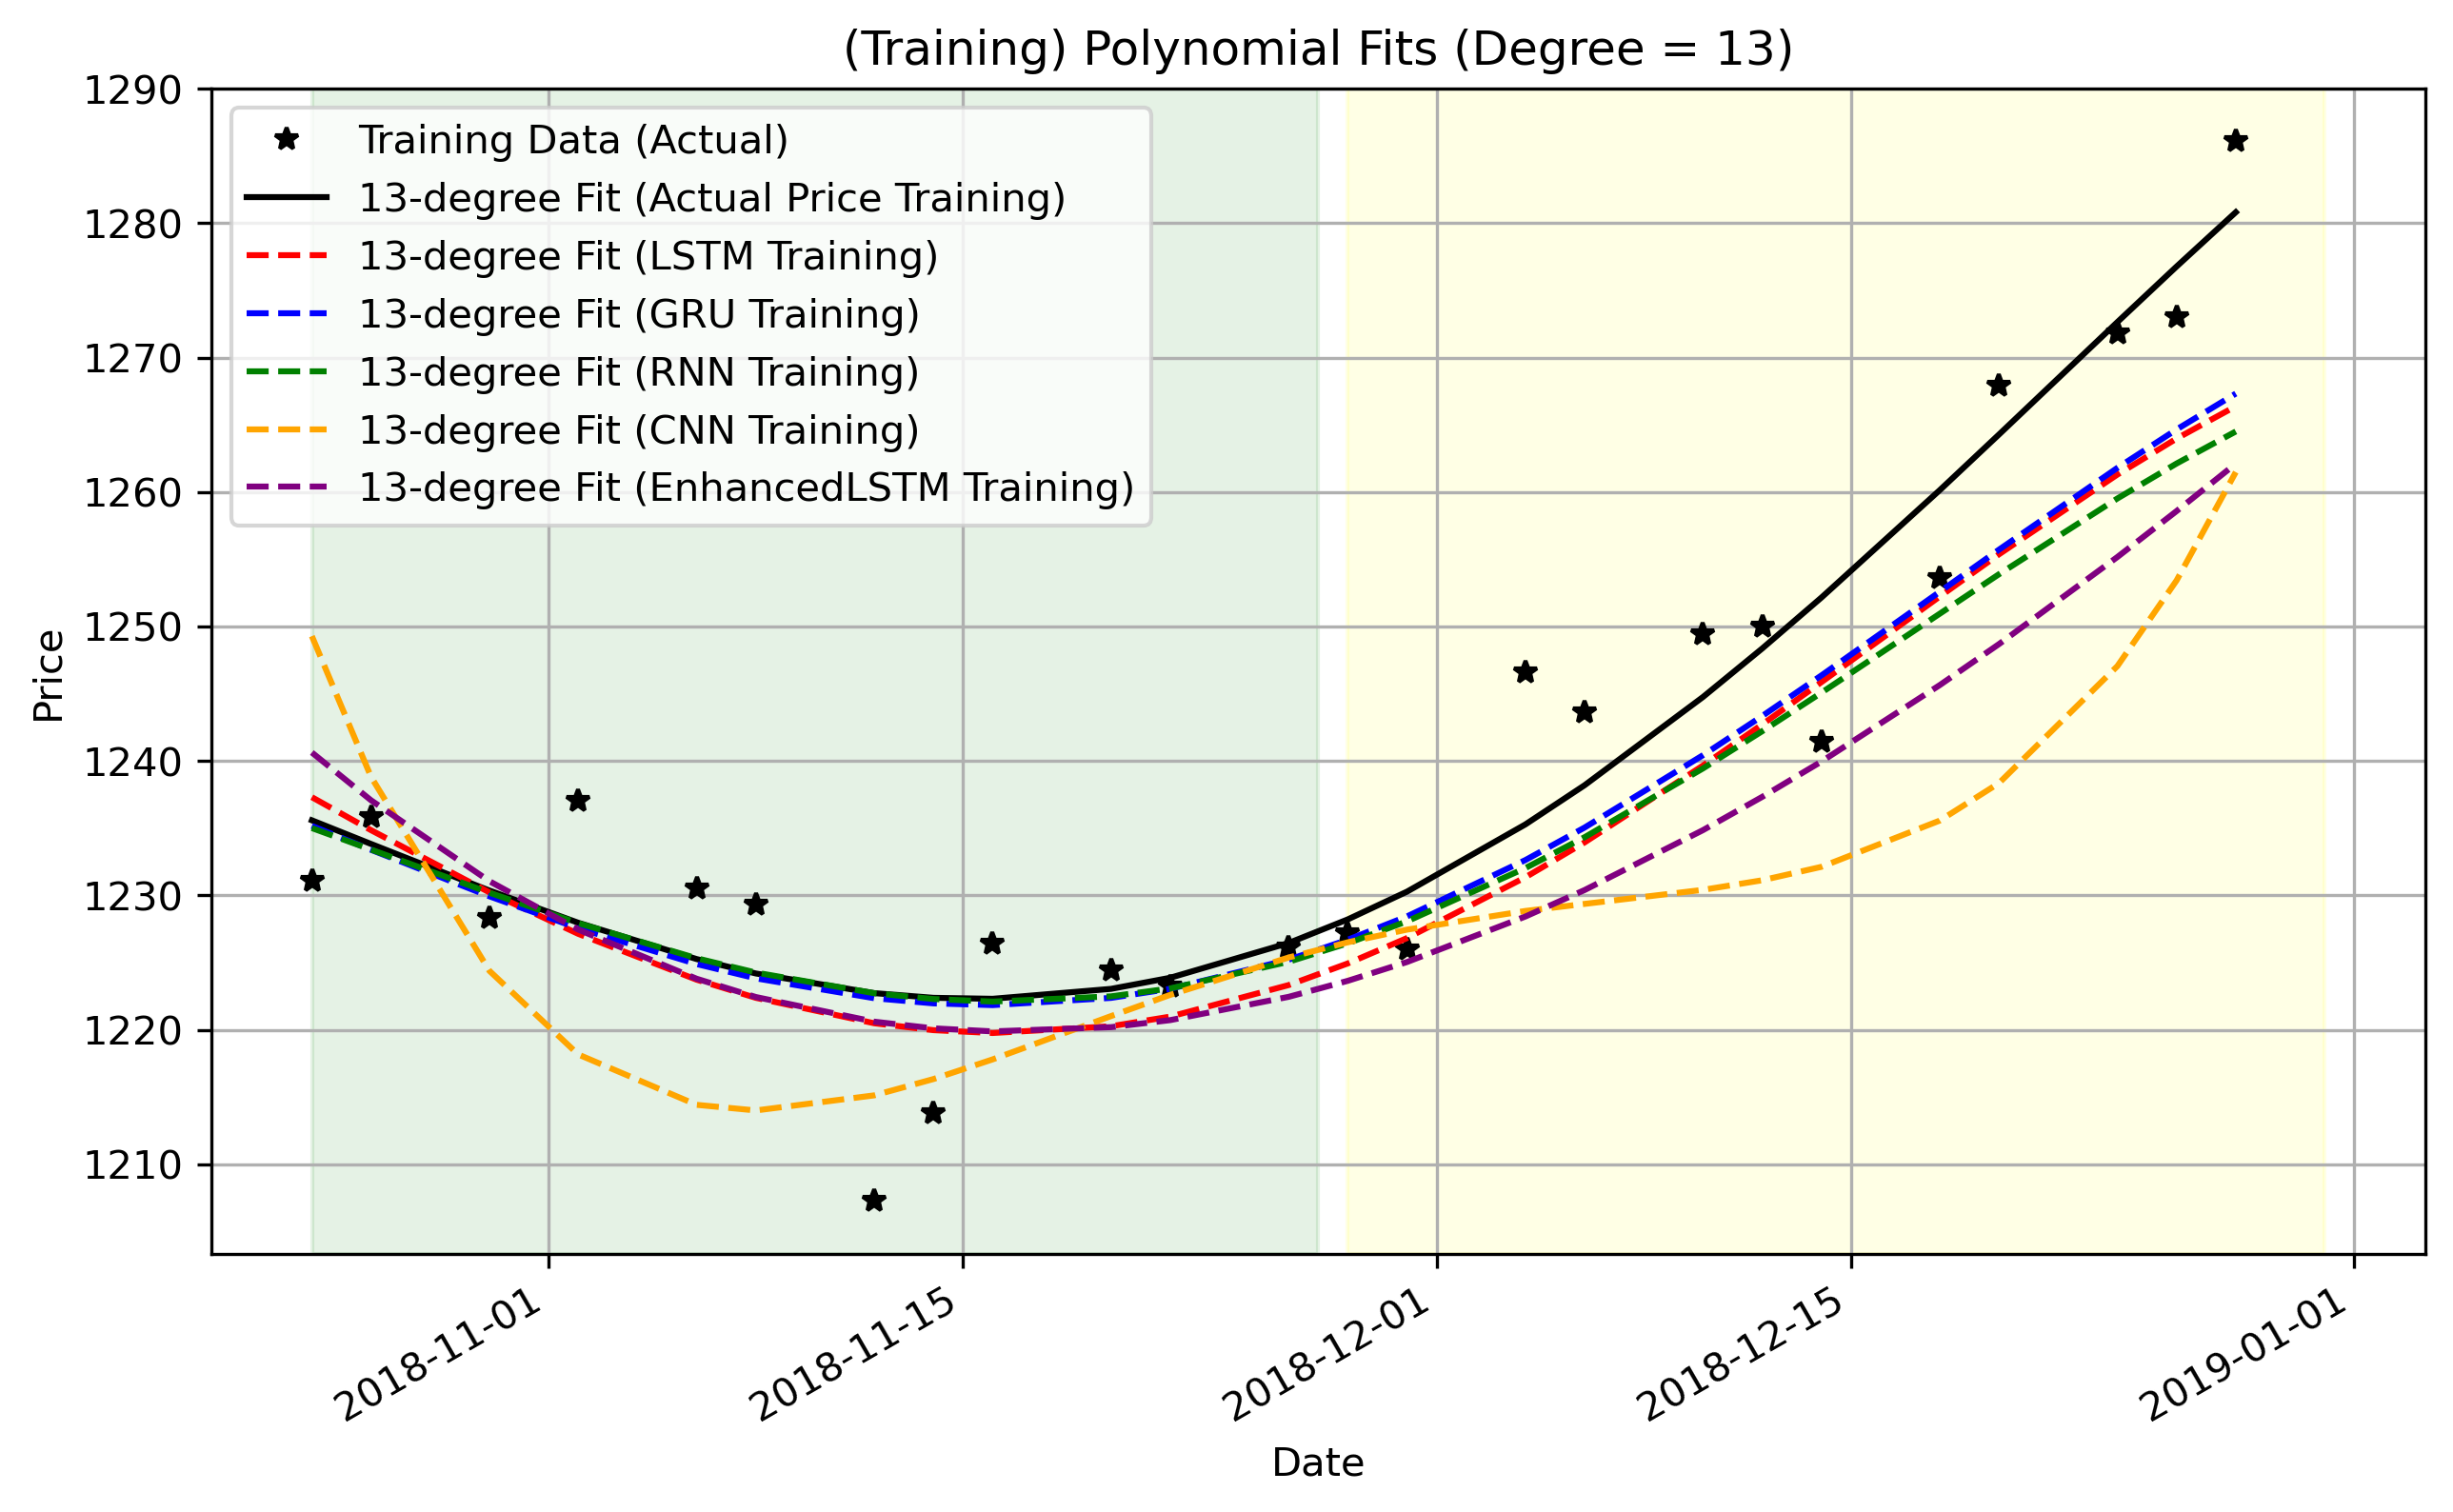

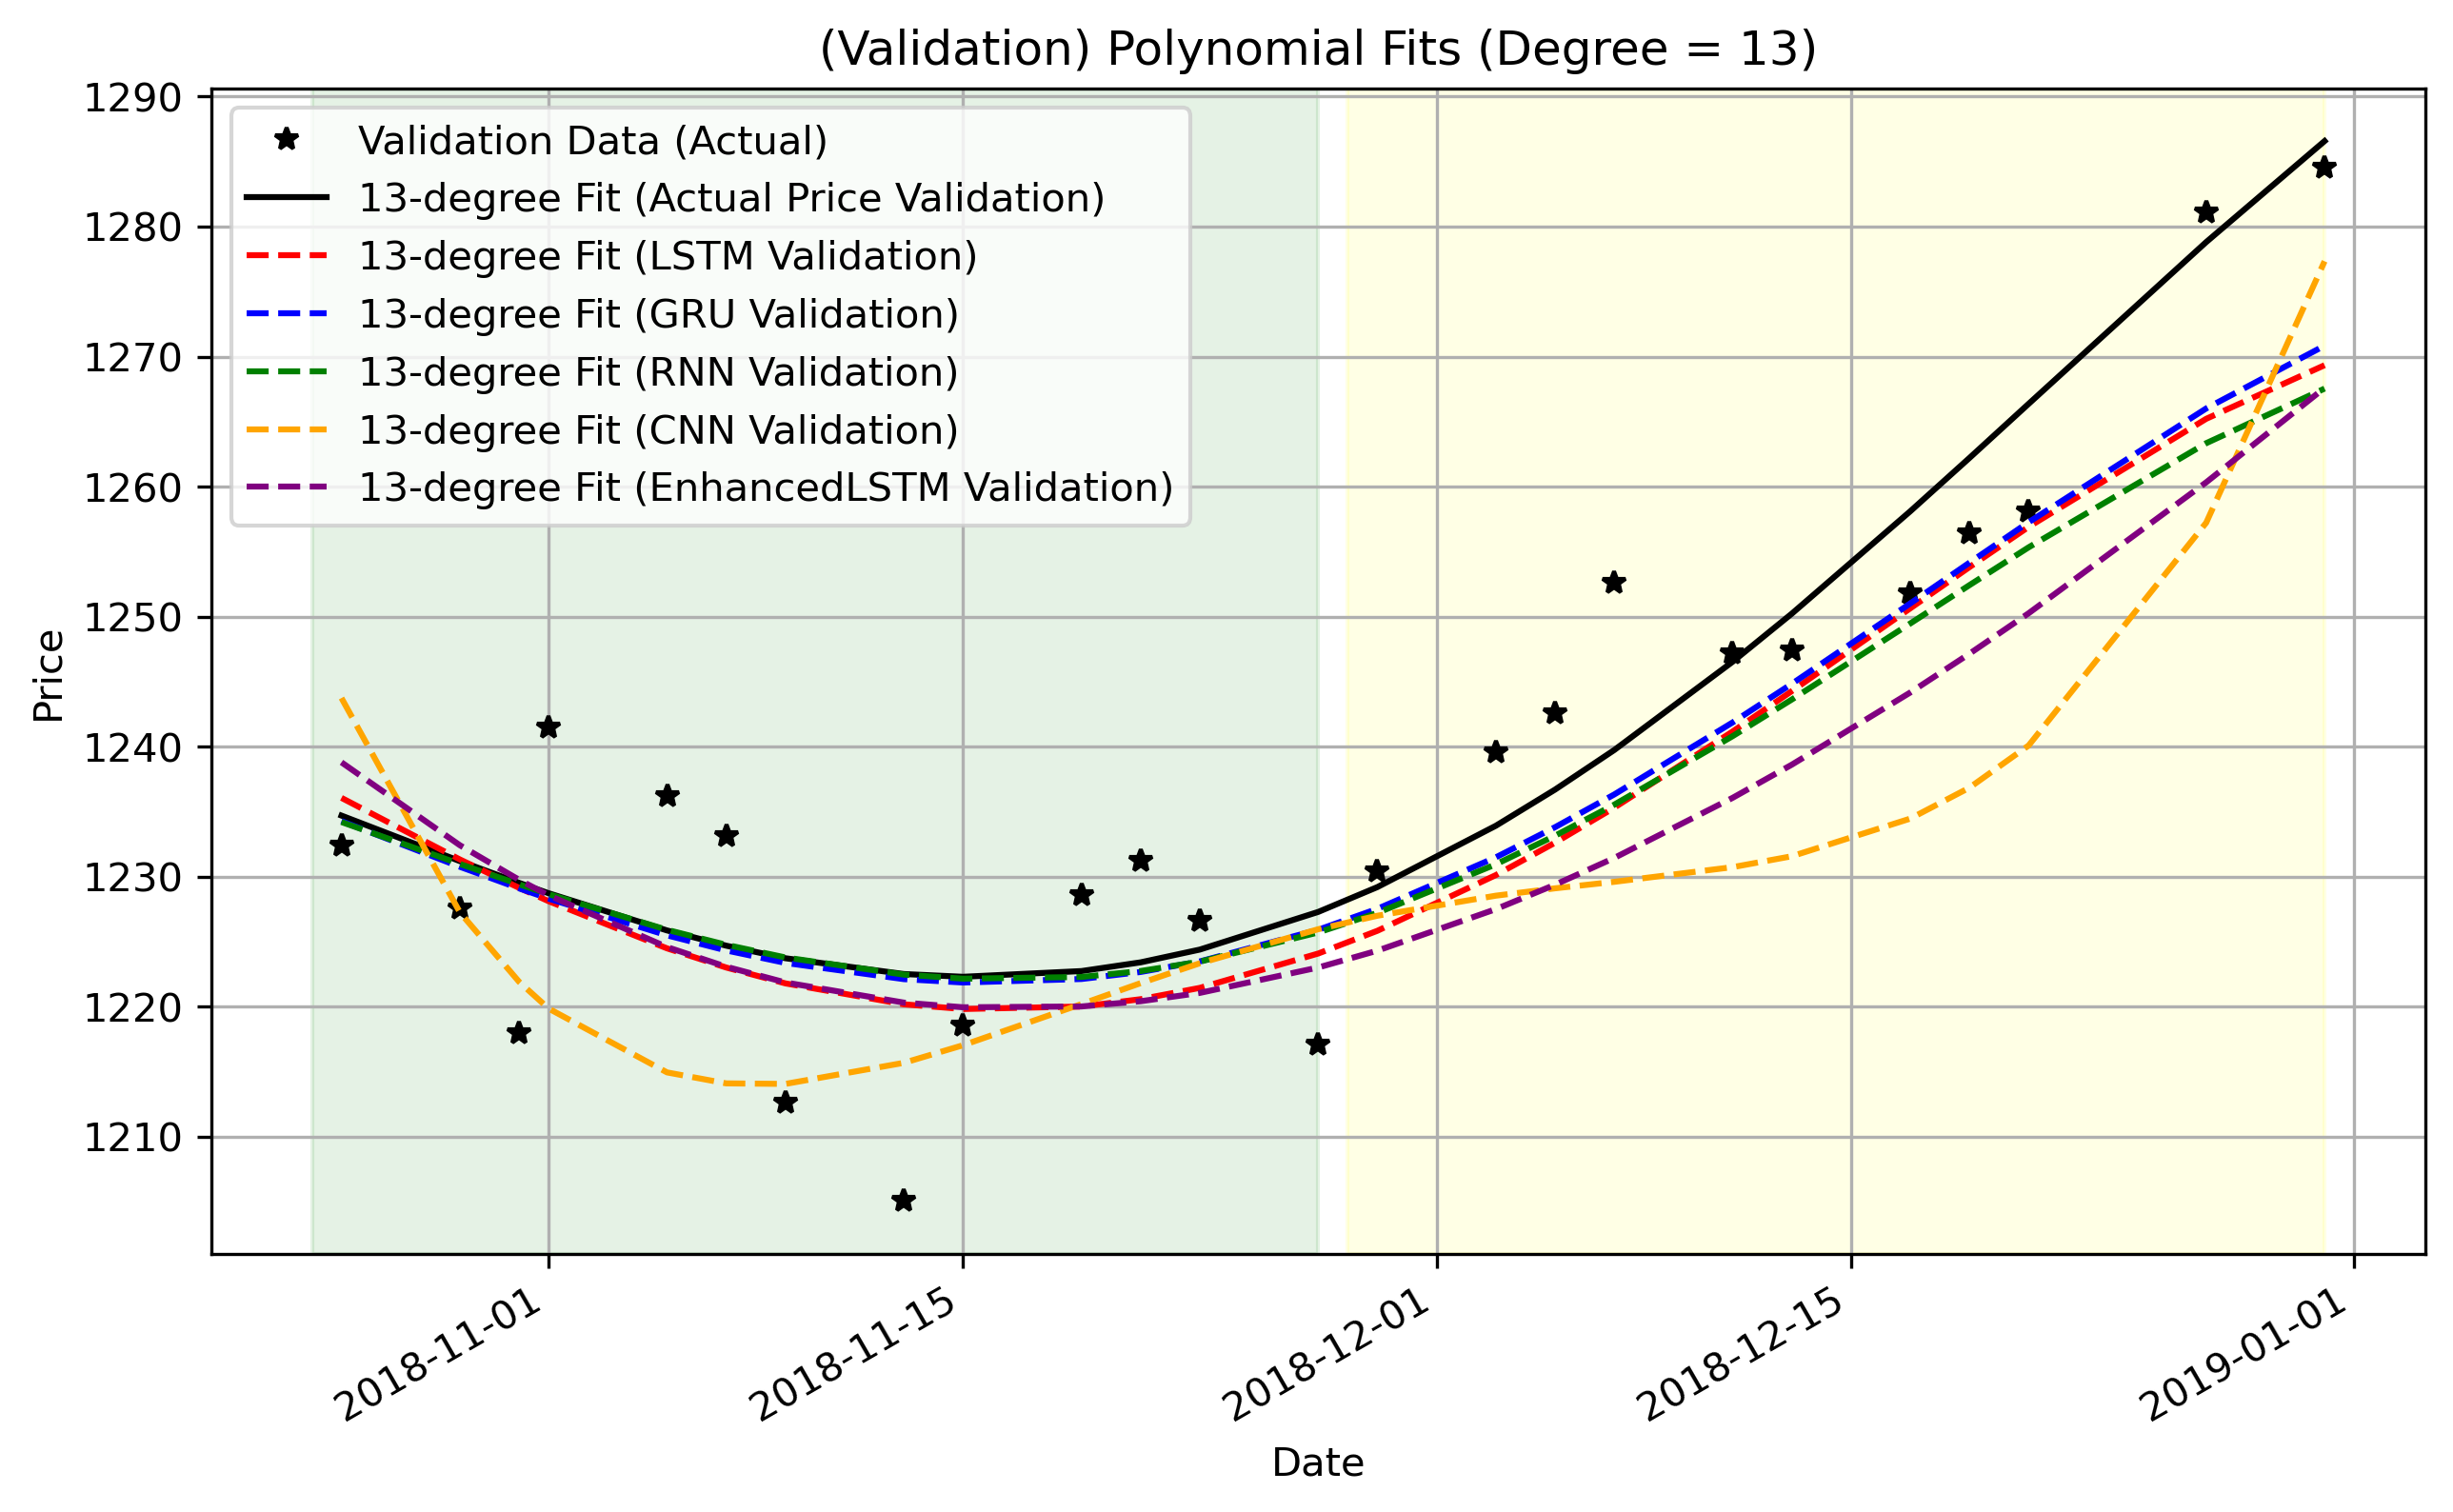


Degree 13 Polynomial Expressions:
----------------------------------------
Actual Price: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0013x^3 + 34.4265x^2 + 358941.2085x - 11893602958.9345
LSTM: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0014x^3 + 37.1399x^2 + 387502.2388x - 12824090835.4343
GRU: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0013x^3 + 33.8339x^2 + 352885.0365x - 11685717237.9590
RNN: y = -0.0000x^13 + 0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 - 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 + 0.0000x^4 + 0.0014x^3 + 36.4376x^2 + 380009.8398x - 12585859312.1819
CNN: y = 0.0000x^13 - 0.0000x^12 - 0.0000x^11 - 0.0000x^10 - 0.0000x^9 + 0.0000x^8 + 0.0000x^7 + 0.0000x^6 + 0.0000x^5 - 0.0000x^4 - 0.0082x^3 - 209.2

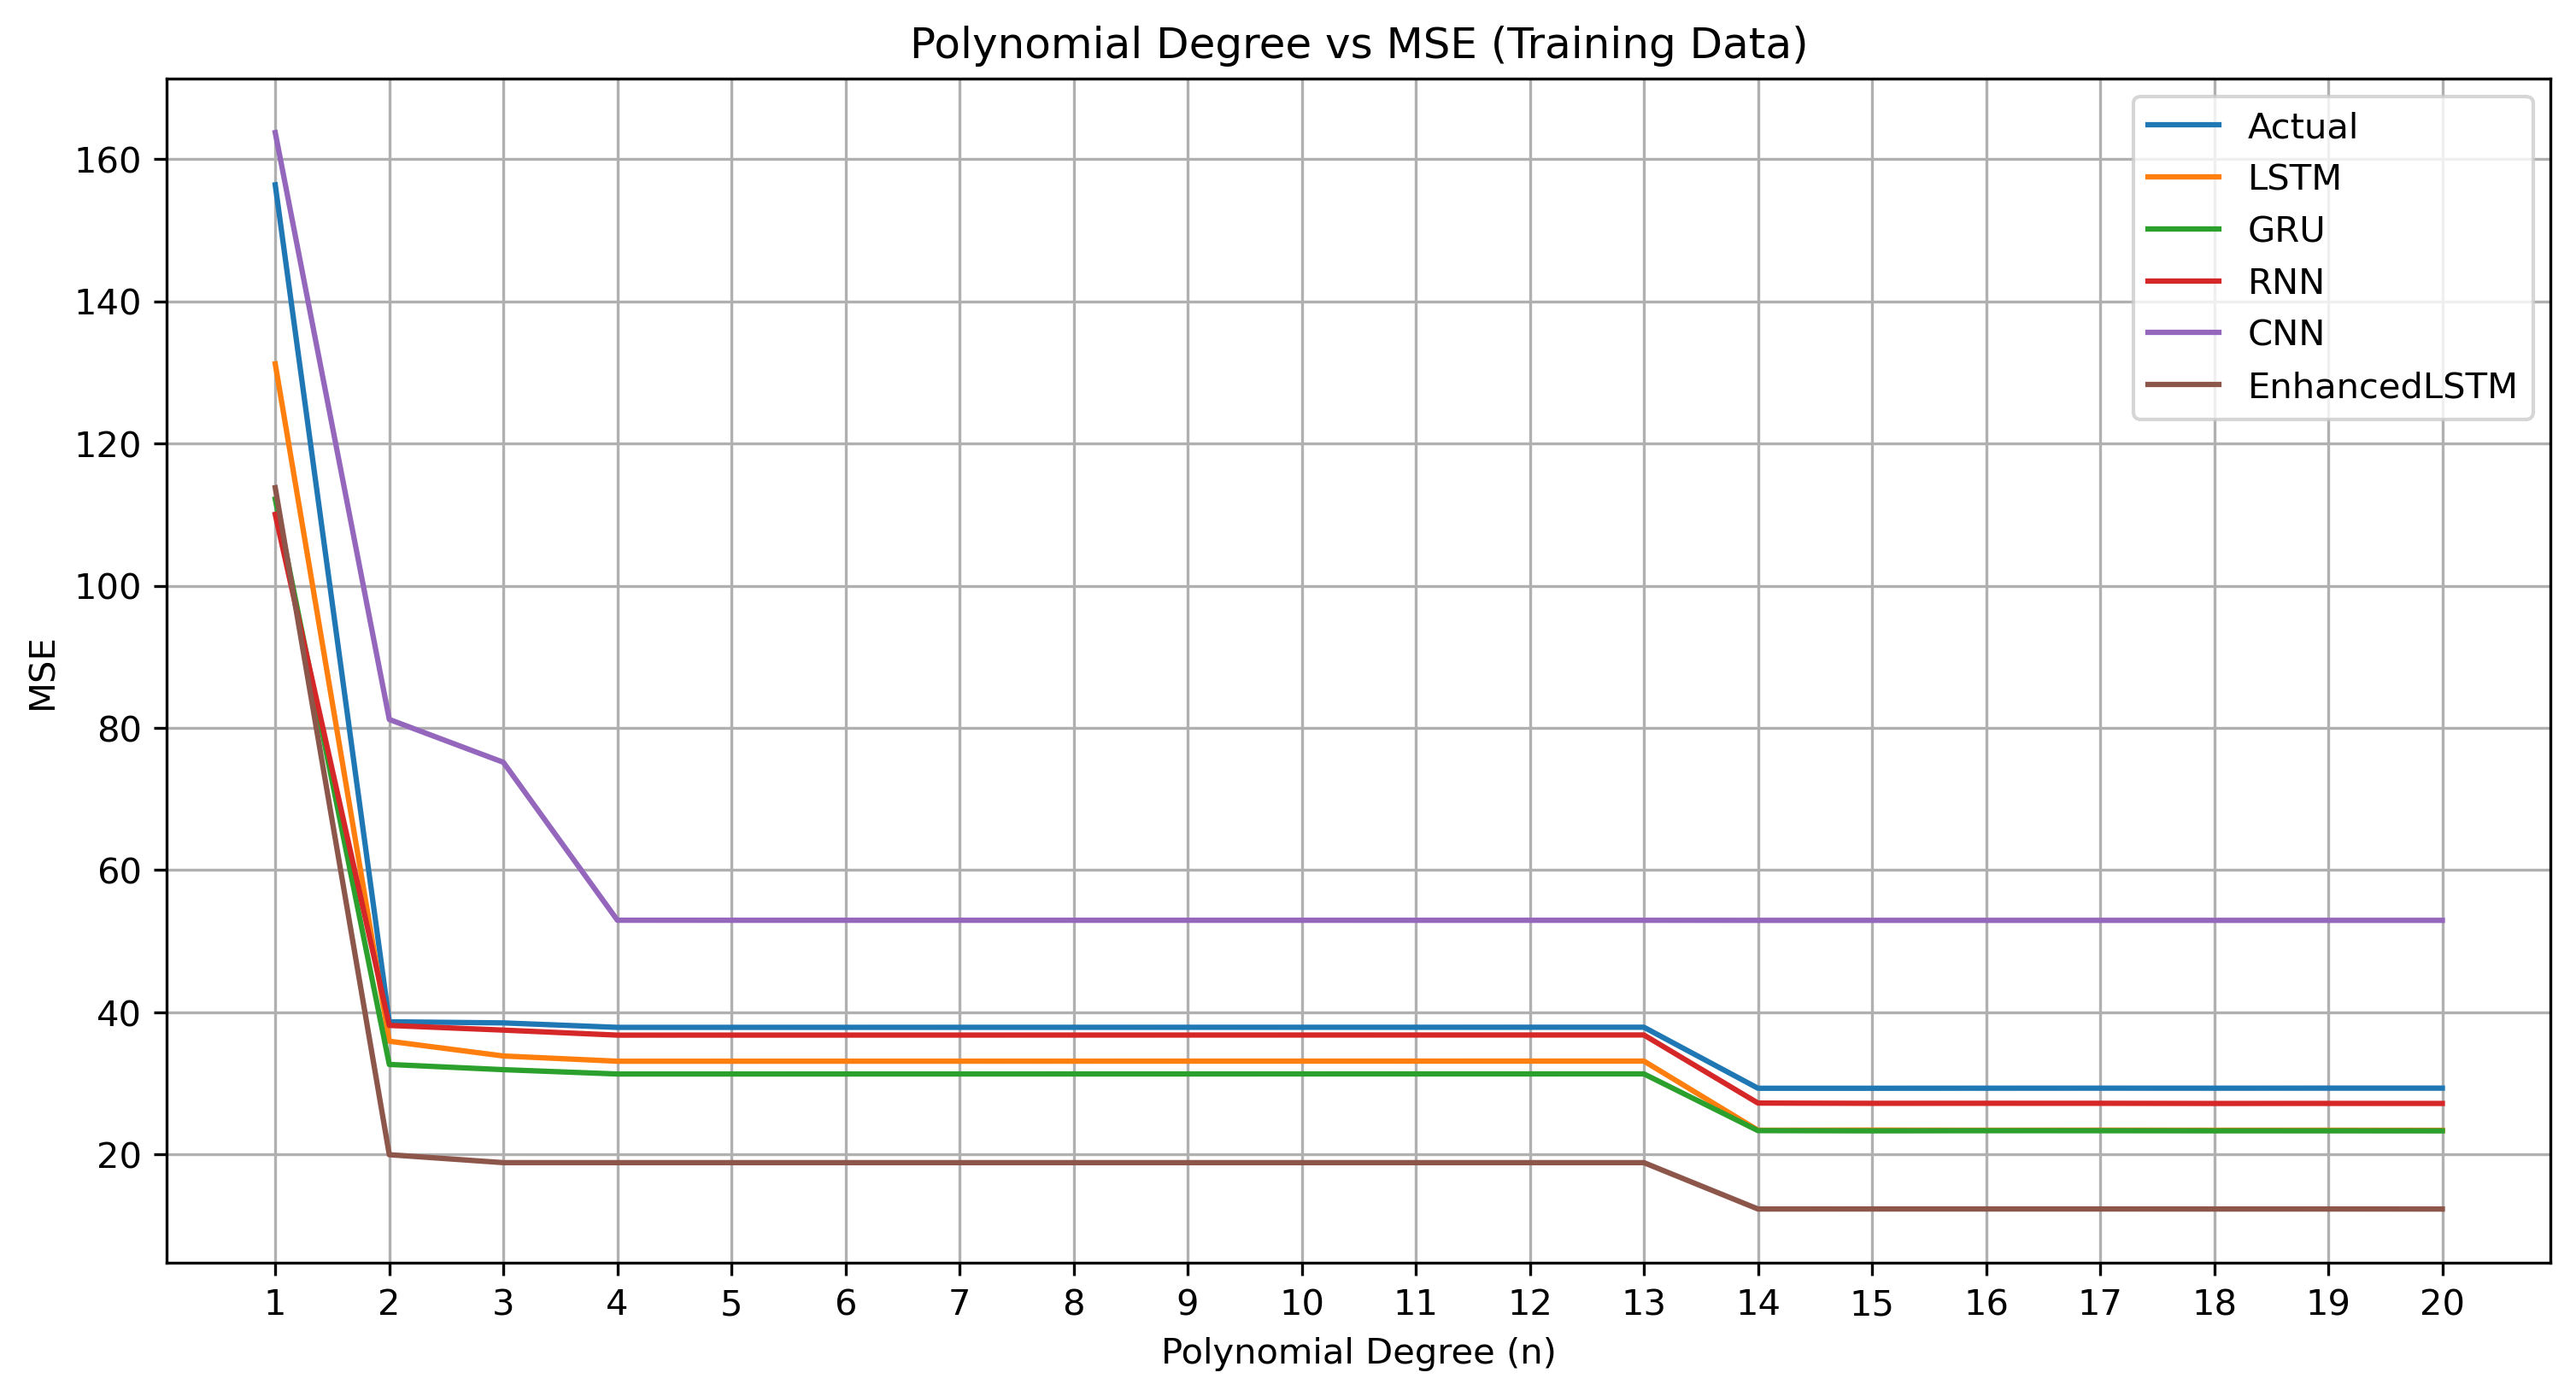

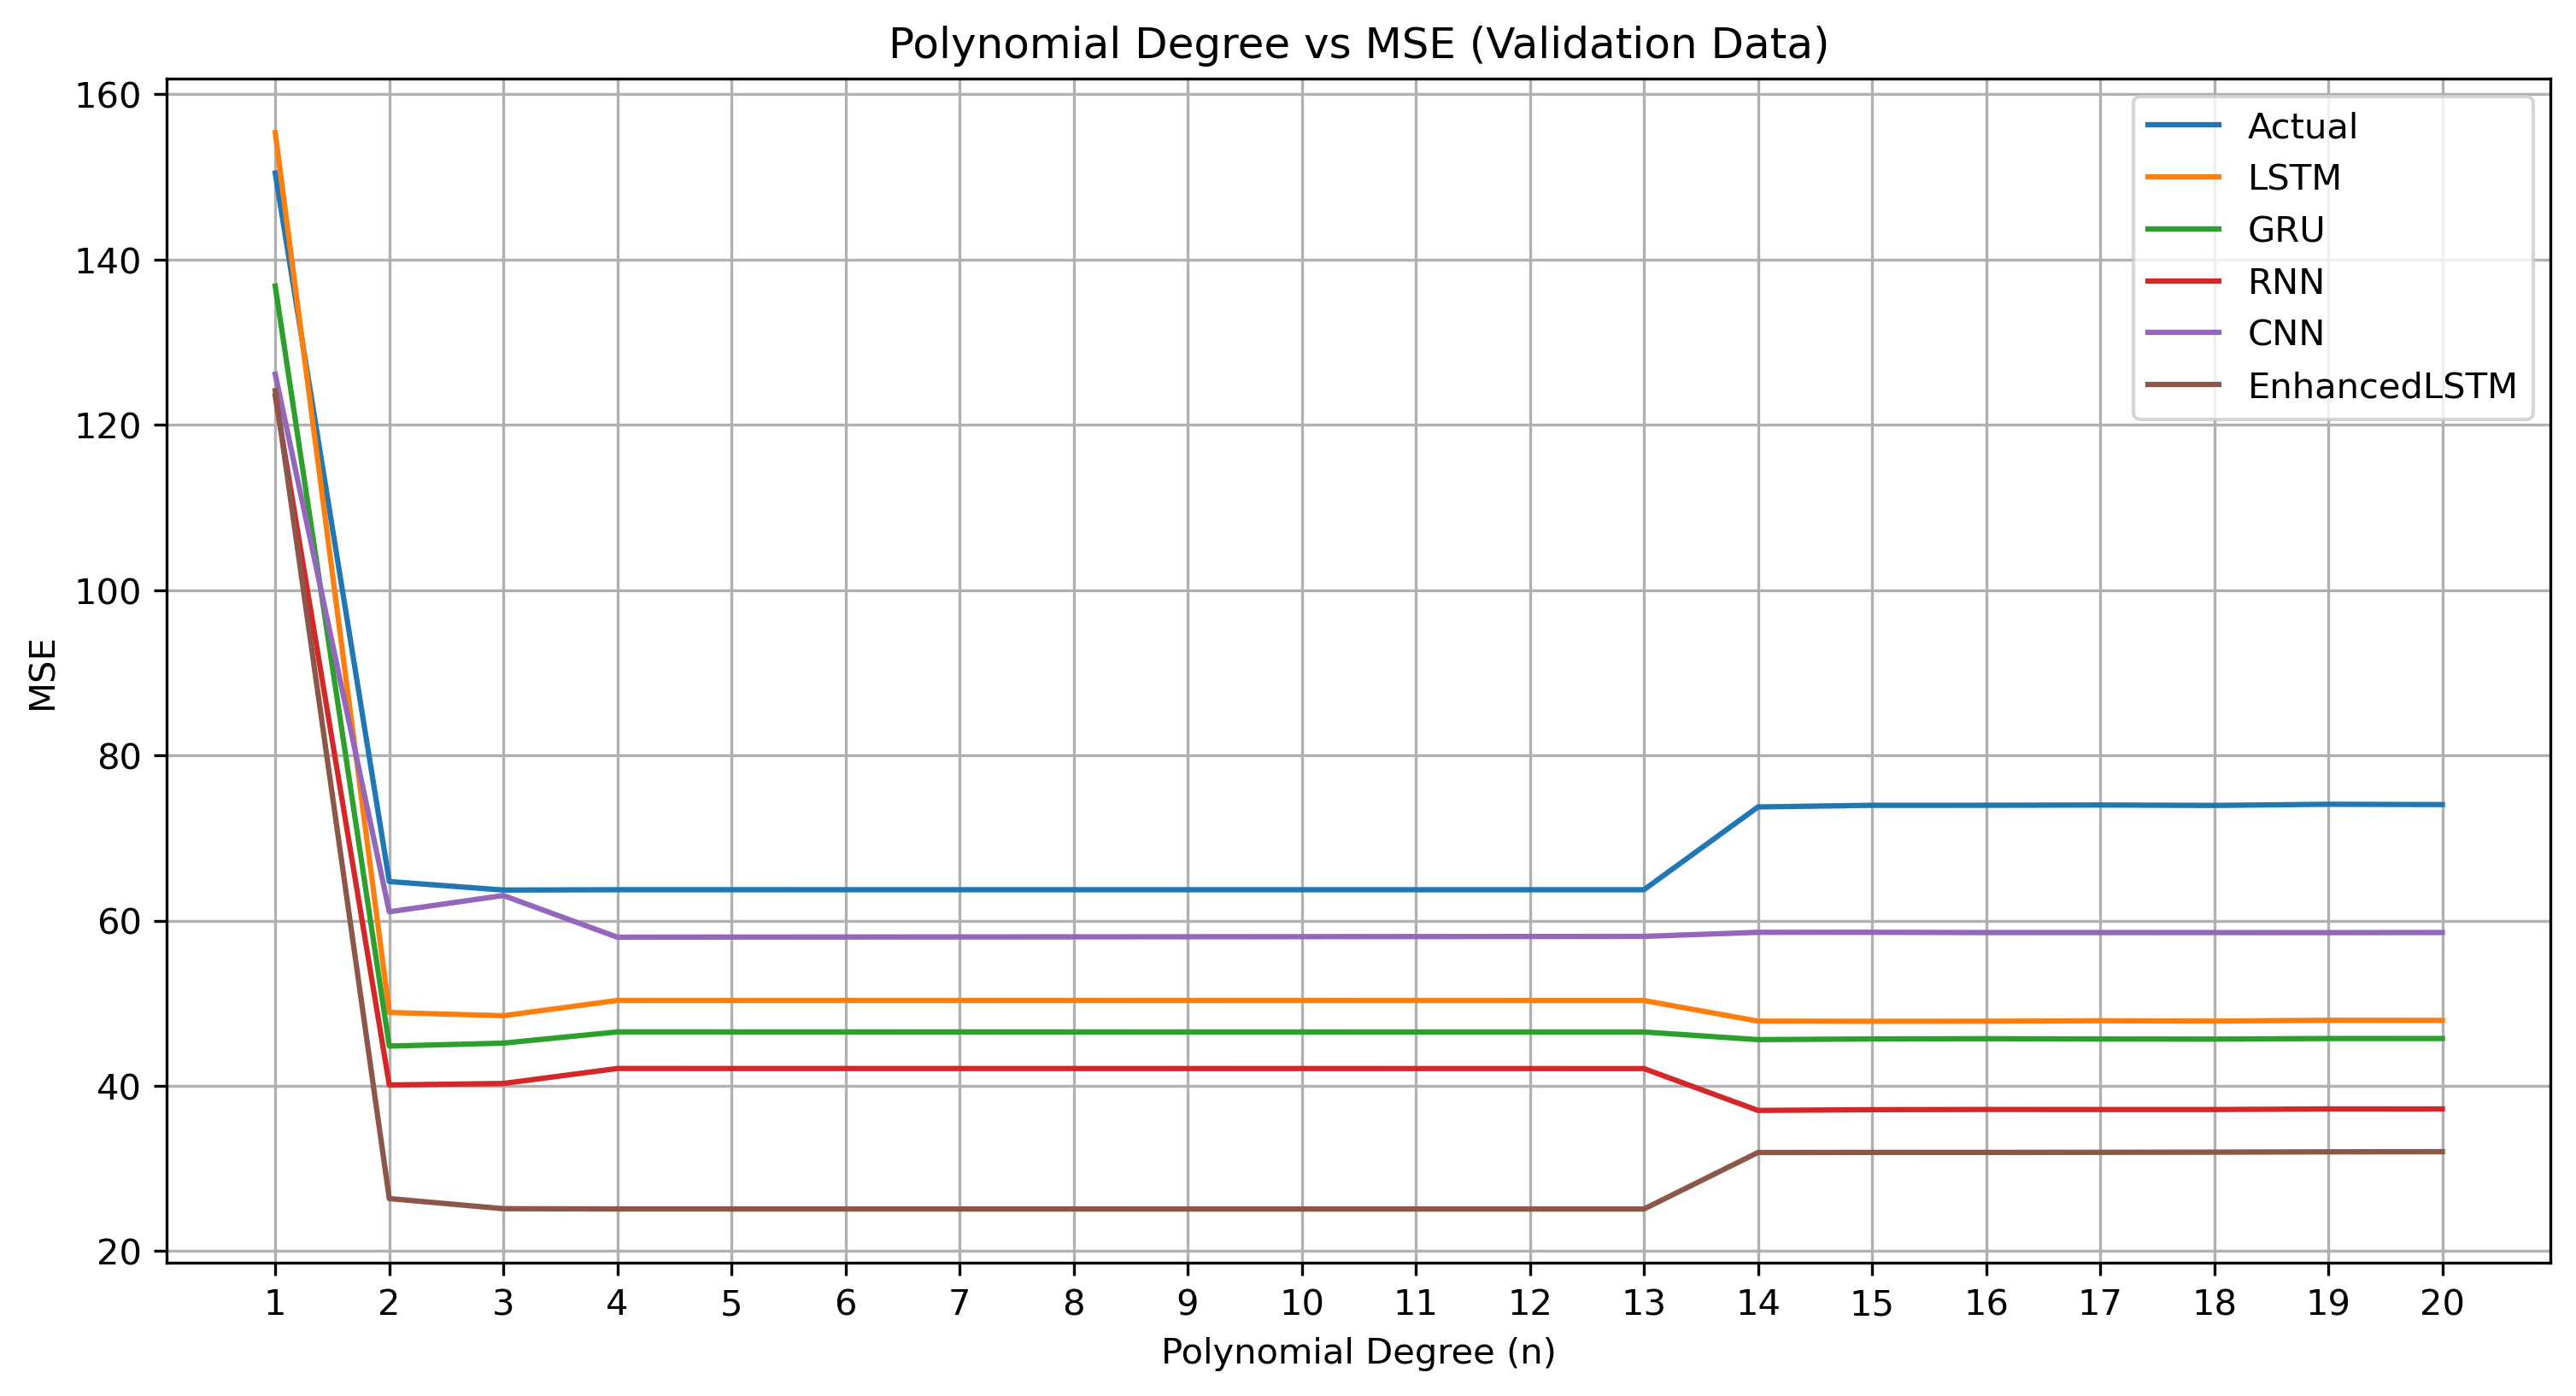

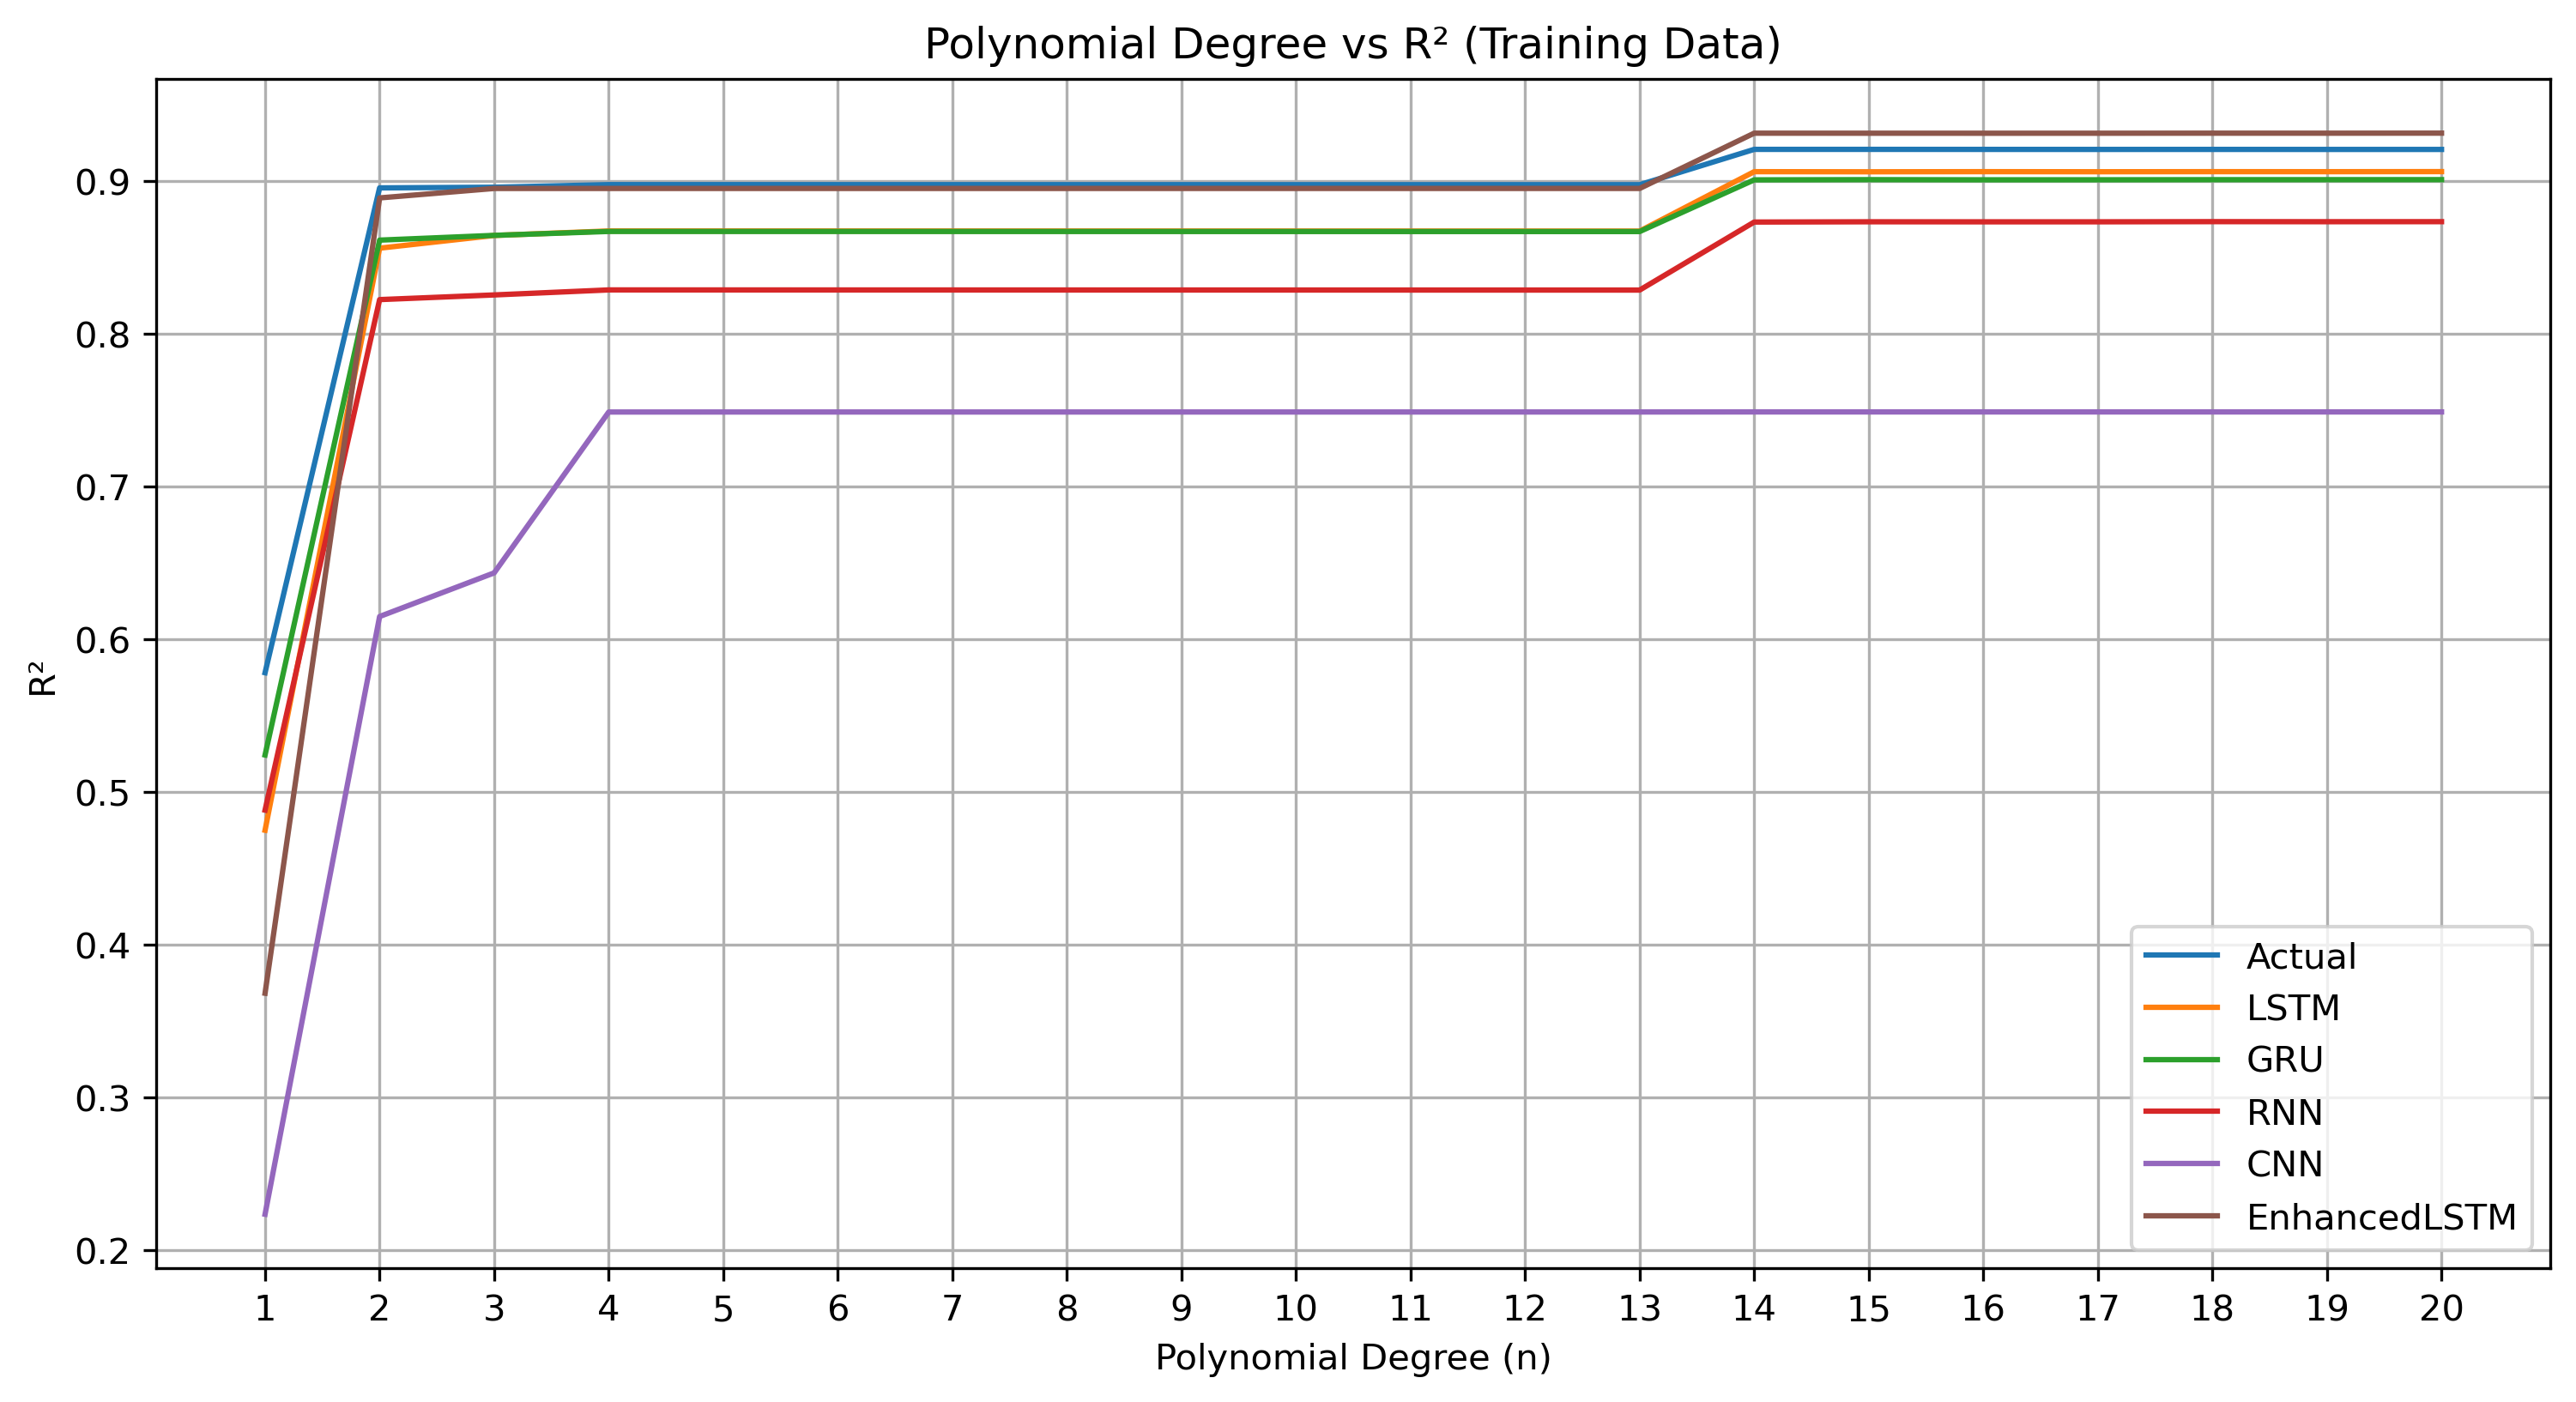

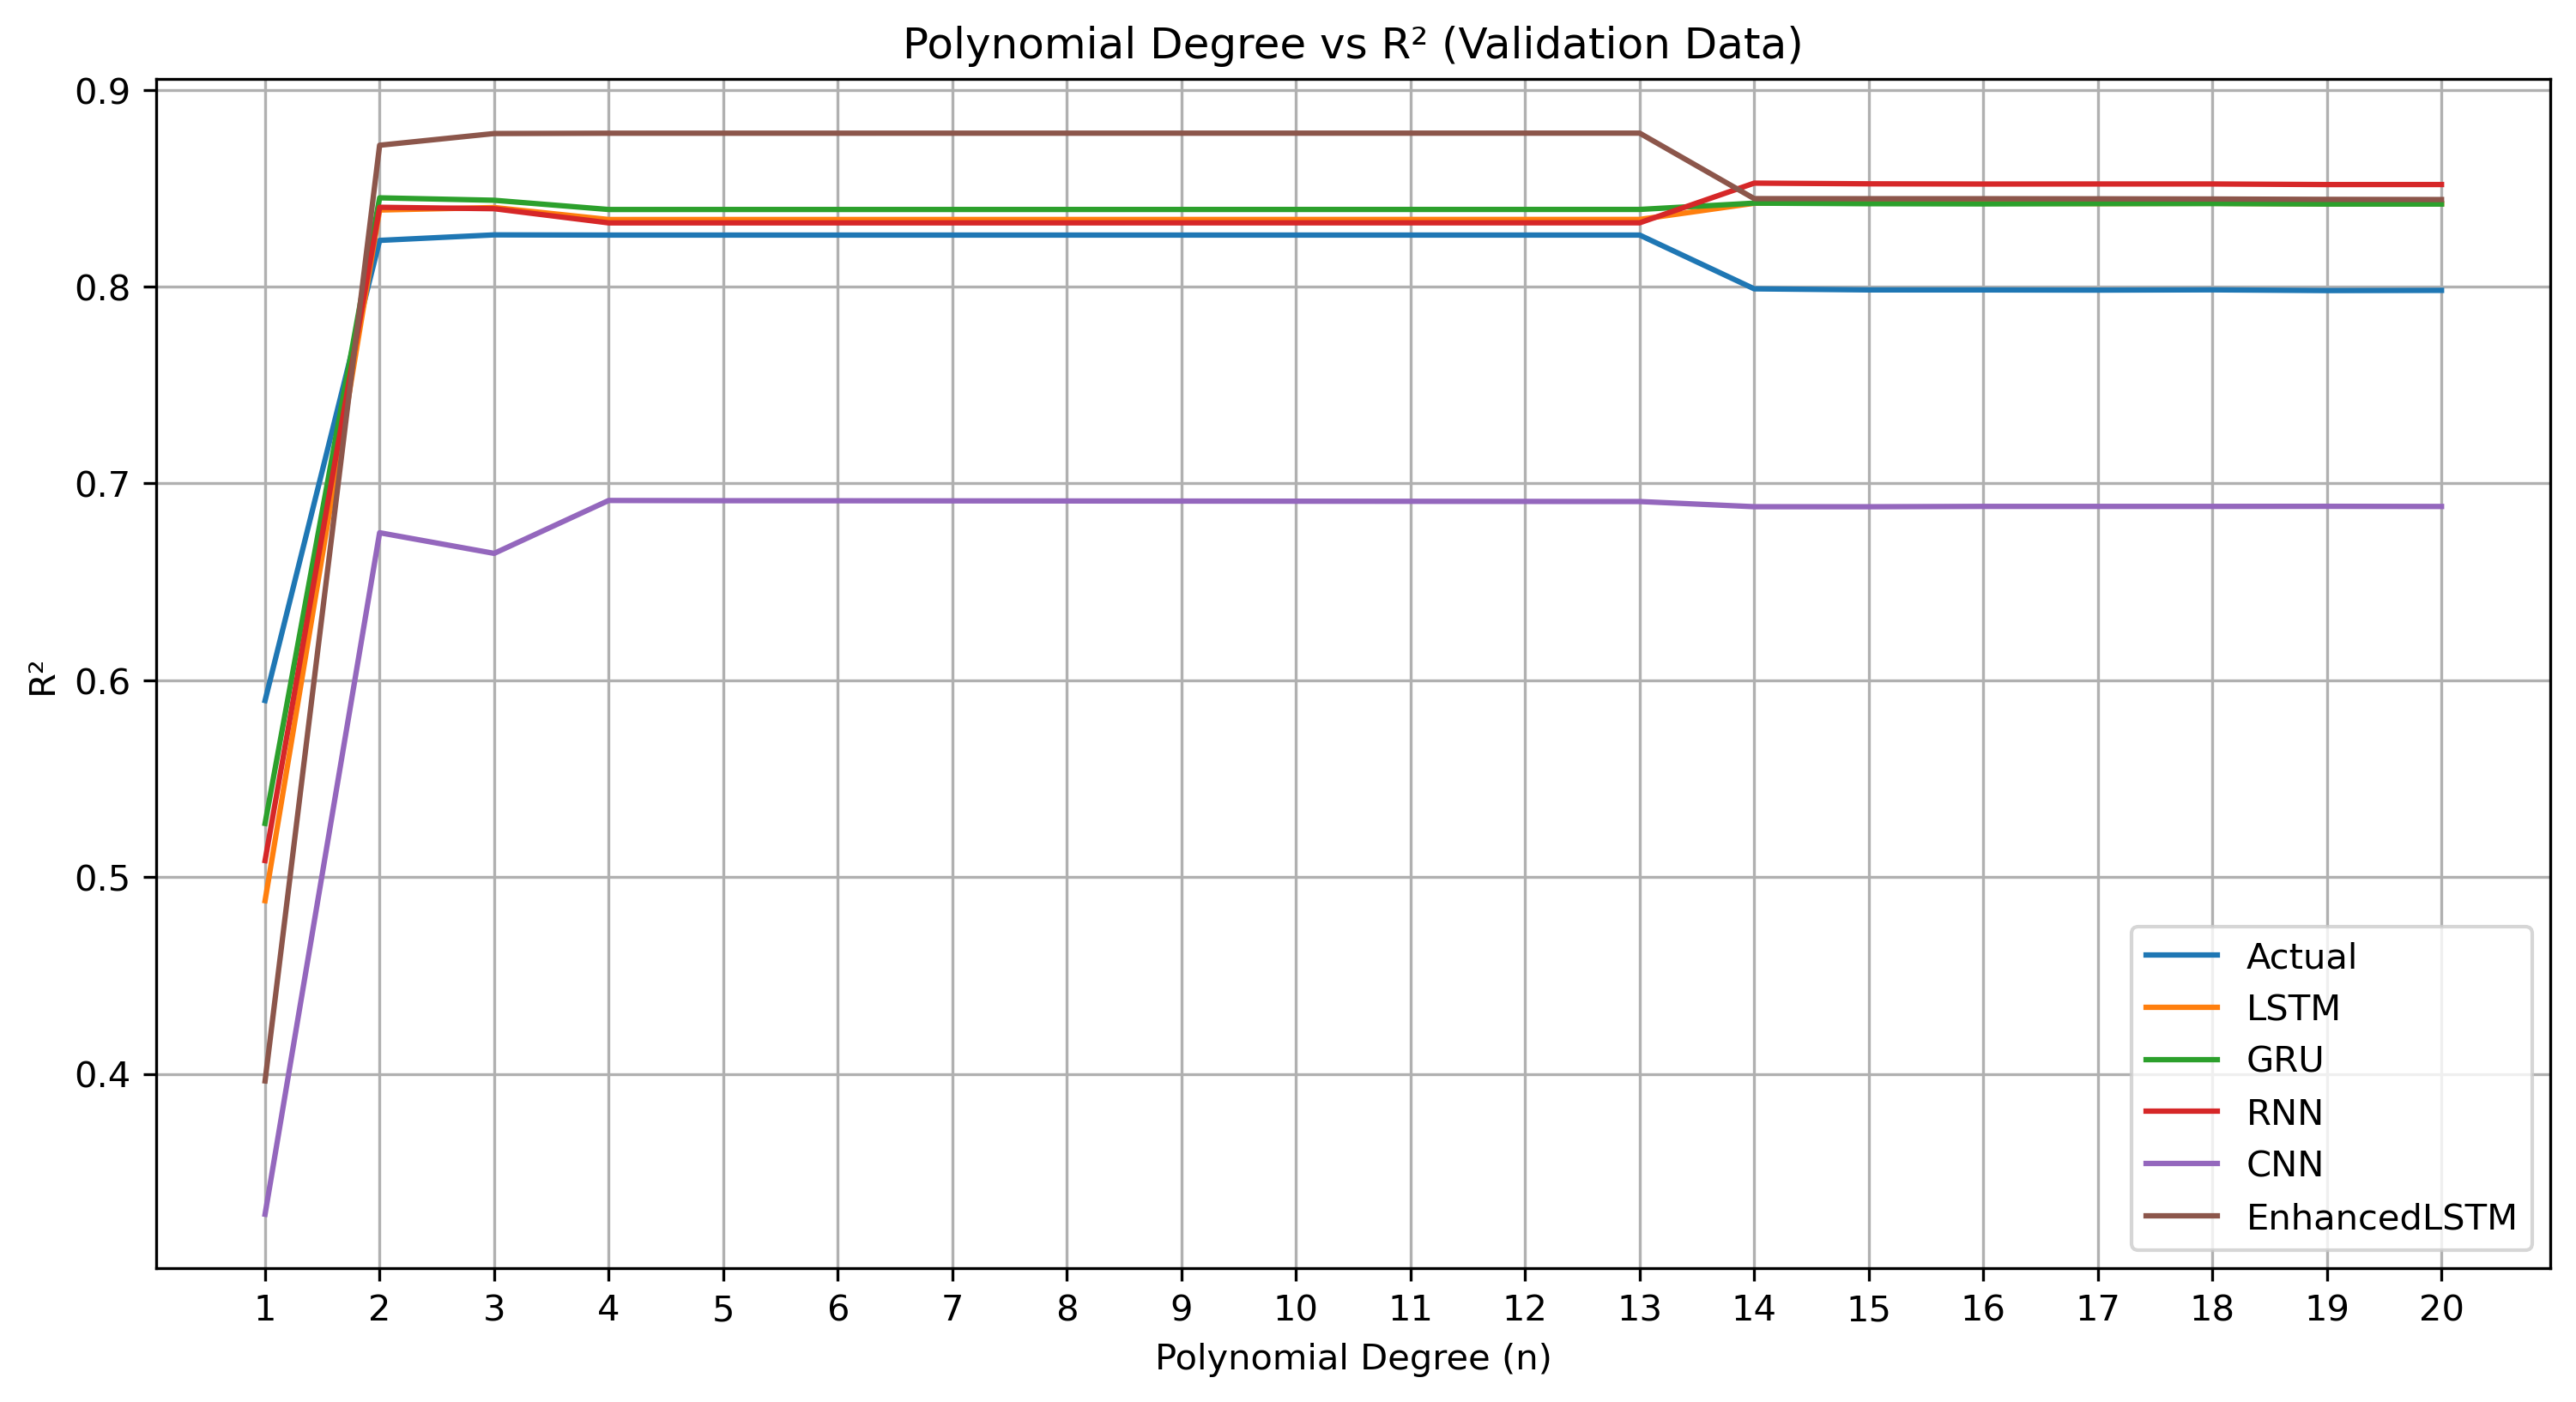

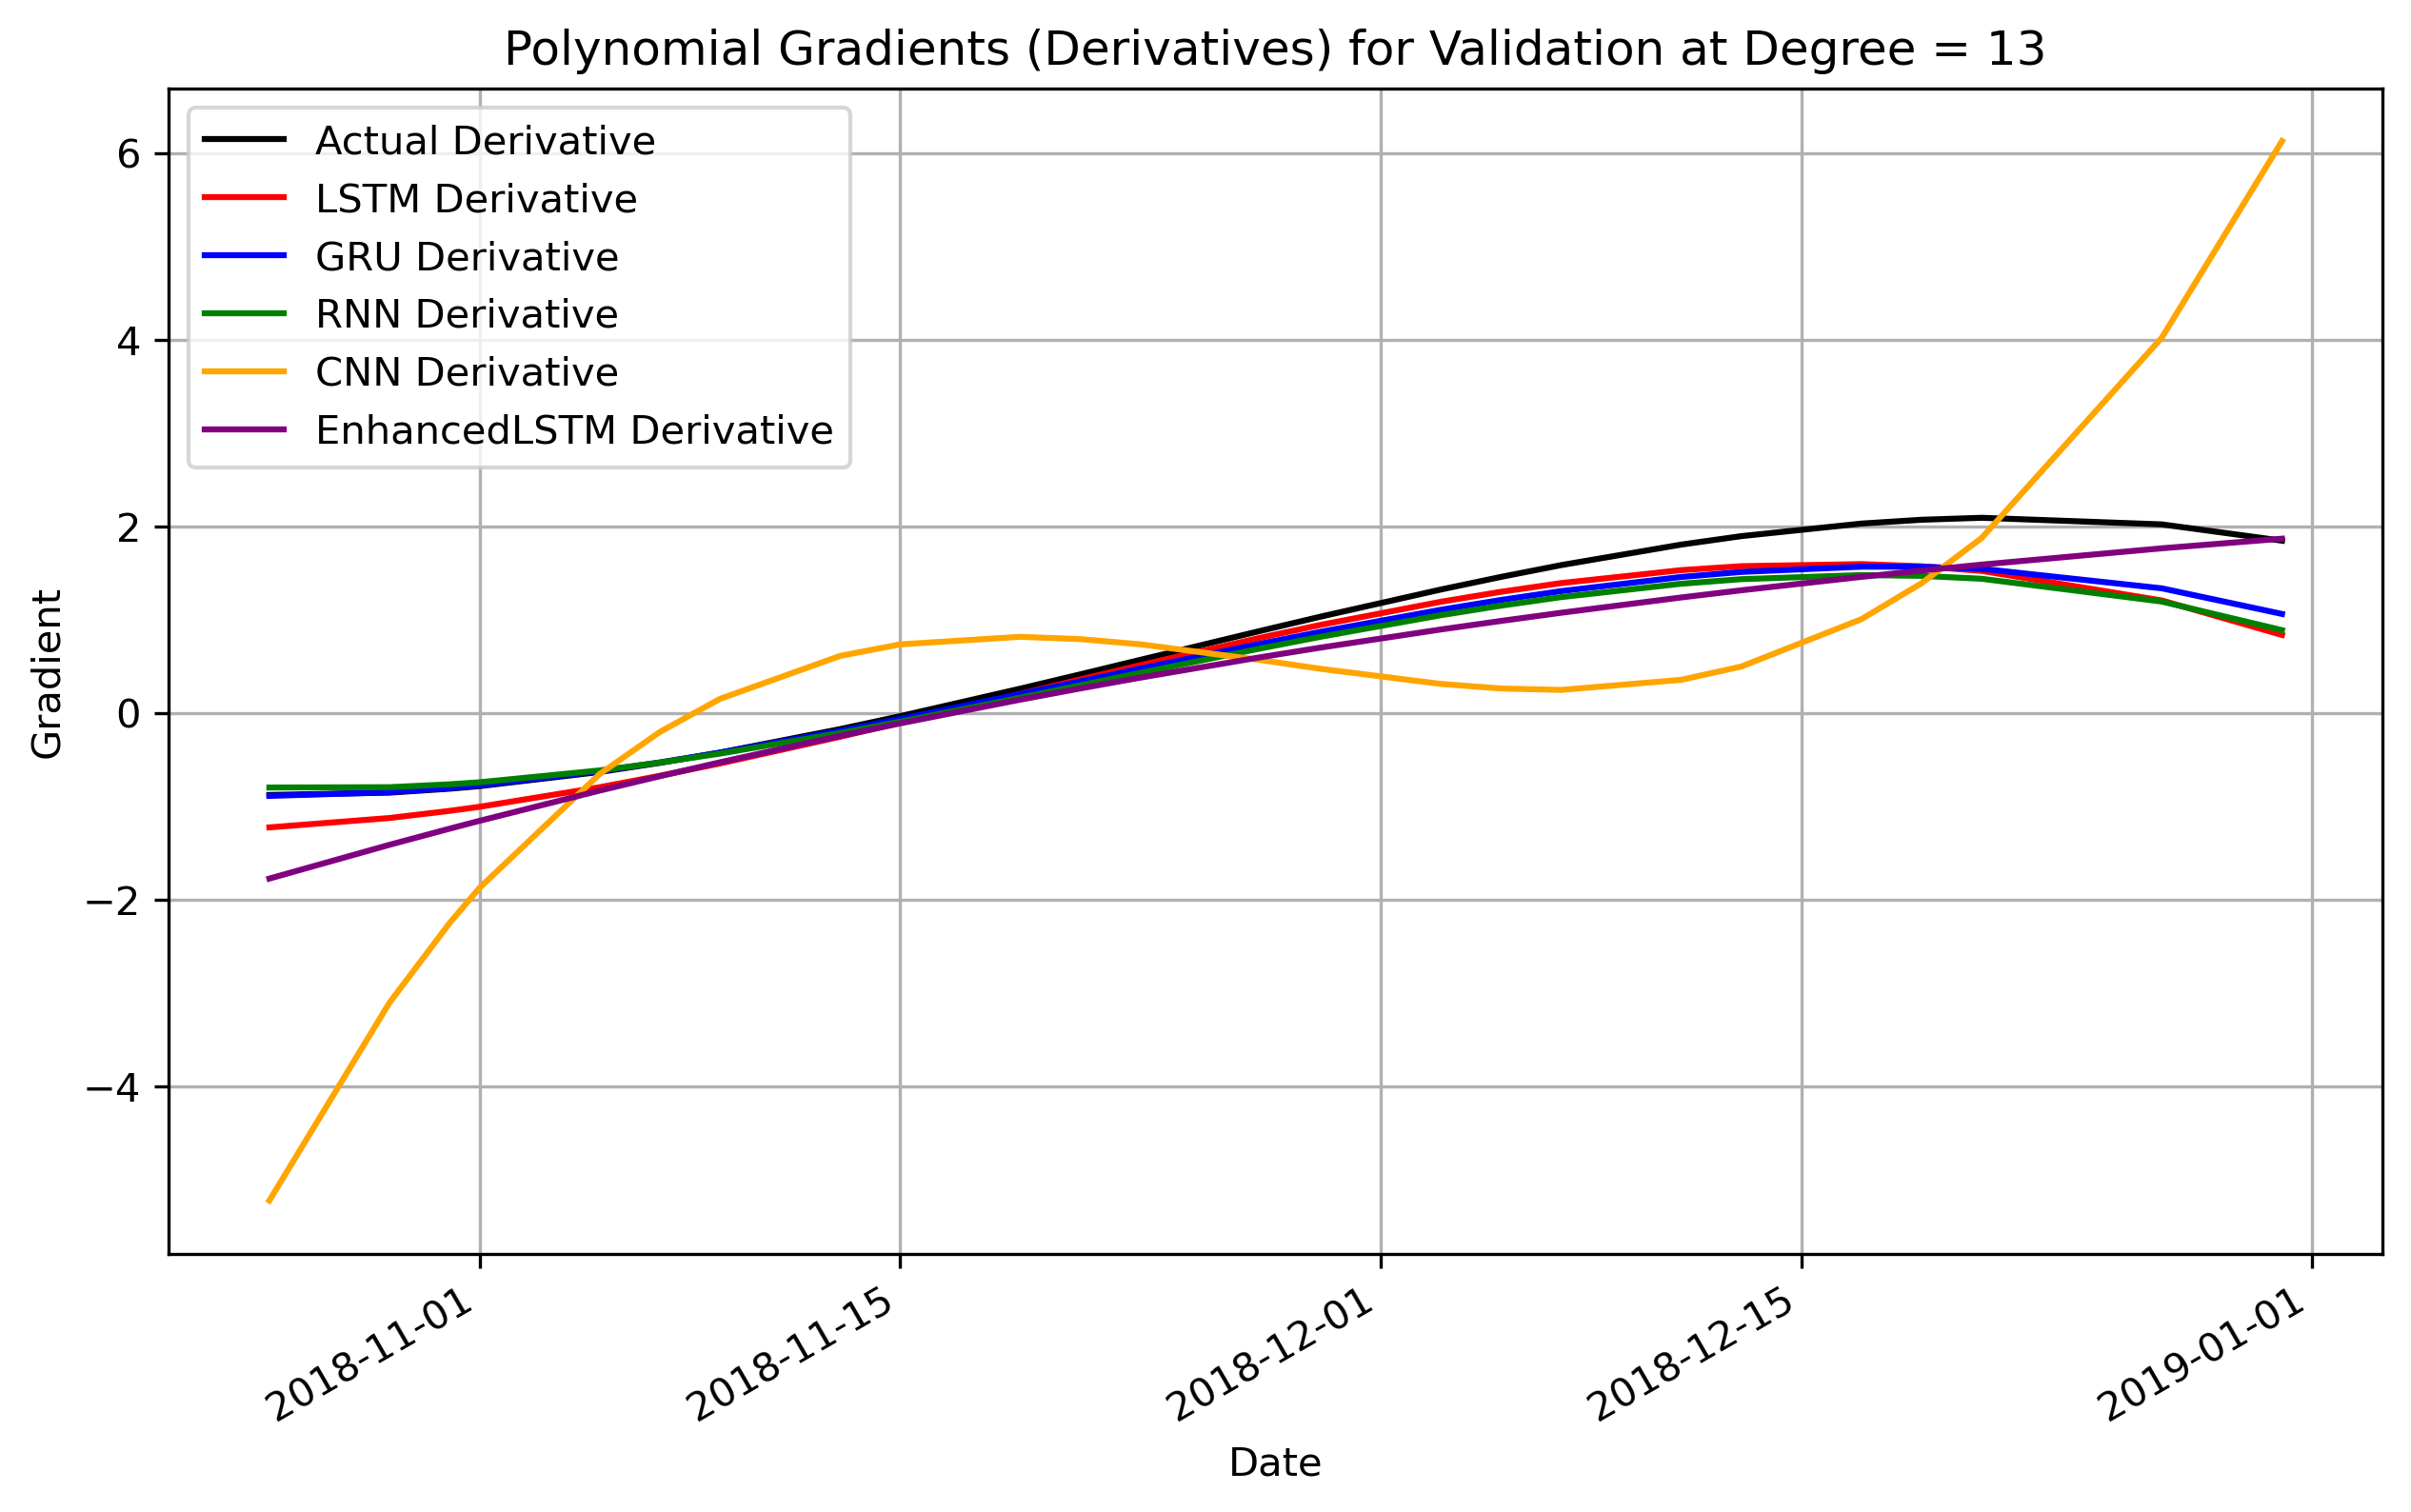


Derivative Polynomials (Degree = 12) for Validation Data at n=13:
------------------------------------------------------------
Actual Price Derivative: dy/dx = -0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 + 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 - 0.0000x^4 + 0.0000x^3 + 0.0040x^2 + 68.8530x + 358941.2085
LSTM Derivative: dy/dx = -0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 + 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 - 0.0000x^4 + 0.0000x^3 + 0.0043x^2 + 74.2799x + 387502.2388
GRU Derivative: dy/dx = -0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 + 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 - 0.0000x^4 + 0.0000x^3 + 0.0040x^2 + 67.6677x + 352885.0365
RNN Derivative: dy/dx = -0.0000x^12 + 0.0000x^11 + 0.0000x^10 + 0.0000x^9 + 0.0000x^8 - 0.0000x^7 - 0.0000x^6 - 0.0000x^5 - 0.0000x^4 + 0.0000x^3 + 0.0043x^2 + 72.8753x + 380009.8398
CNN Derivative: dy/dx = 0.0000x^12 - 0.0000x^11 - 0.0000x^10 - 0.0000x^9 - 0.0000x^8 + 0.0000x^7 + 0.0000x^6 + 0.0000x^5 + 0.0000x

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------------------------
# Assume the following variables already exist in your code base:
#   val_dates  : array of validation dates (pd.DatetimeIndex or np.array of timestamps)
#   test_dates : array of test dates
#   y_val_inv  : array of actual validation prices (in original scale)
#   y_test_inv : array of actual test prices (in original scale)
#
#   all_results: a dictionary where each key is a model name (e.g. 'LSTM'),
#                and each value is another dict containing:
#       - 'y_val_pred_inv' : validation predictions (in original scale)
#       - 'y_test_pred_inv': test predictions (in original scale)
# ------------------------------------------------

# Combine validation + test data
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Convert datetime objects to numeric for polynomial fitting
date_numeric = mdates.date2num(zoom_dates)

# Define model names and their corresponding colors
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Create masks for training (even days) and validation (odd days)
training_mask = np.array([d.day % 2 == 0 for d in zoom_dates])  # Even day
validation_mask = ~training_mask  # Odd day

# Extract training and validation subsets
zoom_dates_train = zoom_dates[training_mask]
zoom_actual_train = zoom_actual[training_mask]
date_numeric_train = date_numeric[training_mask]

zoom_dates_val = zoom_dates[validation_mask]
zoom_actual_val = zoom_actual[validation_mask]
date_numeric_val = date_numeric[validation_mask]

# Define the range of polynomial degrees to evaluate
poly_degrees = range(1, 70)  # Degrees from 1 to 69

# Initialize variables to track the best validation MSE and R²
lowest_val_mse = float('inf')
highest_val_r2 = float('-inf')

best_val_mse_info = None
best_val_r2_info = None

# -------------------------------------------------
# 1) Find degrees for the lowest Validation MSE
#    and the highest Validation R²
# -------------------------------------------------
for n in poly_degrees:
    # Fit polynomial to ACTUAL (training) -> Evaluate on validation
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
    val_mse_actual = mean_squared_error(zoom_actual_val, poly_actual_val)
    val_r2_actual  = r2_score(zoom_actual_val, poly_actual_val)

    # Check if Actual's validation MSE / R² are best
    if val_mse_actual < lowest_val_mse:
        lowest_val_mse = val_mse_actual
        best_val_mse_info = ("Actual", n, val_mse_actual)

    if val_r2_actual > highest_val_r2:
        highest_val_r2 = val_r2_actual
        best_val_r2_info = ("Actual", n, val_r2_actual)

    # Fit polynomial for each model; check validation MSE / R²
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        model_coeff_train = np.polyfit(date_numeric_train, y_pred_train, n)
        model_poly_val    = np.polyval(model_coeff_train, date_numeric_val)
        val_mse_model     = mean_squared_error(y_pred_val, model_poly_val)
        val_r2_model      = r2_score(y_pred_val, model_poly_val)

        if val_mse_model < lowest_val_mse:
            lowest_val_mse = val_mse_model
            best_val_mse_info = (model_name, n, val_mse_model)

        if val_r2_model > highest_val_r2:
            highest_val_r2 = val_r2_model
            best_val_r2_info = (model_name, n, val_r2_model)

print("Lowest Validation MSE ->", best_val_mse_info)
print("Highest Validation R²   ->", best_val_r2_info)

# -------------------------------------------------
# 2) Plot only those degrees (maybe 1 or 2 if distinct)
# -------------------------------------------------
if best_val_mse_info and best_val_r2_info:
    degrees_to_plot = set([best_val_mse_info[1], best_val_r2_info[1]])  # { degreeForMse, degreeForR2 }

    for n in degrees_to_plot:
        # ----------------
        # Plot Training
        # ----------------
        plt.figure(figsize=(10,6), dpi=300)
        # Actual
        plt.plot(zoom_dates_train, zoom_actual_train, 'k*', label='Training Data (Actual)')
        coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
        poly_actual_train = np.polyval(coeff_actual_train, date_numeric_train)
        plt.plot(zoom_dates_train, poly_actual_train, color='black',
                 label=f'{n}-degree Fit (Actual Price Training)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_train = np.polyval(coeff_pred_train, date_numeric_train)
            plt.plot(zoom_dates_train, poly_pred_train,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Training)')

        plt.title(f'(Training) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()
        plt.pause(0.1)

        # ----------------
        # Plot Validation
        # ----------------
        plt.figure(figsize=(10,6), dpi=300)
        # Actual
        plt.plot(zoom_dates_val, zoom_actual_val, 'k*', label='Validation Data (Actual)')
        poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
        plt.plot(zoom_dates_val, poly_actual_val, color='black',
                 label=f'{n}-degree Fit (Actual Price Validation)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_val = np.polyval(coeff_pred_train, date_numeric_val)
            plt.plot(zoom_dates_val, poly_pred_val,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Validation)')

        plt.title(f'(Validation) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()
        plt.pause(0.1)

def format_polynomial(coeffs):
    """
    Formats polynomial coefficients into a readable mathematical expression.
    
    Args:
        coeffs (array-like): Polynomial coefficients, highest degree first.
        
    Returns:
        str: Formatted polynomial expression.
    """
    terms = []
    degree = len(coeffs) - 1
    for i, coef in enumerate(coeffs):
        power = degree - i
        if coef != 0:
            # Format coefficient
            if coef < 0:
                sign = " - " if i != 0 else "-"
                coef = abs(coef)
            else:
                sign = " + " if i != 0 else ""
            if power == 0:
                term = f"{sign}{coef:.4f}"
            elif power == 1:
                term = f"{sign}{coef:.4f}x"
            else:
                term = f"{sign}{coef:.4f}x^{power}"
            terms.append(term)
    return "".join(terms) if terms else "0"

# ------------------------------------------------
# 3) Print Mathematical Expressions for Best Degrees
# ------------------------------------------------
# Extract the best degrees for Validation MSE and Validation R²
degrees_to_plot_expressions = set()
if best_val_mse_info:
    degrees_to_plot_expressions.add(best_val_mse_info[1])
if best_val_r2_info:
    degrees_to_plot_expressions.add(best_val_r2_info[1])

for n in degrees_to_plot_expressions:
    print(f"\nDegree {n} Polynomial Expressions:\n{'-'*40}")
    
    # ----------------------------
    # Actual Price Polynomial
    # ----------------------------
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    expr_actual = format_polynomial(coeff_actual_train)
    print(f"Actual Price: y = {expr_actual}")
    
    # ----------------------------
    # Machine Learning Models Polynomials
    # ----------------------------
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        
        coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
        expr_model = format_polynomial(coeff_pred_train)
        print(f"{model_name}: y = {expr_model}")

# -------------------------------------------------
# 4) Plot MSE and R² vs Polynomial Degree (n = 1 to 20)
#    with Focused Y-Axis Scaling
# -------------------------------------------------

# Redefine max_degree for plotting purposes
plot_max_degree = 20
models_plus_actual = ['Actual'] + model_names  # "Actual" + your ML models

# Initialize dictionaries to store MSE/R² arrays for plotting
train_mse_dict = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_mse_dict   = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
train_r2_dict  = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_r2_dict    = {m: np.zeros(plot_max_degree) for m in models_plus_actual}

# Loop over degrees 1..20
for n in range(1, plot_max_degree+1):
    idx = n - 1  # array index

    # ------------------
    # A) Actual Price
    # ------------------
    coeff_actual = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_train_actual = np.polyval(coeff_actual, date_numeric_train)
    poly_val_actual   = np.polyval(coeff_actual, date_numeric_val)

    # Compute training metrics
    train_mse_dict['Actual'][idx] = mean_squared_error(zoom_actual_train, poly_train_actual)
    train_r2_dict['Actual'][idx]  = r2_score(zoom_actual_train, poly_train_actual)

    # Compute validation metrics
    val_mse_dict['Actual'][idx] = mean_squared_error(zoom_actual_val, poly_val_actual)
    val_r2_dict['Actual'][idx]  = r2_score(zoom_actual_val, poly_val_actual)

    # ------------------
    # B) Each model
    # ------------------
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        coeff_model = np.polyfit(date_numeric_train, y_pred_train, n)
        poly_train_model = np.polyval(coeff_model, date_numeric_train)
        poly_val_model   = np.polyval(coeff_model, date_numeric_val)

        train_mse_dict[model_name][idx] = mean_squared_error(y_pred_train, poly_train_model)
        train_r2_dict[model_name][idx]  = r2_score(y_pred_train, poly_train_model)

        val_mse_dict[model_name][idx] = mean_squared_error(y_pred_val, poly_val_model)
        val_r2_dict[model_name][idx]  = r2_score(y_pred_val, poly_val_model)

# Define a function to set focused y-axis limits
def set_focused_ylim(data_dict, metric, buffer_ratio=0.05):
    """
    Sets y-axis limits based on the min and max of the provided data with a buffer.

    Args:
        data_dict (dict): Dictionary containing data arrays for different models.
        metric (str): The metric being plotted ('MSE' or 'R²').
        buffer_ratio (float): The ratio of buffer to add to the limits.

    Returns:
        tuple: (ymin, ymax) for plt.ylim()
    """
    all_values = np.concatenate(list(data_dict.values()))
    ymin = np.min(all_values)
    ymax = np.max(all_values)
    buffer = (ymax - ymin) * buffer_ratio
    return ymin - buffer, ymax + buffer

# Define degrees array
degrees = np.arange(1, plot_max_degree + 1)

# --- Training MSE ---
plt.figure(figsize=(12, 6), dpi=300)
plt.title("Polynomial Degree vs MSE (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees, train_mse_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("MSE")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(train_mse_dict, metric='MSE')
plt.ylim(ymin, ymax)
plt.show()

# --- Validation MSE ---
plt.figure(figsize=(12, 6), dpi=300)
plt.title("Polynomial Degree vs MSE (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees, val_mse_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("MSE")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(val_mse_dict, metric='MSE')
plt.ylim(ymin, ymax)
plt.show()

# --- Training R² ---
plt.figure(figsize=(12, 6), dpi=300)
plt.title("Polynomial Degree vs R² (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees, train_r2_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("R²")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(train_r2_dict, metric='R²')
plt.ylim(ymin, ymax)
plt.show()

# --- Validation R² ---
plt.figure(figsize=(12, 6), dpi=300)
plt.title("Polynomial Degree vs R² (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees, val_r2_dict[m], label=m)
plt.xlabel("Polynomial Degree (n)")
plt.ylabel("R²")
plt.xticks(degrees)
plt.legend(loc='best')
plt.grid(True)

# Set focused y-axis limits
ymin, ymax = set_focused_ylim(val_r2_dict, metric='R²')
plt.ylim(ymin, ymax)
plt.show()

# -------------------------------------------------
# 5) Plot polynomial gradients (derivatives) for Validation Data at Degree = 13
#    and print their mathematical expressions.
# -------------------------------------------------

# Define a helper function for formatting derivative polynomials
def format_polynomial_derivative(coeffs):
    return format_polynomial(coeffs)

degree_for_derivative = 13

# Create a new figure for plotting the gradients
plt.figure(figsize=(10,6), dpi=300)

# Plot the derivative for Actual Price
coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, degree_for_derivative)
deriv_coeff_actual = np.polyder(coeff_actual_train)
val_deriv_actual = np.polyval(deriv_coeff_actual, date_numeric_val)
plt.plot(zoom_dates_val, val_deriv_actual, 'k-', label='Actual Derivative')

# Plot the derivative for each model
for model_name in model_names:
    y_pred_combined = np.concatenate((
        all_results[model_name]['y_val_pred_inv'],
        all_results[model_name]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_combined[training_mask]
    coeff_model_train = np.polyfit(date_numeric_train, y_pred_train, degree_for_derivative)
    deriv_coeff_model = np.polyder(coeff_model_train)
    val_deriv_model = np.polyval(deriv_coeff_model, date_numeric_val)
    plt.plot(zoom_dates_val, val_deriv_model,
             color=model_colors[model_name],
             label=f'{model_name} Derivative')

plt.title(f'Polynomial Gradients (Derivatives) for Validation at Degree = {degree_for_derivative}')
plt.xlabel('Date')
plt.ylabel('Gradient')
plt.grid(True)
plt.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.show()

# Print derivative polynomial expressions
print(f"\nDerivative Polynomials (Degree = {degree_for_derivative - 1}) for Validation Data at n={degree_for_derivative}:\n{'-'*60}")
print(f"Actual Price Derivative: dy/dx = {format_polynomial_derivative(deriv_coeff_actual)}")

for model_name in model_names:
    y_pred_combined = np.concatenate((
        all_results[model_name]['y_val_pred_inv'],
        all_results[model_name]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_combined[training_mask]
    coeff_model_train = np.polyfit(date_numeric_train, y_pred_train, degree_for_derivative)
    deriv_coeff_model = np.polyder(coeff_model_train)
    expr_deriv = format_polynomial_derivative(deriv_coeff_model)
    print(f"{model_name} Derivative: dy/dx = {expr_deriv}")